Data References:

> Smart Sea Level Sensors API: https://dev.sealevelsensors.org/

> NOAA Tide Gauge: https://tidesandcurrents.noaa.gov/waterlevels.html?id=8670870


> Gateways: 
> Elevation Surveys: 
> spatial plot easy csv:

> Rain data: # https://waterdata.usgs.gov/nwis/uv?cb_00045=on&format=html&site_no=02203536&period=&begin_date=2020-02-24&end_date=2020-03-23

Table of Contents:

0) Import Packages

1) Data Acquisition

2) Error Analysis using Residuals

3) Spatial Analysis

4) Hurrican Dorian Case Study

## import packages

In [1]:
import api_scraper

import numpy as np
import math
import pandas as pd
import array
import csv
from statistics import mean
import statistics
import json

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as plticker
import matplotlib.dates as pldates
%matplotlib notebook
# import mpld3
# mpld3.enable_notebook()
from textwrap import wrap

from scipy import optimize
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import signal

import dateutil.parser as date_parser
import datetime
from datetime import datetime
from datetime import timedelta
from datetime import timezone
import pytz

import folium
from folium.features import DivIcon
from folium.plugins import BeautifyIcon


# 1) Data Acquisition

In [4]:
# input format should be YYYY-mm-dd HH:MM, in EST (daylight savings time)
benchmark_start = '2019-10-13 00:00' 
benchmark_end = '2019-10-15 00:00'

In [3]:
# collect the list of sensors with water level data
api_data_water = api_scraper.get_sensors_with_water()
sensors_water = pd.DataFrame(api_data_water)

## Get data from SLS API

In [5]:
# get water level data from a sensor; input request format should be YYYY-mm-dd HH:MM, in EST (daylight savings time)
def get_sls_water_level_data(sensor_name, start_date, end_date):
    
    # API stores data in GMT. Input should be in EST, so we will convert to GMT before making the API call
    start_dt = datetime.strptime(start_date, "%Y-%m-%d %H:%M")
    est = pytz.timezone("America/New_York")
    start_est = est.localize(start_dt)
    start_gmt = start_est.astimezone(pytz.timezone("GMT"))
    start_gmt_str = start_gmt.strftime("%Y-%m-%d %H:%M")
    
    end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M")
    est = pytz.timezone("America/New_York")
    end_est = est.localize(end_dt)
    end_gmt = end_est.astimezone(pytz.timezone("GMT"))
    end_gmt_str = end_gmt.strftime("%Y-%m-%d %H:%M")

    # organizing the retrieved data
    link = sensors_water[sensors_water["desc"] == sensor_name]["link"].iloc[0]
    elevation = sensors_water[sensors_water["desc"] == sensor_name]["elev"].iloc[0]
    data = api_scraper.get_obs_for_link(link, start_gmt_str, end_gmt_str)
    data = pd.DataFrame(data, columns= ["value", "timestamp"])
    
    # convert from GMT back to EST
    data['timestamp'] = data['timestamp'].map(lambda time: (time.astimezone(pytz.timezone("America/New_York"))))
    
    # sort data by timestamp
    data.sort_values(by = ['timestamp'], inplace=True)
    
    # convert from meters to feet and make adjustments to elevation that correspond to updated survey data
    # fort pulaski sensors were resurveyed for benchmarking purposes; elevation fixed with a vertical offset:
    if elevation is None:
        elevation = 0
    
    if sensor_name[0:16]=='Fort Pulaski (A)':
        data["adj_value"] = data["value"].map(lambda value: (float(elevation)+.605928)* 3.281 + float(value) * 3.281)
    elif sensor_name[0:16]=='Fort Pulaski (B)':
        data["adj_value"] = data["value"].map(lambda value: (float(elevation)+.617806)* 3.281 + float(value) * 3.281)
    else:
        data["adj_value"] = data["value"].map(lambda value: float(elevation)* 3.281 + float(value) * 3.281)
    
    #offsetting water level of sls data, needs to be converted to feet and benchmarked against same datum
    #benchmark conversion from navd88 to mllw is complicated, need to use this tool, different for each location:
    #https://vdatum.noaa.gov/vdatumweb/vdatumweb?a=164804720190625
    
    return data

In [6]:
slsA = get_sls_water_level_data('Fort Pulaski (A) Sea Level Sensor', benchmark_start, benchmark_end)
slsB = get_sls_water_level_data('Fort Pulaski (B) Sea Level Sensor', benchmark_start, benchmark_end)

## Get data from NOAA API

In [7]:
# retrieve data for the Tide Gauge at Fort Pulaski from the NOAA API 
# input format should be YYYY-mm-dd HH:MM, in EST (daylight savings time)
def get_noaa_water_level_data(start_date, end_date):
    data_mod = api_scraper.get_ft_pulaski_waterlevel(start_date, end_date)
    data_mod = pd.DataFrame(data_mod)
    #print(data_mod)
    data_mod["adj_value"] = pd.to_numeric(data_mod.v, errors='coerce')
    data_mod = data_mod.dropna()
    data_mod["timestamp"] = data_mod["t"].apply(date_parser.parse)
    
    #assigning EST (daylight savings time) to timestamps
    est = pytz.timezone("America/New_York")
    data_mod['timestamp'] = data_mod['timestamp'].map(lambda time: (est.localize(time)))

    ##start_date = date_parser.parse(start_date)
    #end_date = date_parser.parse(end_date) 
    #data_mod = data[(data["timestamp"] > start_date) & (data["timestamp"] < end_date)]
    
    #values determined based on what parameters aligned with the SLS pulaski sensor 
    #data_mod["adj_value_noaa"] = data_mod["Value"].apply(lambda x: x*0.3048 - 1.7)
    return data_mod

In [8]:
ftp_data = get_noaa_water_level_data(benchmark_start, benchmark_end)
# ftp_data.drop(ftp_data.tail(3).index,inplace=True)
# ftp_data.drop(ftp_data.head(3).index,inplace=True)

## Sensor Data Export

In [ ]:
# remove undesired sensors by index
# sensors_water.drop([1,12,14,28,31,33,36,37],inplace=True)
sensors_water

In [ ]:
sensor_data = []
for index in sensors_water.index:

    waterData = get_sls_water_level_data(sensors_water.desc[index], benchmark_start, benchmark_end)
    
    if waterData.size > 0:

        waterData['lat'] = round(sensors_water.coords[index][1], 2)
        waterData['lng'] = round(sensors_water.coords[index][0], 2)
        waterData['desc'] = sensors_water['desc'][index]
        waterData['adj_value'] = round(waterData['adj_value'],2)
        waterData = waterData[['desc','lat','lng','timestamp','adj_value']]
        sensor_data.append(waterData)

In [ ]:
# concatenate all sensors' data into one data frame
allsensors = pd.concat(sensor_data)
# sensordf = pd.DataFrame(data=concatdata, columns=['desc','lat','lng','timestamp','water_level'])
# df
allsensors.groupby('desc').count()

In [ ]:
allsensors.to_csv('./sensordata_dronephotoFeb.csv')

## Plot: RAW Data

/Users/akhil/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


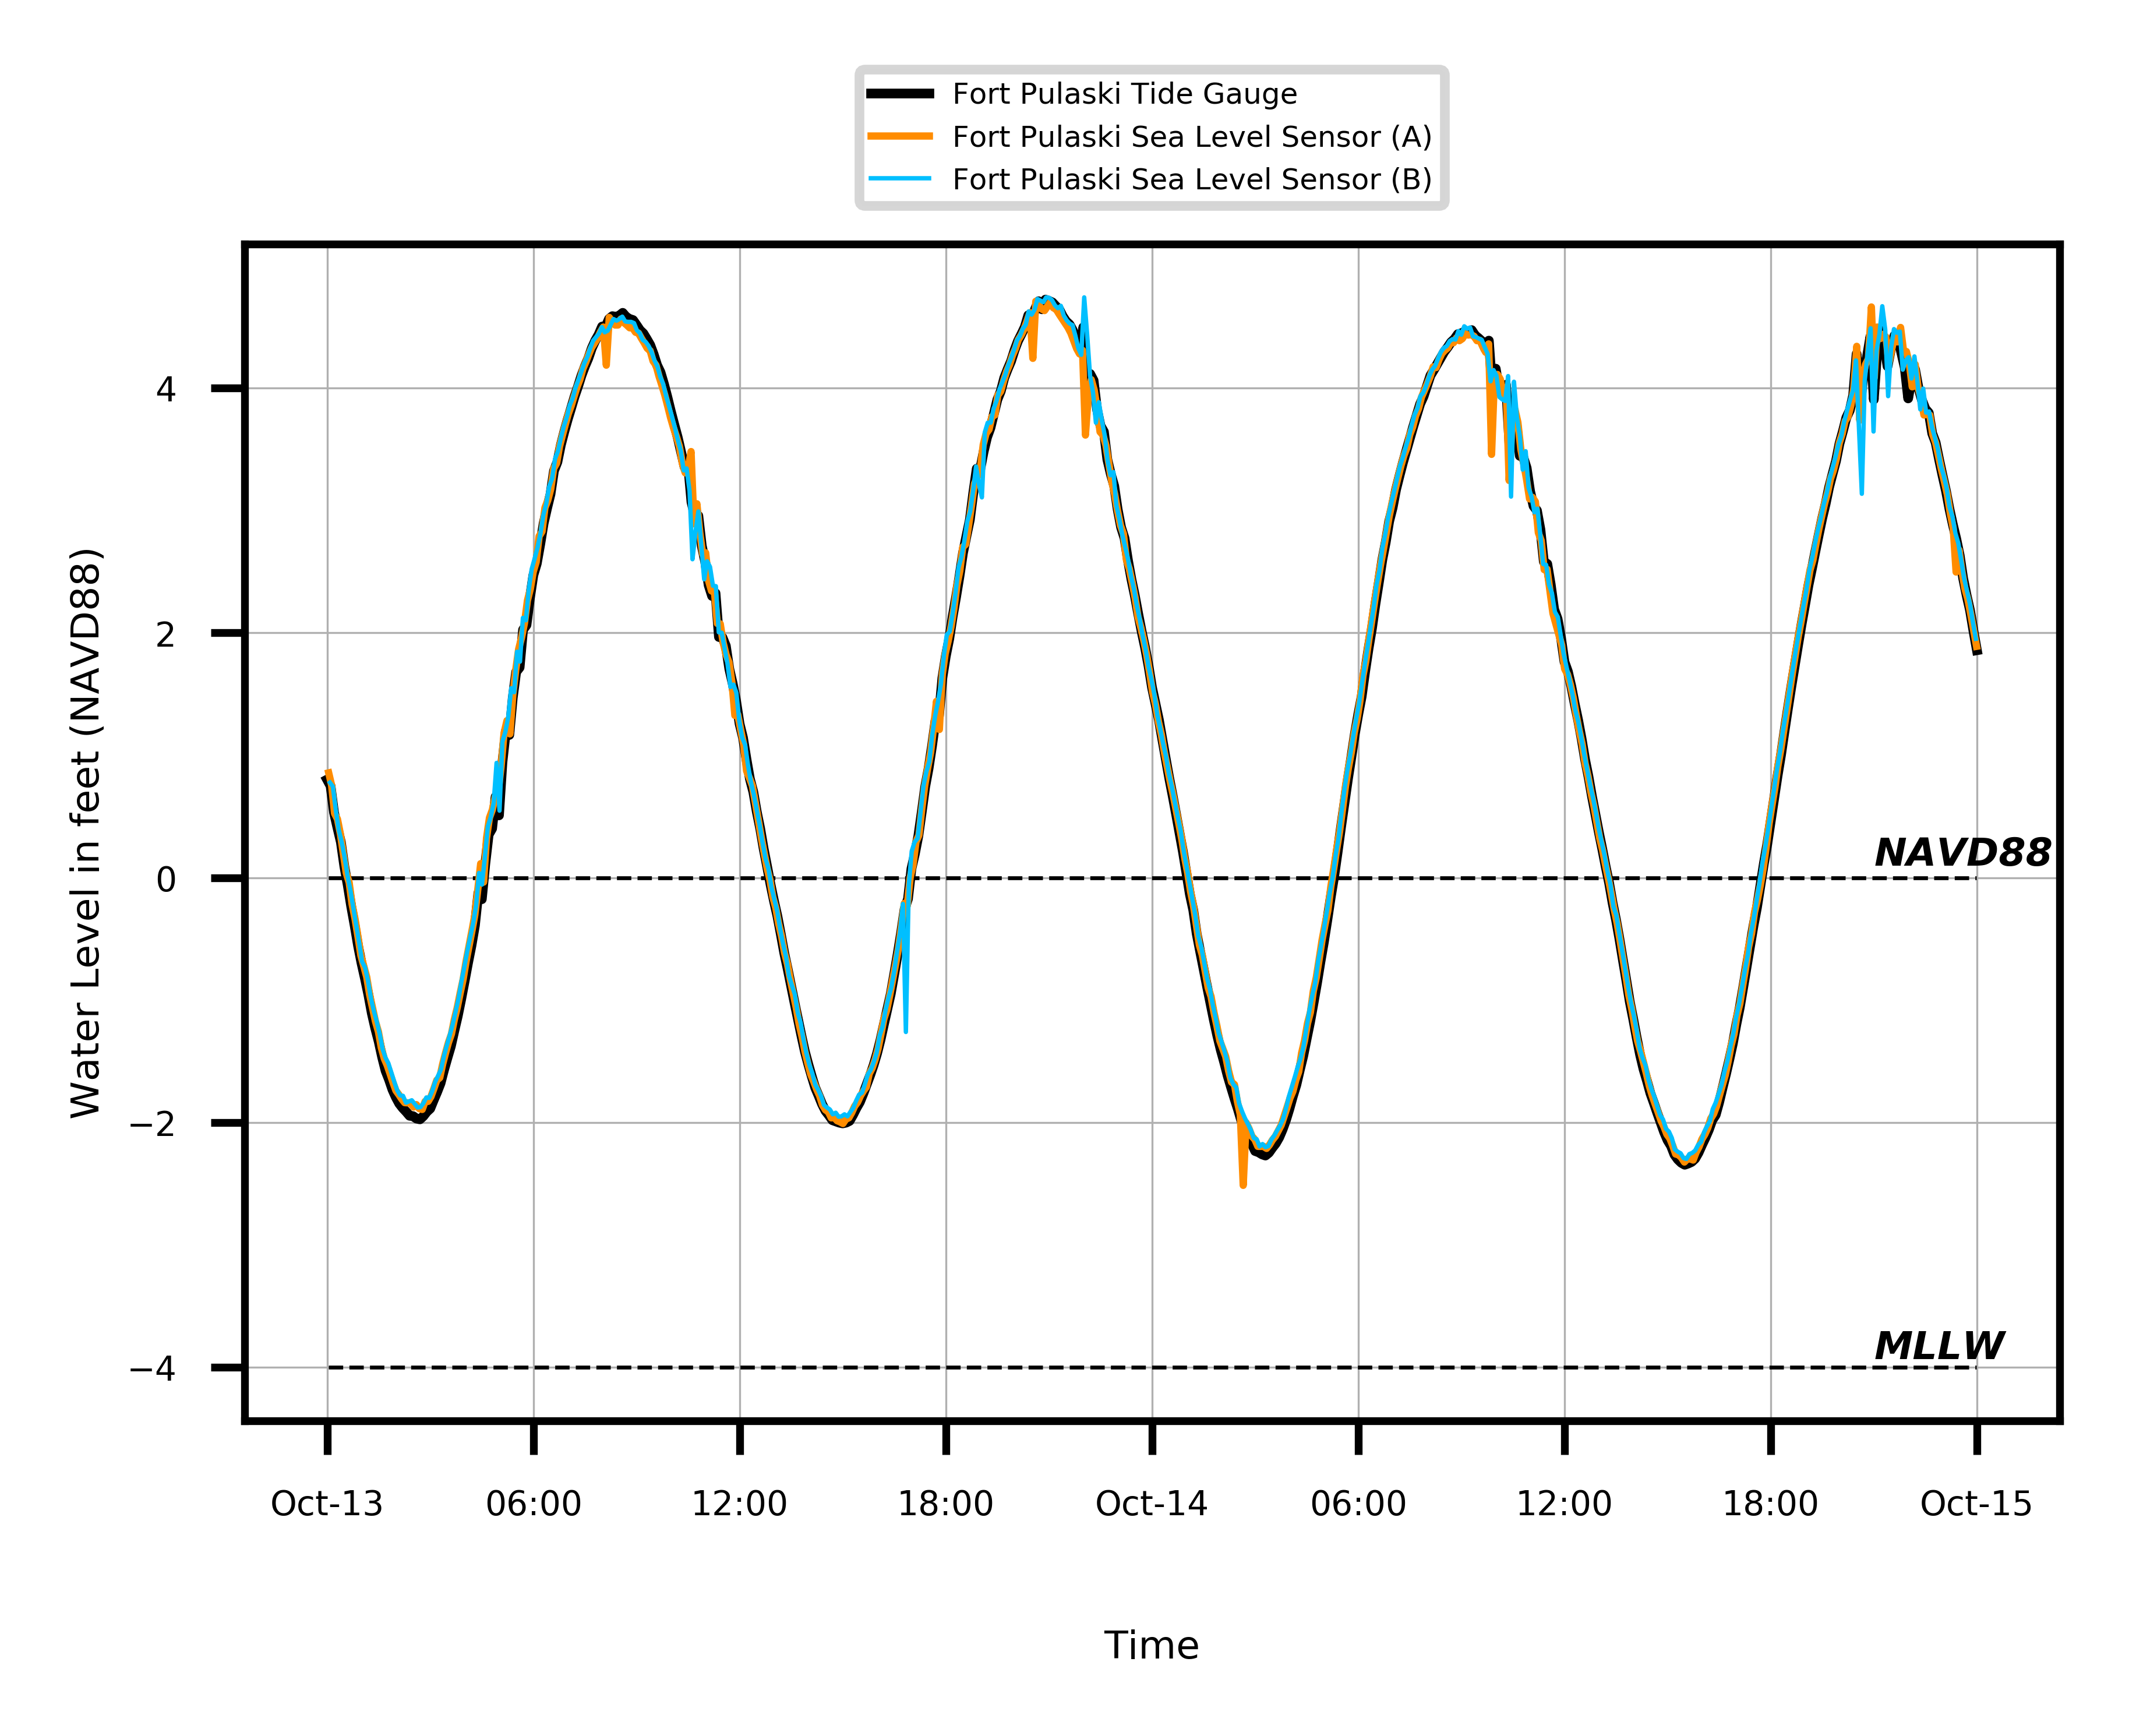

In [9]:
# Plotting the raw data of the NOAA Tide Gauge with Sea Level Sensor (A) and (B)

fig = plt.figure(figsize=(3.35,2.23), dpi=1200)
a0 = fig.add_subplot()

a0.set_ylabel('Water Level in feet (NAVD88)', fontsize=4, labelpad=2 )
a0.set_xlabel('Time', fontsize=4, labelpad=11)
a0.tick_params(axis='x', labelsize=3.5)
a0.tick_params(axis='y', labelsize=3.5)
a0.grid( linewidth=0.2)

#plotting both datasets on one figure
a0.plot(slsA['timestamp'], np.zeros(slsA['timestamp'].size), color='black', linestyle='--', linewidth=0.4, alpha=1)
a0.text(slsA['timestamp'].iloc[-35],0.1, 'NAVD88', style='italic', fontweight='bold', fontsize=4,color='black')
a0.plot(slsA['timestamp'], np.zeros(slsA['timestamp'].size)-4, color='black', linestyle='--', linewidth=0.4, alpha=1)
a0.text(slsA['timestamp'].iloc[-35],-3.93, 'MLLW', style='italic',  fontweight='bold', fontsize=4, color='black')
a0.plot(ftp_data['timestamp'], ftp_data['adj_value'], 'black', label='Fort Pulaski Tide Gauge', linewidth=1, markersize=0.1)
a0.plot(slsA['timestamp'], slsA['adj_value'], 'darkorange', label='Fort Pulaski Sea Level Sensor (A)', linewidth=0.75, markersize=0.1)
a0.plot(slsB['timestamp'], slsB['adj_value'], 'deepskyblue', label='Fort Pulaski Sea Level Sensor (B)', linewidth=0.45, markersize=0.1)

timezone = pytz.timezone("America/New_York")
auto = pldates.AutoDateFormatter(pldates.AutoDateLocator(), tz=timezone)
concise = pldates.ConciseDateFormatter(pldates.AutoDateLocator(), tz=timezone)
a0.xaxis.set_major_formatter(concise)
# a3.get_xaxis().get_major_formatter().set_useOffset(False)

a0.legend(fontsize=3, bbox_to_anchor=(0,1.02,1,0.2), loc='lower center', ncol=1)
# a0.legend(loc='upper left', fontsize=3);


# 2) Error Analysis using Residuals

## SLSA vs FTP

In [10]:
# interpolate the two data streams to calculate the residual (error) between the NOAA Tide Gauge (used as the benchmark) and Fort Pulaski Sea Level Sensor (A)
slsA_func = interp1d(slsA["timestamp"].apply(pldates.date2num), slsA["adj_value"], kind="linear", fill_value="extrapolate")
ftp_func = interp1d(ftp_data['timestamp'].apply(pldates.date2num), ftp_data['adj_value'], kind="linear", fill_value="extrapolate")

# evaluate both interpolated functions at the timestamps of SLS (A) and subtract to find the residual
resA = abs(slsA_func(slsA["timestamp"].apply(pldates.date2num))-ftp_func(slsA["timestamp"].apply(pldates.date2num)))

## SLSB vs FTP

In [11]:
# interpolate the two data streams to calculate the residual (error) between the NOAA Tide Gauge (used as the benchmark) and Fort Pulaski Sea Level Sensor (B)
slsB_func = interp1d(slsB["timestamp"].apply(pldates.date2num), slsB["adj_value"], kind="linear", fill_value="extrapolate")
ftp_func = interp1d(ftp_data['timestamp'].apply(pldates.date2num), ftp_data['adj_value'], kind="linear", fill_value="extrapolate")

# evaluate both interpolated functions at the timestamps of SLS (A) and subtract to find the residual
resB = abs(slsB_func(slsB["timestamp"].apply(pldates.date2num))-ftp_func(slsB["timestamp"].apply(pldates.date2num)))

## SLSA vs SLSB - Reproducability

In [12]:
# interpolate the two data streams to calculate the residual (error) between the NOAA Tide Gauge (used as the benchmark) and Fort Pulaski Sea Level Sensor (A)
slsA_func = interp1d(slsA["timestamp"].apply(pldates.date2num), slsA["adj_value"], kind="linear", fill_value="extrapolate")
slsB_func = interp1d(slsB["timestamp"].apply(pldates.date2num), slsB["adj_value"], kind="linear", fill_value="extrapolate")

# evaluate both interpolated functions at the timestamps of SLS (A) and subtract to find the residual
resAB = abs(slsA_func(slsA["timestamp"].apply(pldates.date2num))-slsB_func(slsA["timestamp"].apply(pldates.date2num)))

## Plot: Raw data with Residuals as Subplots

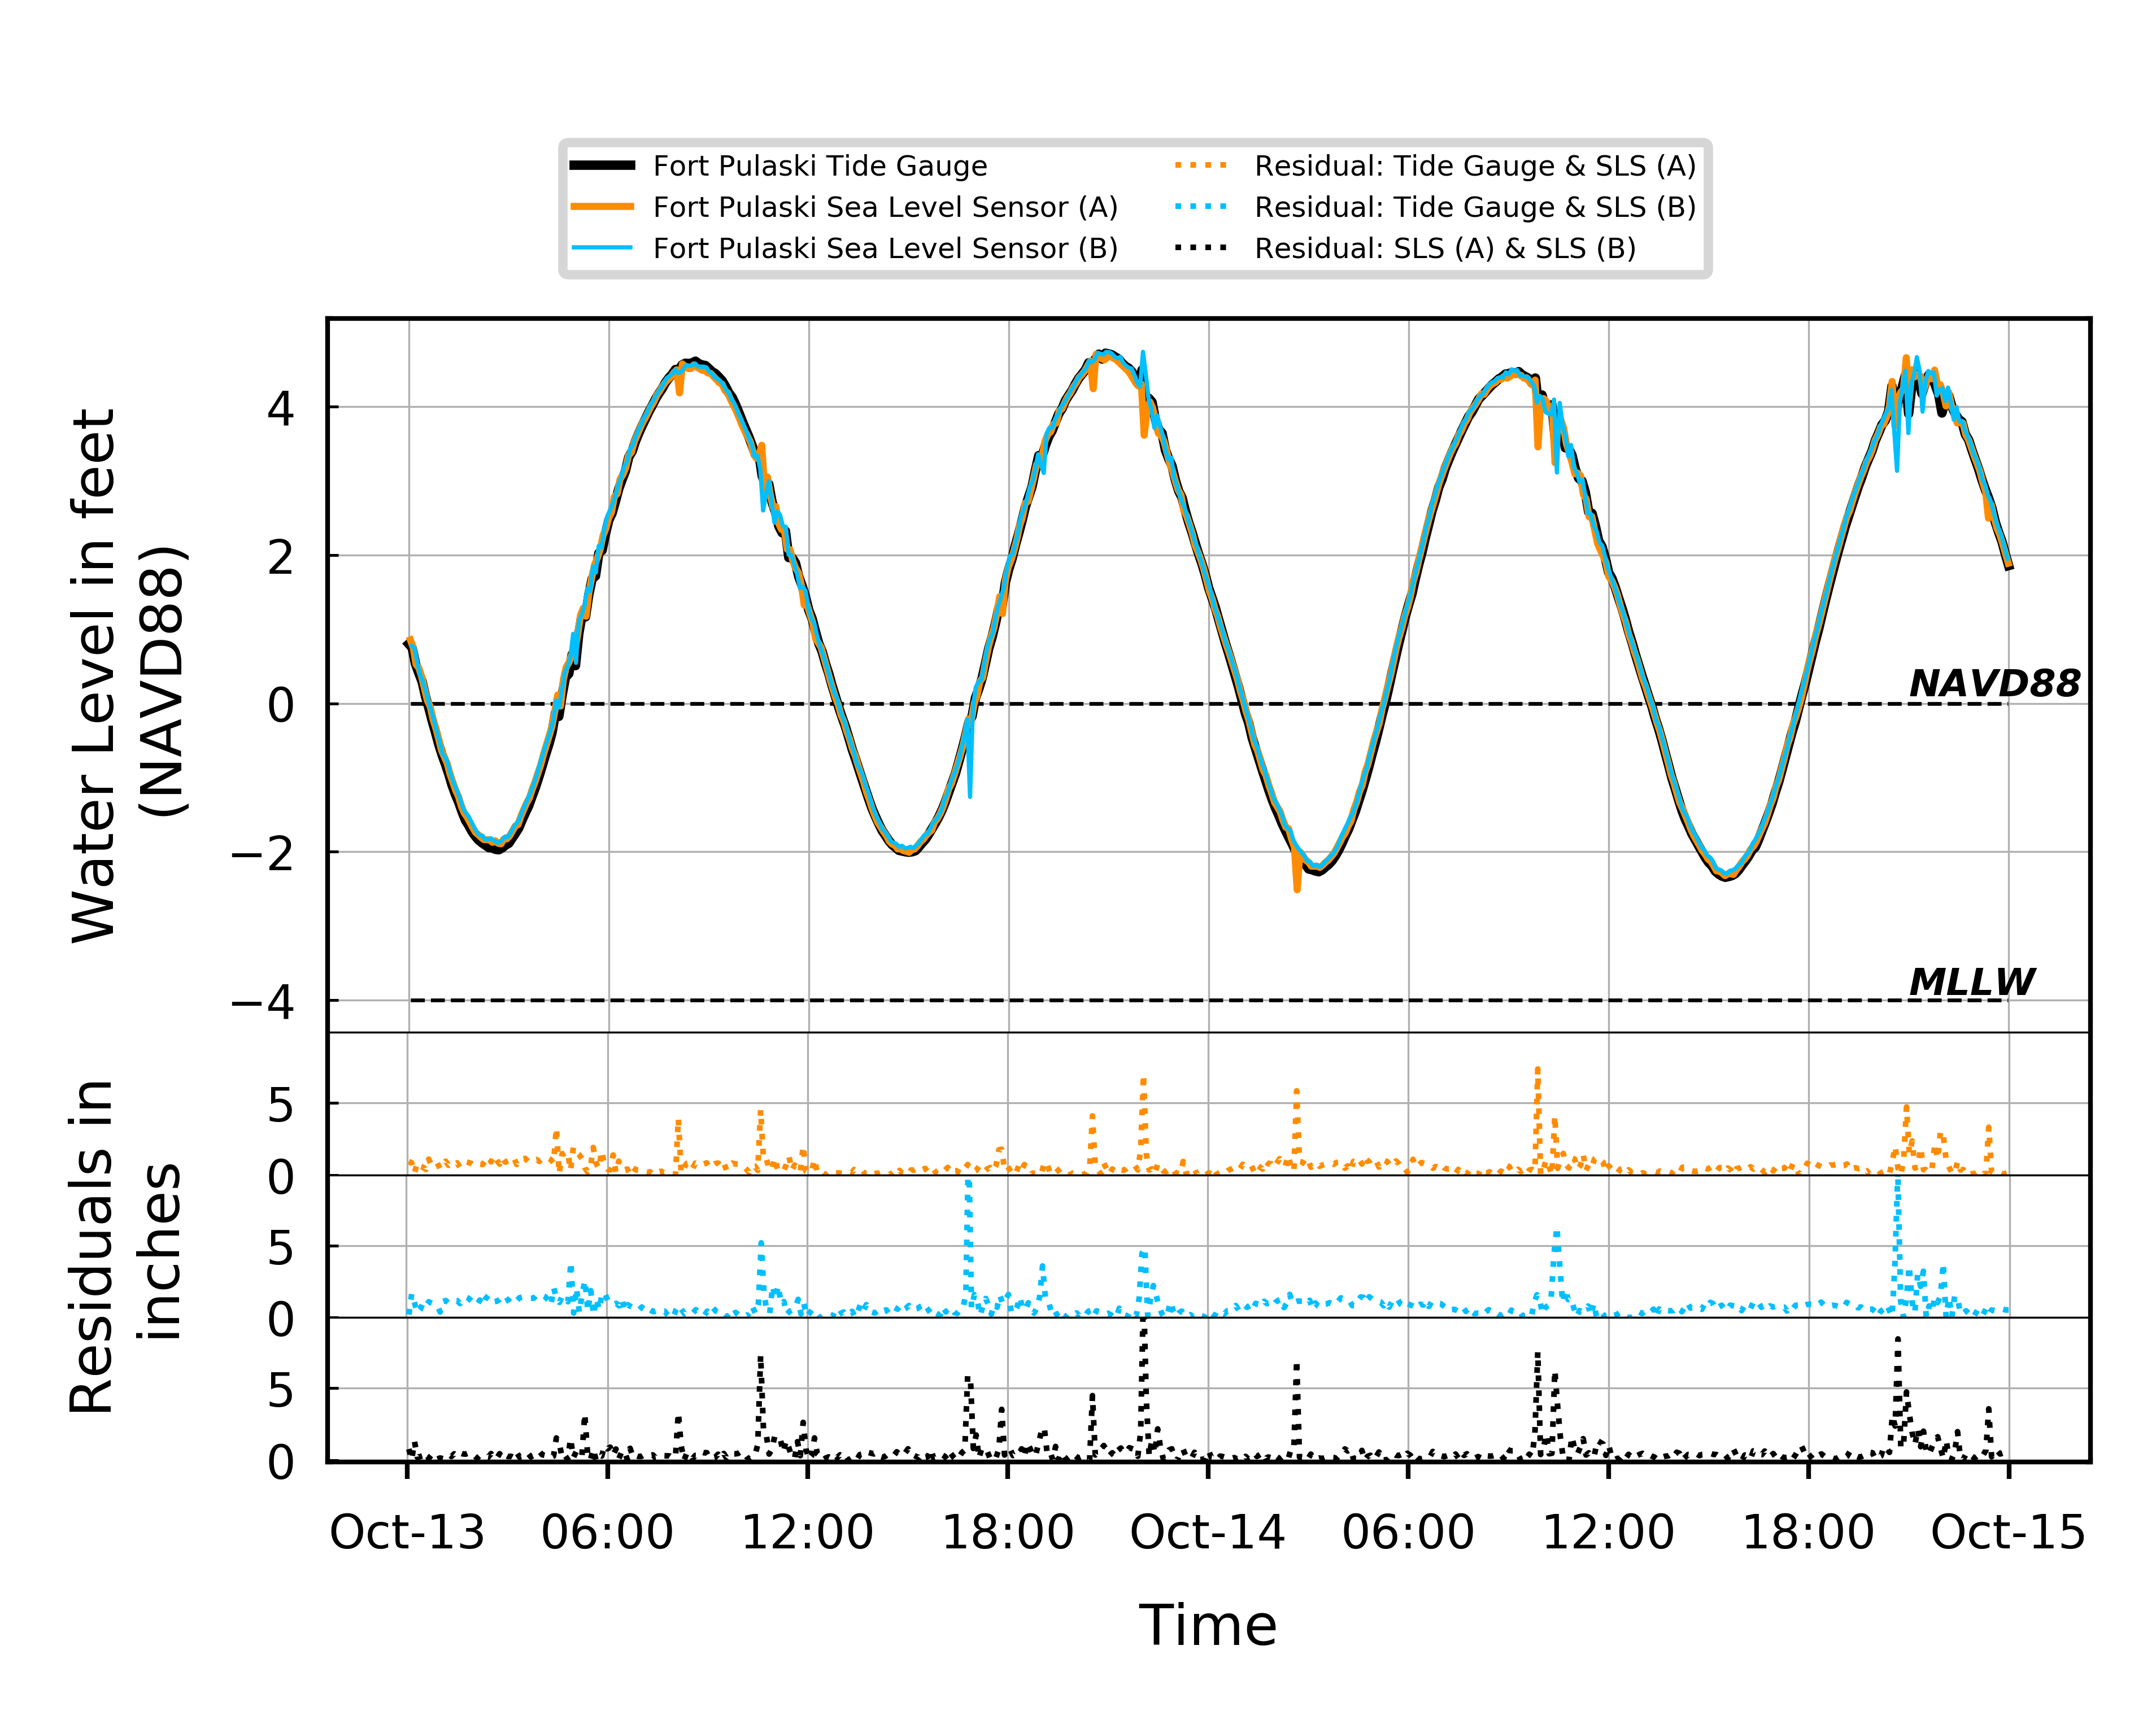

In [13]:
# plot raw data for colocated sea level sensors and NOAA Tide Gauge alongside residuals
fig = plt.figure(figsize=(3.35,2.23), dpi=1200) #gridspec_kw={'hspace': 0, 'wspace': 0})
gs = fig.add_gridspec(8, 1)
fig.subplots_adjust(hspace=0)

a = fig.add_subplot()
a.tick_params(labelbottom=False, labelleft=False, which='both', top=False, bottom=False, left=False, right=False)
#a.set_ylabel('Water Level (ft)', fontsize=30, labelpad=60 )
a.set_xlabel('Time', fontsize=6, labelpad=15)

a0 = fig.add_subplot(gs[0:5, :])
a0.plot(slsA['timestamp'], np.zeros(slsA['timestamp'].size), color='black', linestyle='--', linewidth=0.4, alpha=1)
a0.text(slsA['timestamp'].iloc[-35],0.1, 'NAVD88', style='italic', fontweight='bold', fontsize=4,color='black')
a0.plot(slsA['timestamp'], np.zeros(slsA['timestamp'].size)-4, color='black', linestyle='--', linewidth=0.4, alpha=1)
a0.text(slsA['timestamp'].iloc[-35],-3.93, 'MLLW', style='italic',  fontweight='bold', fontsize=4, color='black')
a0.plot(ftp_data['timestamp'], ftp_data['adj_value'], color='black', label='Fort Pulaski Tide Gauge', linewidth=1)
a0.plot(slsA['timestamp'], slsA['adj_value'], color='darkorange', label='Fort Pulaski Sea Level Sensor (A)', linewidth=0.75)
a0.plot(slsB['timestamp'], slsB['adj_value'], color='deepskyblue', label='Fort Pulaski Sea Level Sensor (B)', linewidth=0.45)
a0.tick_params(axis='y', labelsize=5)
a0.set_ylabel('\n'.join(wrap('Water Level in feet (NAVD88)',20)), fontsize=6, labelpad=4)
a0.grid( linewidth=0.2)
a0.set_xticklabels([])
a0.spines['left'].set_linewidth(0.2)
a0.spines['right'].set_linewidth(0.2)
a0.spines['top'].set_linewidth(0.2)
a0.spines['bottom'].set_linewidth(0.2)
a0.tick_params(axis="y", direction="in", length=1, width=0.3)
# plt.legend(bbox_to_anchor=(0.8, 0.32), fontsize=30)
#plt.legend(loc='upper right', fontsize =30);


a1 = fig.add_subplot(gs[5, :])
a1.plot(slsA["timestamp"], resA*12, color='darkorange', label='Residual: Tide Gauge & SLS (A)', linestyle='dotted', linewidth=0.6)
a1.tick_params(axis='y', labelsize=5)
a1.set_ylim(0, 9.9)
a1.grid(True, linewidth=0.2)
a1.set_xticklabels([])
a1.spines['left'].set_linewidth(0.2)
a1.spines['right'].set_linewidth(0.2)
a1.spines['top'].set_linewidth(0.2)
a1.spines['bottom'].set_linewidth(0.2)
a1.tick_params(axis="y", direction="in", length=1, width=0.3)
# plt.legend(bbox_to_anchor=(0.682, 0.32), fontsize =30);


a2 = fig.add_subplot(gs[6, :])
a2.plot(slsB["timestamp"], resB*12, color='deepskyblue', label='Residual: Tide Gauge & SLS (B)', linestyle='dotted', linewidth=0.6)
a2.tick_params(axis='y', labelsize=5)
a2.set_ylabel('\n'.join(wrap('Residuals in inches',12)), fontsize=6, labelpad=8.5)
a2.set_ylim(0, 9.9)
a2.grid(True, linewidth=0.2)
a2.set_xticklabels([])
a2.spines['left'].set_linewidth(0.2)
a2.spines['right'].set_linewidth(0.2)
a2.spines['top'].set_linewidth(0.2)
a2.spines['bottom'].set_linewidth(0.2)
a2.tick_params(axis="y", direction="in", length=1, width=0.3)
# plt.legend(bbox_to_anchor=(0.682, 0.32), fontsize =30);


a3 = fig.add_subplot(gs[7, :])

timezone = pytz.timezone("America/New_York")
auto = pldates.AutoDateFormatter(pldates.AutoDateLocator(), tz=timezone)
concise = pldates.ConciseDateFormatter(pldates.AutoDateLocator(), tz=timezone)
a3.xaxis.set_major_formatter(concise)
# a3.get_xaxis().get_major_formatter().set_useOffset(False)

a3.plot(slsA["timestamp"], resAB*12, color='black', label='Residual: SLS (A) & SLS (B)', linestyle='dotted', linewidth=0.6)
a3.tick_params(axis="y", labelsize=5)
a3.tick_params(axis="x", labelsize=5)
a3.set_ylim(0, 9.9)
a3.grid(b=True, linewidth=0.2)
a3.spines['left'].set_linewidth(0.2)
a3.spines['right'].set_linewidth(0.2)
a3.spines['top'].set_linewidth(0.2)
a3.spines['bottom'].set_linewidth(0.2)
a3.tick_params(axis="y", direction="in", length=1, width=0.3)
a3.tick_params(axis="x", direction="out", length=2, width=0.5)

fig.legend(fontsize=3, bbox_to_anchor=(0,0.95,1,0), loc='lower center', ncol=2)
# fig.legend( loc="upper center",borderaxespad=0.9, fancybox=True, shadow=False, ncol=2, fontsize = 3)
# plt.subplots_adjust(bottom=0.16)

# fig.tight_layout()
fig.patch.set_facecolor('white')

# plt.savefig('FTP_Benchmark.jpg', bbox_inches='tight', dpi=1200)#, bbox_extra_artist=[fig.legend])


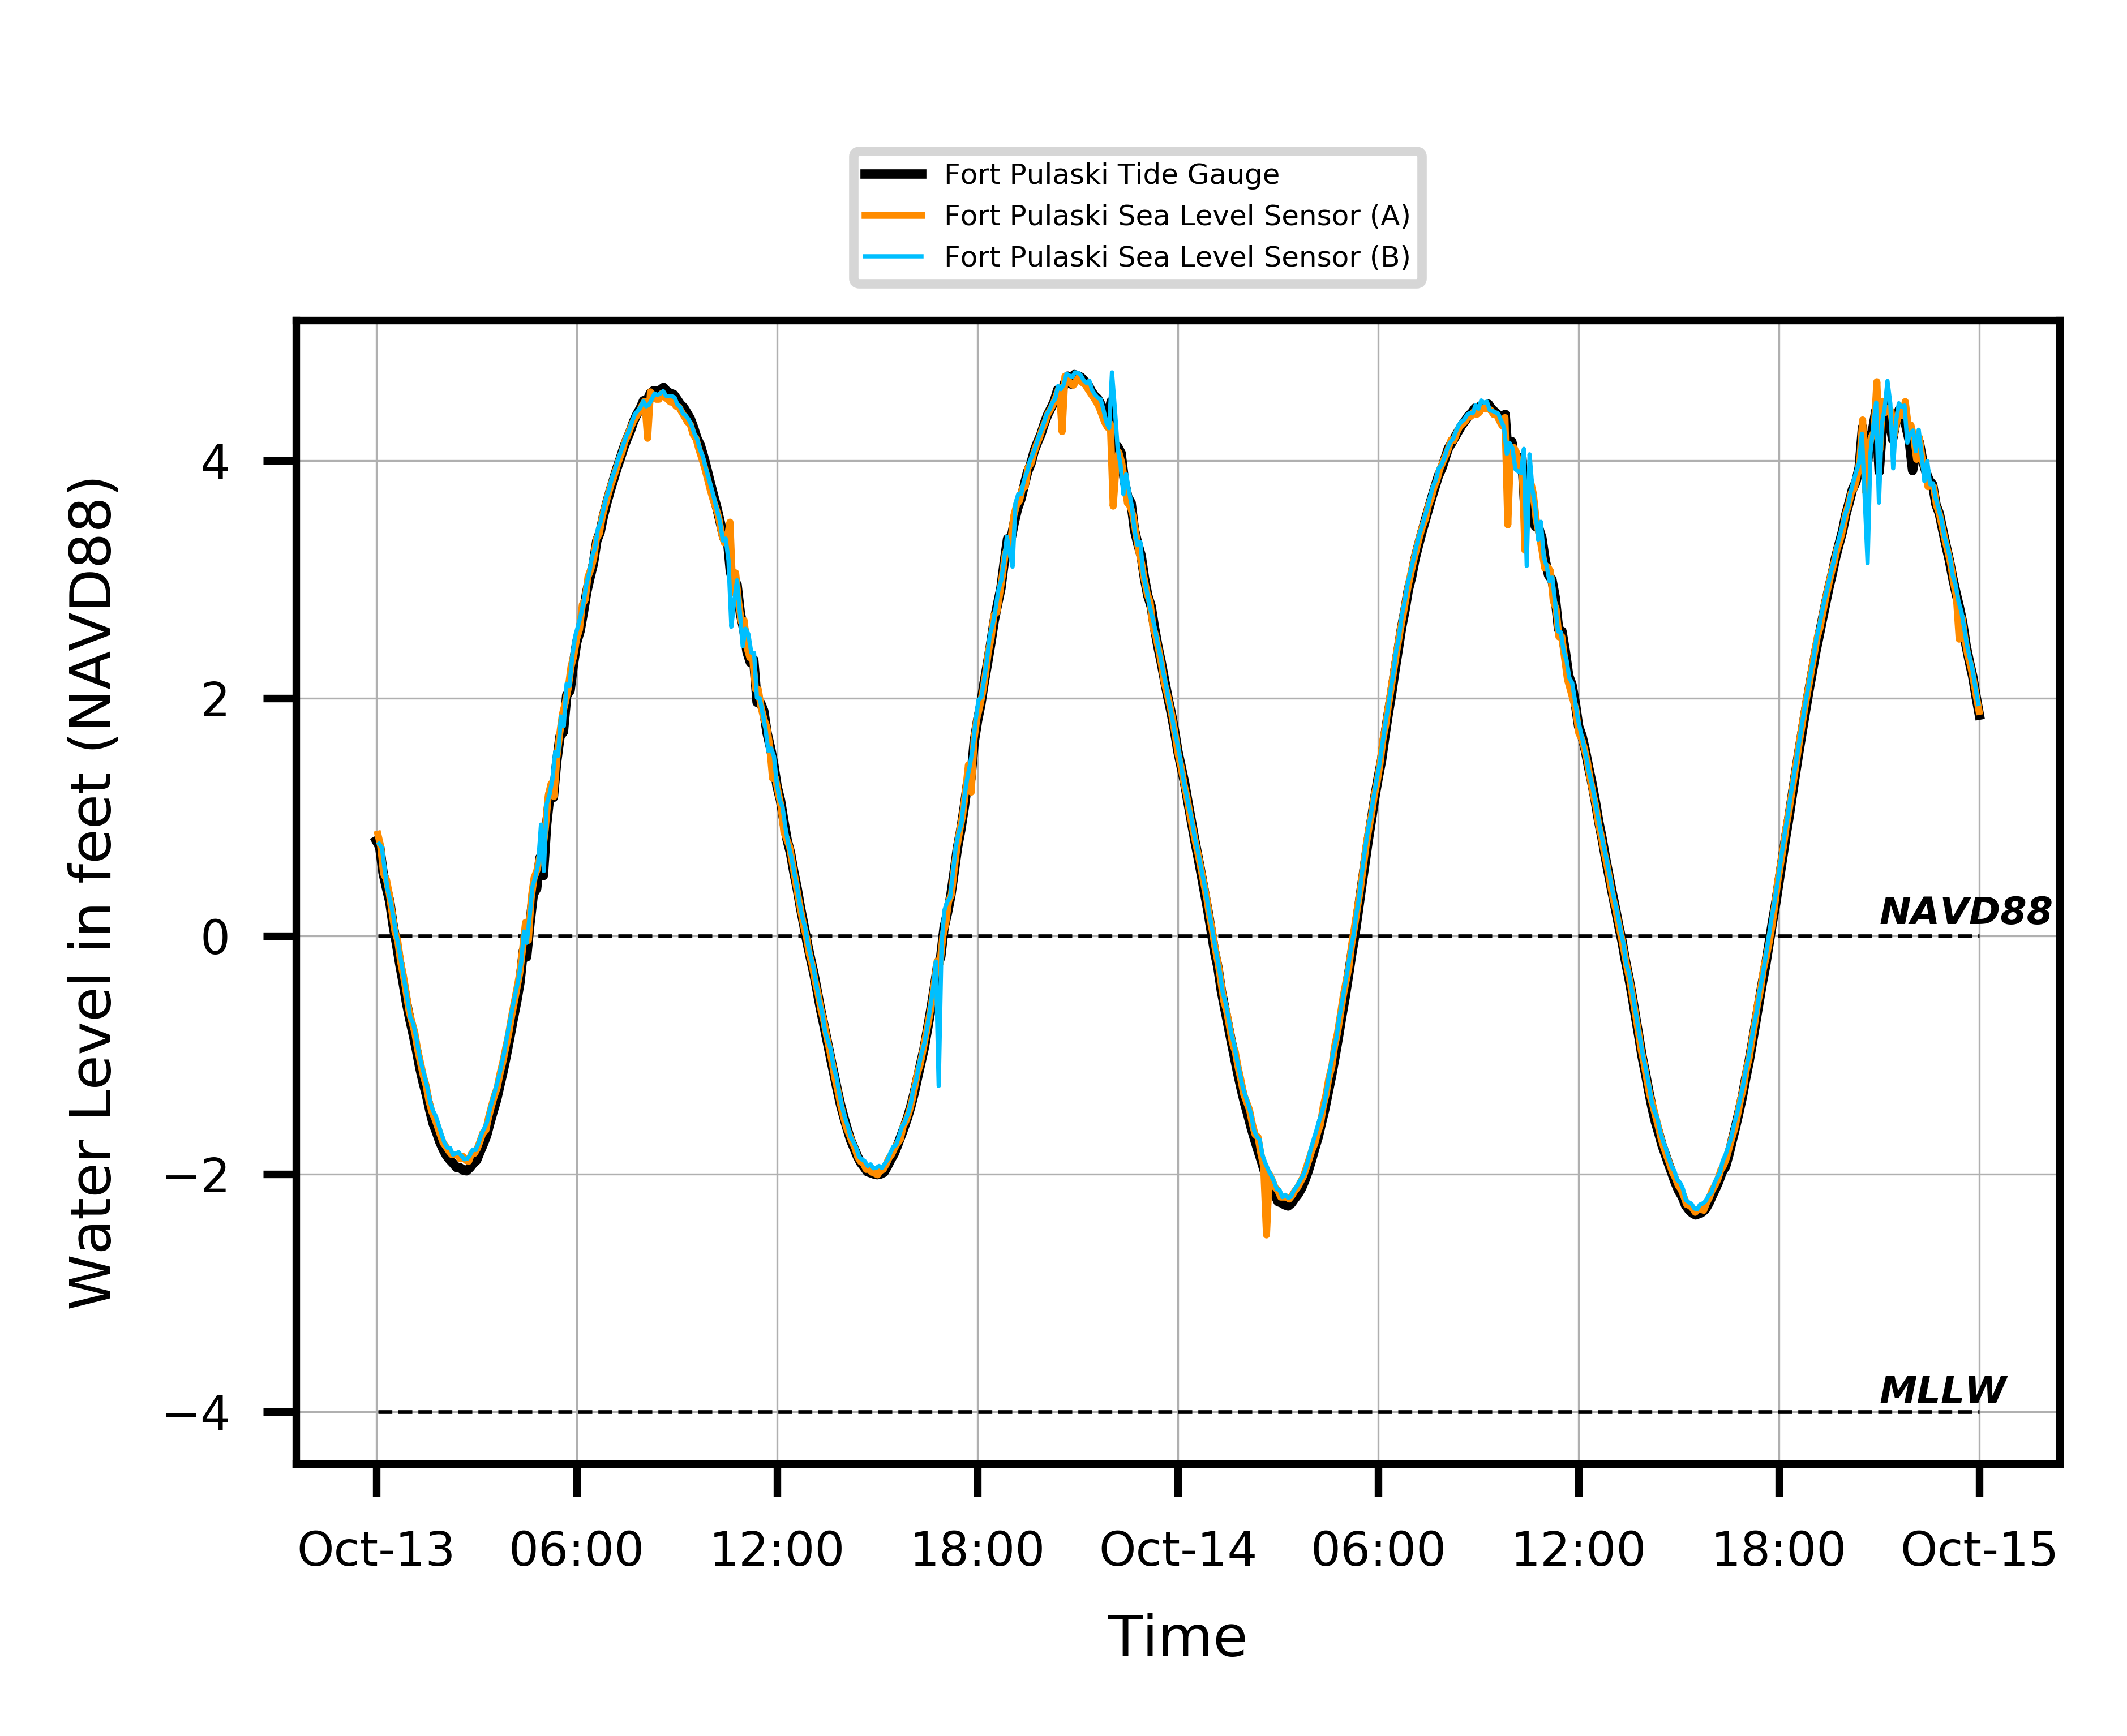

In [14]:
# NO RESIDUAL SUBPLOTS**************


fig = plt.figure(figsize=(3.35,2.23), dpi=1200) #gridspec_kw={'hspace': 0, 'wspace': 0})
# gs = fig.add_gridspec(8, 1)
fig.subplots_adjust(hspace=0)

a0 = fig.add_subplot()
# a0.tick_params(labelbottom=False, labelleft=False, which='both', top=False, bottom=False, left=False, right=False)
#a.set_ylabel('Water Level (ft)', fontsize=30, labelpad=60 )

# a0 = fig.add_subplot(gs[0:5, :])
a0.plot(slsA['timestamp'], np.zeros(slsA['timestamp'].size), color='black', linestyle='--', linewidth=0.4, alpha=1)
a0.text(slsA['timestamp'].iloc[-35],0.1, 'NAVD88', style='italic', fontweight='bold', fontsize=4,color='black')
a0.plot(slsA['timestamp'], np.zeros(slsA['timestamp'].size)-4, color='black', linestyle='--', linewidth=0.4, alpha=1)
a0.text(slsA['timestamp'].iloc[-35],-3.93, 'MLLW', style='italic',  fontweight='bold', fontsize=4, color='black')
a0.plot(ftp_data['timestamp'], ftp_data['adj_value'], color='black', label='Fort Pulaski Tide Gauge', linewidth=1)
a0.plot(slsA['timestamp'], slsA['adj_value'], color='darkorange', label='Fort Pulaski Sea Level Sensor (A)', linewidth=0.75)
a0.plot(slsB['timestamp'], slsB['adj_value'], color='deepskyblue', label='Fort Pulaski Sea Level Sensor (B)', linewidth=0.45)
a0.tick_params(axis='y', labelsize=5)
a0.tick_params(axis='x', labelsize=5)
a0.set_ylabel('Water Level in feet (NAVD88)', fontsize=6, labelpad=4 )
a0.set_xlabel('Time', fontsize=6, labelpad=4)
a0.grid( linewidth=0.2)
# a0.set_xticklabels([])
# a0.spines['left'].set_linewidth(0.2)
# a0.spines['right'].set_linewidth(0.2)
# a0.spines['top'].set_linewidth(0.2)
# a0.spines['bottom'].set_linewidth(0.2)
# a0.tick_params(axis="y", direction="in", length=1, width=0.3)
# plt.legend(bbox_to_anchor=(0.8, 0.32), fontsize=30)
#plt.legend(loc='upper right', fontsize =30);

timezone = pytz.timezone("America/New_York")
auto = pldates.AutoDateFormatter(pldates.AutoDateLocator(), tz=timezone)
concise = pldates.ConciseDateFormatter(pldates.AutoDateLocator(), tz=timezone)
a0.xaxis.set_major_formatter(concise)

fig.legend(fontsize=3, bbox_to_anchor=(0,0.95,1,0), loc='lower center', ncol=1)
# fig.legend( loc="upper center",borderaxespad=0.9, fancybox=True, shadow=False, fontsize = 3)

fig.patch.set_facecolor('white')

# plt.savefig('FTP_Benchmark_NoRes.jpg', bbox_inches='tight',dpi=1200)#, bbox_extra_artist=[fig.legend])



# 3) Spatial Analysis

In [ ]:
sensor trough time diff: sKIO is weird
sensor creset time diff: savannah state, and the 62min sensor

In [15]:
# format should be YYYY-mm-dd HH:MM, in EST (NOAA Tide Gauge Local Time)  
spatial_start = '2020-02-24 00:00' 
spatial_end = '2020-03-23 00:00'

## High/Low Tide Finder for NOAA Tide Gauge

In [16]:
"""
this program finds all the high and low tide levels along with the timestamps of those max/min levels
it does this by taking 12hr segments of the data and locating the max and mins. then, starting from the timestamps 
of those maxes and mins, a temporary 12hr segment of data is selected and max, mins, and timestamps are noted.
repeated levels are avoided by comparing the timestamp of the current max/min to the timestamp of the previous max/min 
if they are within 6 hours of each other (this could be decreased to probably 1hr), they are compared to see which is 
truly the local max/min. Even in moments of erroneous sensor outputs, only one max/min will be reported
"""

def find_tidal_extrema_NOAA(start_date, end_date):
    
    # get NOAA's Fort Pulaski Tide Gauge Data
    ftp_data = get_noaa_water_level_data(start_date, end_date)
    
    # assigning tide gauge local time (EST) timezone to start_date
    start_dt = datetime.strptime(start_date, "%Y-%m-%d %H:%M")
    est = pytz.timezone("America/New_York")
    start_est = est.localize(start_dt)

    # initializing lists
    max_times = []
    min_times = []
    maxes = []
    mins = []

    # these values appended for the timestamp comparison to function properly. These values will be excluded during analysis
    max_times.append(start_est-timedelta(hours=12))
    min_times.append(start_est-timedelta(hours=12))
    maxes.append(-100)
    mins.append(100)

    # current_set is used to track the current set of 12hr data, and i is used to keep the start and end intervals of current_set
    # consistent as we shift current_set forward
    i=0
    current_set = ftp_data[ftp_data['timestamp']<=(start_est+timedelta(hours=((i*12)+12)))]

    # loops forward through each 12hr set of data while making sure current_set doesnt exceed the end time
    while (current_set.tail(1)['timestamp'].values)<=(ftp_data.tail(1)['timestamp'].values):

    # temporarily storing max, mins, and timestamps 
        current_max_time = current_set['timestamp'][current_set['adj_value'].idxmax()]
        current_min_time = current_set['timestamp'][current_set['adj_value'].idxmin()]
        current_max = current_set['adj_value'].max()
        current_min = current_set['adj_value'].min()

    # making sure max/min and timestamps aren't repeat and only storing the true local max/min along with its timestamp
    # if the timestamp of the previous max/min is equal to current max/min timestamp, nothing happens since that value is already stored
        if (min_times[-1]!=current_min_time) & ((current_min_time-min_times[-1])<timedelta(hours=6)) & (current_min<mins[-1]):
            mins[-1]=current_min
            min_times[-1]=current_min_time
        elif ((current_min_time-min_times[-1])>timedelta(hours=6)):
            mins.append(current_min)
            min_times.append(current_min_time)

        if (max_times[-1]!=current_max_time) & ((current_max_time-max_times[-1])<timedelta(hours=6)) & (current_max>maxes[-1]):
            maxes[-1]=current_max
            max_times[-1]=current_max_time
        elif ((current_max_time-max_times[-1])>timedelta(hours=6)):
            maxes.append(current_max)
            max_times.append(current_max_time)

    # temperorary 12hr dataset starting at the min within the current dataset
    # used to make sure no max values are missed since tidal cycles aren't in perfect intervals or consistency
        temp_set_for_max = ftp_data[(ftp_data.timestamp>=min_times[-1])&(ftp_data.timestamp<=(min_times[-1]+timedelta(hours=12)))]
        temp_max = temp_set_for_max['adj_value'].max()
        temp_max_time = temp_set_for_max['timestamp'][temp_set_for_max['adj_value'].idxmax()]

    # temperorary 12hr dataset starting at the max within the current dataset
    # used to make sure no min values are missed since tidal cycles aren't in perfect interval or consistency
        temp_set_for_min = ftp_data[(ftp_data.timestamp>=max_times[-1])&(ftp_data.timestamp<=(max_times[-1]+timedelta(hours=12)))]
        temp_min = temp_set_for_min['adj_value'].min()
        temp_min_time = temp_set_for_min['timestamp'][temp_set_for_min['adj_value'].idxmin()]

    # making sure max/min and timestamps aren't repeat and only storing the true local max/min along with its timestamp
    # if the timestamp of the previous max/min is equal to current max/min timestamp, nothing happens since that value is already stored
        if (min_times[-1]!=temp_min_time) & ((temp_min_time-min_times[-1])<timedelta(hours=6)) & (temp_min<mins[-1]):
            mins[-1]=temp_min
            min_times[-1]=temp_min_time
        elif ((temp_min_time-min_times[-1])>timedelta(hours=6)):
            mins.append(temp_min)
            min_times.append(temp_min_time)

        if (max_times[-1]!=temp_max_time) & ((temp_max_time-max_times[-1])<timedelta(hours=6)) & (temp_max>maxes[-1]):
            maxes[-1]=temp_max
            max_times[-1]=temp_max_time
        elif ((temp_max_time-max_times[-1])>timedelta(hours=6)):
            maxes.append(temp_max)
            max_times.append(temp_max_time) 

        # moving the current set forward by 12 hours
        i+=1
        current_set = ftp_data[(ftp_data['timestamp']>(start_est+timedelta(hours=(i*12))))&(ftp_data['timestamp']<=(start_est+timedelta(hours=((i*12)+12))))]

    # deleting the first values that were temporary
    del mins[0]
    del min_times[0]
    del maxes[0]
    del max_times[0]
    
    return mins, min_times, maxes, max_times

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<IPython.core.display.Javascript object>


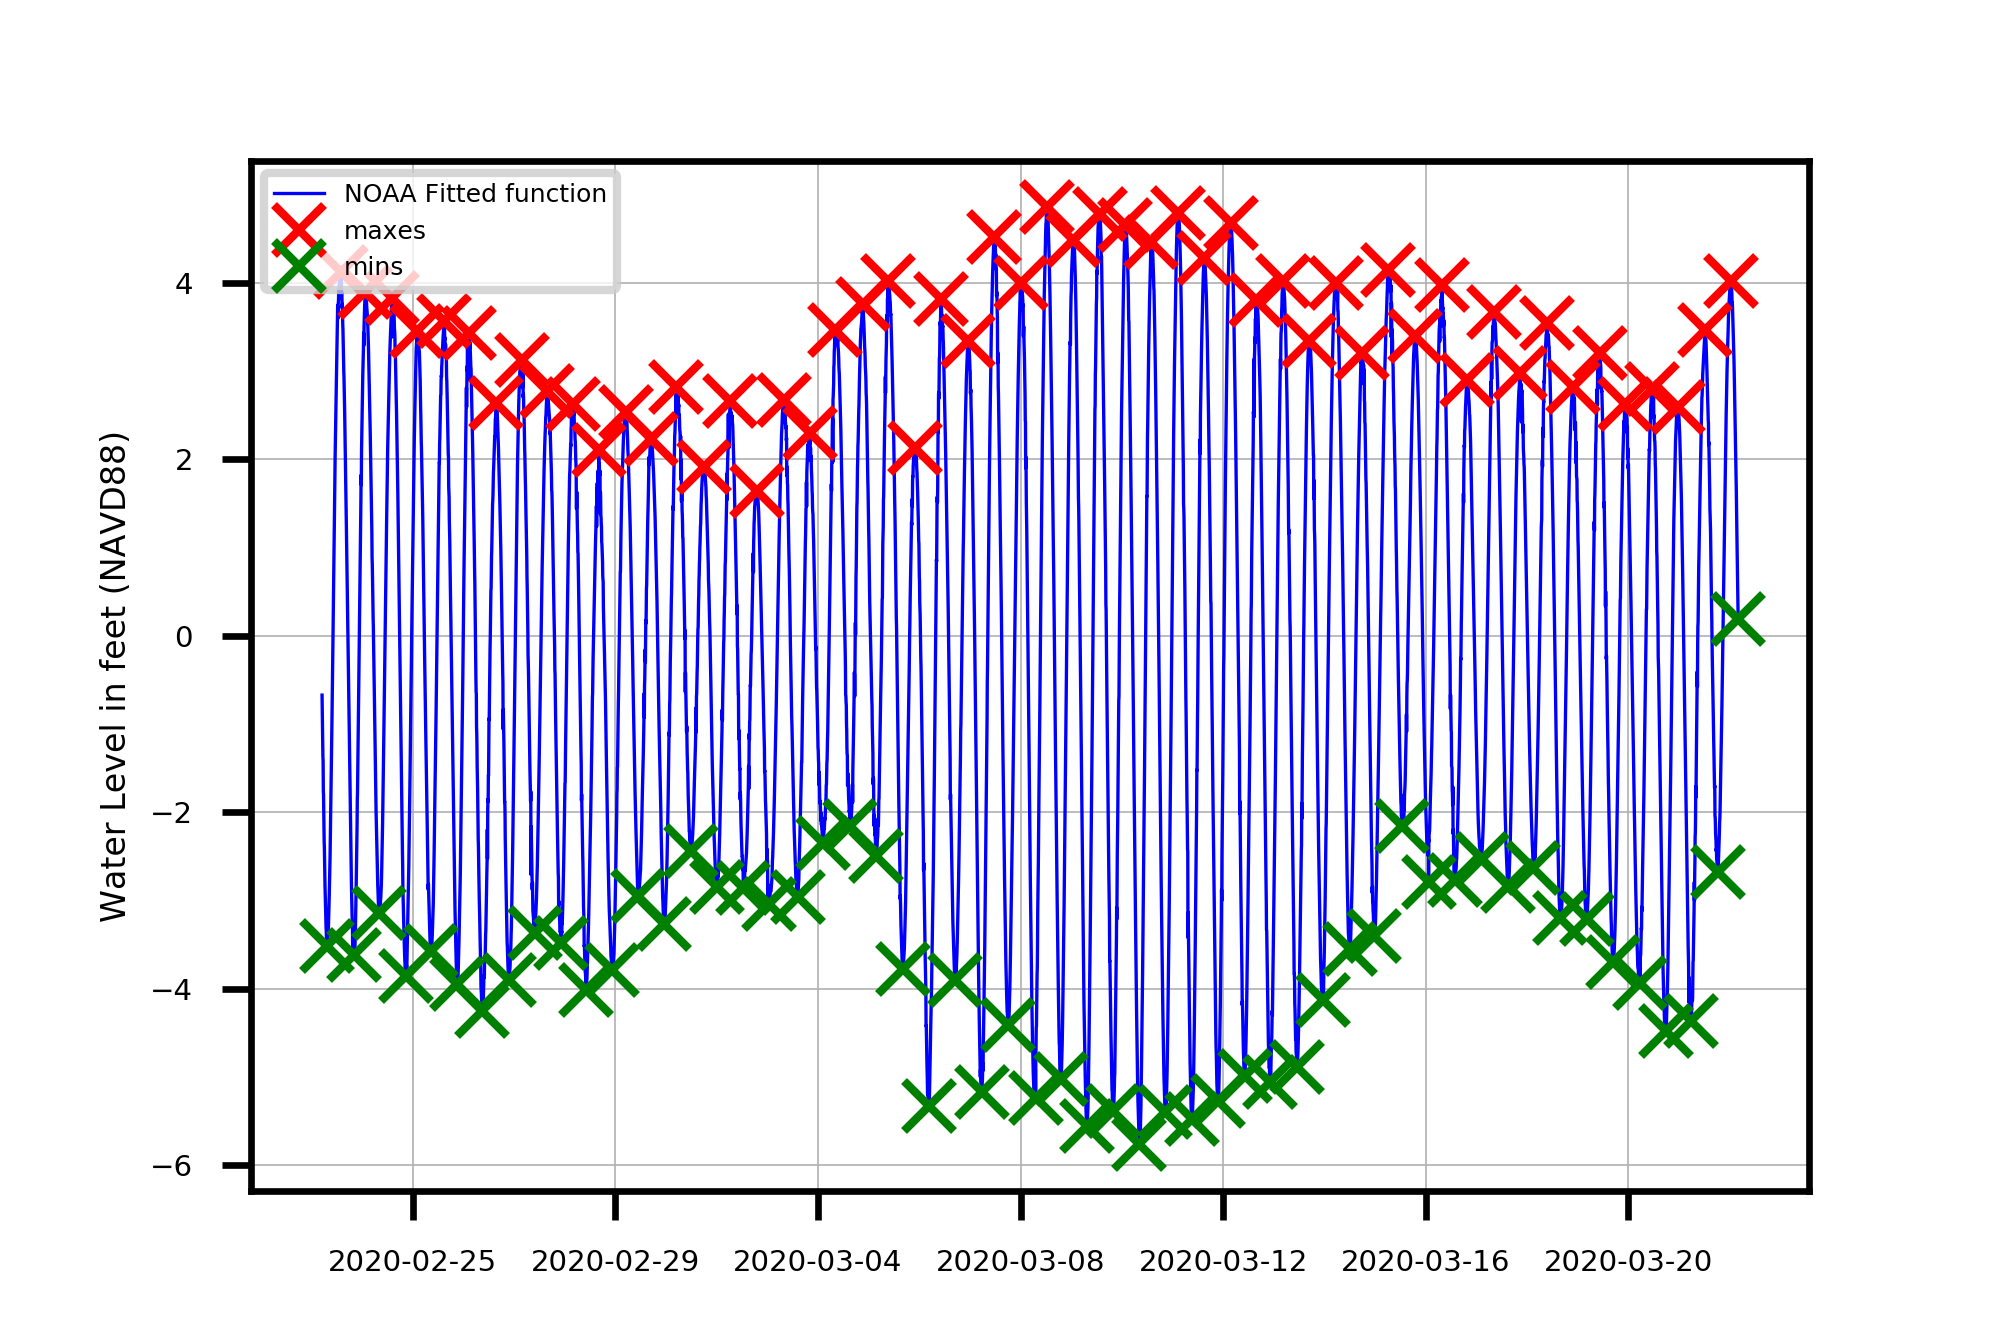

In [18]:
%matplotlib notebook

# get NOAA Tide Gauge Data
ftp_data = get_noaa_water_level_data(spatial_start, spatial_end)

# find the extremas
mins_NOAA, min_times_NOAA, maxes_NOAA, max_times_NOAA = find_tidal_extrema_NOAA(spatial_start, spatial_end)

# plot
fig = plt.figure(figsize=(3.35,2.23), dpi=300)
ax = fig.add_subplot(1,1,1)
plt.ylabel('Water Level in feet (NAVD88)', fontsize=4, labelpad=2 )
plt.xlabel('Time', fontsize=4, labelpad=11)
plt.tick_params(axis='x', labelsize=3.5)
plt.tick_params(axis='y', labelsize=3.5)
plt.grid( linewidth=0.2)

plt.plot(ftp_data['timestamp'], ftp_data['adj_value'], label='NOAA Fitted function', color="blue", linewidth=0.4)
plt.plot(max_times_NOAA, maxes_NOAA, 'rx', label='maxes')
plt.plot(min_times_NOAA, mins_NOAA, 'gx', label='mins')

ax.xaxis.set_major_locator(pldates.DayLocator(interval=4)) 

plt.legend(loc='upper left', fontsize=3);



## High/Low Tides for all Sea Level Sensors  -- with Nearest Neighbor Filter

In [19]:
"""
this program basically finds all the maximum high and minimum low tide levels along with the timestamps of those max/min levels
it does this by taking 12hr segments of the data and locating the max and mins. then, starting from the timestamps 
of those maxes and mins, a temporary 12hr segment of data is selected and max, mins, and timestamps are noted.
repeated levels are avoided by comparing the timestamp of the current max/min to the timestamp of the previous max/min 
if they are within 6 hours of each other (this could be decreased to probably 1hr), they are compared to see which is 
truly the local max/min. Even in moments of erroneous sensor outputs, only one max/min will be reported
"""

def find_tidal_extram_SLS(start_date, end_date):
    
    # assigning tide gauge local time (EST) timezone to start_date
    start_dt = datetime.strptime(start_date, "%Y-%m-%d %H:%M")
    est = pytz.timezone("America/New_York")
    start_est = est.localize(start_dt)

    # initializing lists
    max_times = []
    min_times = []
    maxes = []
    mins = []
    max_sensor_name = []
    min_sensor_name = []

    filter_data_loss = []
    num_returns = []
    filter_data_loss_name = []


    # looping through all sensors with water level readings
    for index in sensors_water.index:

        # if the a sensor has no data to pull in this time frame, it will be skipped
        sls_data = get_sls_water_level_data(sensors_water.desc[index], start_date, end_date)
        if sls_data.size > 0:
            
            """
            nearest neighbor filtering - assuming tidal water levels won't change more than 0.3ft (adjustable), aside from waves.
            this filter acts similar to a noise filter, which was also tested, that filters out high frequency noise, generally caused by waves/wind
            """
            count_before_filter = len(sls_data)
            num_returns.append(count_before_filter)
            sls_data = sls_data[abs(sls_data['adj_value'] - sls_data['adj_value'].shift(1)) < 0.3] 
            sls_data = sls_data[abs(sls_data['adj_value'] - sls_data['adj_value'].shift(-1)) < 0.3] 
            count_after_filter = len(sls_data)
            filter_data_loss.append((count_before_filter-count_after_filter)/count_before_filter)
            filter_data_loss_name.append(sensors_water.desc[index])
            # print(count_before_filter,count_after_filter)

            """
            Each time the next sensor's data is pulled, these values will be appended to the running list as separaters
            for the timestamp comparison to function properly. These values will be excluded during analysis. The number
            of "fake" sensors can also be used to see how many total sensors had usable data
            """
            max_times.append(start_est-timedelta(hours=12))
            min_times.append(start_est-timedelta(hours=12))
            maxes.append(-100)
            mins.append(100)
            max_sensor_name.append('fake')
            min_sensor_name.append('fake')

            # track the current set of 12hr data with current_set
            # use i to keep the start and end intervals of current_set consistent as we shift current_set forward
            i=0
            current_set = sls_data[sls_data['timestamp']<=pd.to_datetime(start_est+timedelta(hours=((i*12)+12)))]

            # loop forward through each 12hr set of data while making sure current_set doesnt exceed the end time
            while (current_set.tail(1)['timestamp'].values)<=(sls_data.tail(1)['timestamp'].values) :

                # temporarily storing max, mins, and timestamps 
                current_max_time = current_set['timestamp'][current_set['adj_value'].idxmax()]
                current_min_time = current_set['timestamp'][current_set['adj_value'].idxmin()]
                current_max = current_set['adj_value'].max()
                current_min = current_set['adj_value'].min()

                # ensure max/min and timestamps aren't repeats, storing only the true local max/min along with their timestamp
                # if the timestamp of the previous max/min is equal to current max/min timestamp, nothing happens since that value is already stored
                if (min_times[-1]!=current_min_time) & ((current_min_time-min_times[-1])<timedelta(hours=6)) & (current_min<mins[-1]):
                    mins[-1]=current_min
                    min_times[-1]=current_min_time
                    min_sensor_name[-1]=sensors_water.desc[index]
                elif ((current_min_time-min_times[-1])>=timedelta(hours=6)):
                    mins.append(current_min)
                    min_times.append(current_min_time)
                    min_sensor_name.append(sensors_water.desc[index])

                if (max_times[-1]!=current_max_time) & ((current_max_time-max_times[-1])<timedelta(hours=6)) & (current_max>maxes[-1]):
                    maxes[-1]=current_max
                    max_times[-1]=current_max_time
                    max_sensor_name[-1]=sensors_water.desc[index]
                elif ((current_max_time-max_times[-1])>=timedelta(hours=6)):
                    maxes.append(current_max)
                    max_times.append(current_max_time)
                    max_sensor_name.append(sensors_water.desc[index])

                """
                if a sensor goes down in the middle of the time period that we're studying, then the difference 
                calculations later on will be incorrect because of mismatched timestamps of maxes/mins. 
                therefore, we look at the timestamps between the last two and see if the difference is greater than 18hrs
                if so, then the number of hours difference is divided by 12 and that many instances of NAN/NAT are insterted
                """
                if (((max_times[-1] - max_times[-2])>timedelta(hours=18)) and max_sensor_name[-2]!='fake' and max_sensor_name[-1]!='fake'):
                    for j in range(math.floor(((max_times[-1] - max_times[-2]).total_seconds()/3600)/12)-1):
                        maxes.insert(len(maxes)-1,float('NaN'))
                        max_times.insert(len(max_times)-1,pd.NaT)
                        max_sensor_name.insert(len(max_sensor_name)-1,sensors_water.desc[index])
                if (((min_times[-1] - min_times[-2])>timedelta(hours=18)) and min_sensor_name[-2]!='fake' and min_sensor_name[-1]!='fake'):
                    for k in range(math.floor(((min_times[-1] - min_times[-2]).total_seconds()/3600)/12)-1):
                        mins.insert(len(mins)-1,float('NaN'))
                        min_times.insert(len(min_times)-1,pd.NaT)
                        min_sensor_name.insert(len(min_sensor_name)-1,sensors_water.desc[index])

                # create temperorary 12hr dataset starting at the MIN within the current dataset
                # make sure no MAX values are missed since tidal cycles aren't in perfect time or consistency
                temp_set_for_max = sls_data[(sls_data.timestamp>=min_times[-1])&(sls_data.timestamp<=(min_times[-1]+timedelta(hours=12)))]
                temp_max = temp_set_for_max['adj_value'].max()
                temp_max_time = temp_set_for_max['timestamp'][temp_set_for_max['adj_value'].idxmax()]

                # temperorary 12hr dataset starting at the MAX within the current dataset
                # used to make sure no MIN values are missed since tidal cycles aren't in perfect time or consistency
                temp_set_for_min = sls_data[(sls_data.timestamp>=max_times[-1])&(sls_data.timestamp<=(max_times[-1]+timedelta(hours=12)))]
                temp_min = temp_set_for_min['adj_value'].min()
                temp_min_time = temp_set_for_min['timestamp'][temp_set_for_min['adj_value'].idxmin()]

                # making sure max/min and timestamps aren't repeat and only storing the true local max/min along 
                # with its timestamp if the timestamp of the previous max/min is equal to current max/min timestamp, 
                # nothing happens since that value is already stored
                if (min_times[-1]!=temp_min_time) & ((temp_min_time-min_times[-1])<timedelta(hours=6)) & (temp_min<mins[-1]):
                    mins[-1]=temp_min
                    min_times[-1]=temp_min_time
                    min_sensor_name[-1]=sensors_water.desc[index]
                elif ((temp_min_time-min_times[-1])>=timedelta(hours=6)):
                    mins.append(temp_min)
                    min_times.append(temp_min_time)
                    min_sensor_name.append(sensors_water.desc[index])

                if (max_times[-1]!=temp_max_time) & ((temp_max_time-max_times[-1])<timedelta(hours=6)) & (temp_max>maxes[-1]):
                    maxes[-1]=temp_max
                    max_times[-1]=temp_max_time
                    max_sensor_name[-1]=sensors_water.desc[index]
                elif ((temp_max_time-max_times[-1])>=timedelta(hours=6)):
                    maxes.append(temp_max)
                    max_times.append(temp_max_time) 
                    max_sensor_name.append(sensors_water.desc[index])

                """
                if a sensor goes down in the middle of the time period that we're studying, then the difference 
                calculations later on will be incorrect because of mismatched timestamps of maxes/mins. 
                therefore, we look at the timestamps between the last two and see if the difference is greater than 18hrs
                if so, then the number of hours difference is divided by 12 and that many instances of NAN/NAT are insterted
                """
                if (((max_times[-1] - max_times[-2])>timedelta(hours=18)) and max_sensor_name[-2]!='fake' and max_sensor_name[-1]!='fake'):
                    for j in range(math.floor(((max_times[-1] - max_times[-2]).total_seconds()/3600)/12)-1):
                        maxes.insert(len(maxes)-1,float('NaN'))
                        max_times.insert(len(max_times)-1,pd.NaT)
                        max_sensor_name.insert(len(max_sensor_name)-1,sensors_water.desc[index])
                if (((min_times[-1] - min_times[-2])>timedelta(hours=18)) and min_sensor_name[-2]!='fake' and min_sensor_name[-1]!='fake'):
                    for k in range(math.floor(((min_times[-1] - min_times[-2]).total_seconds()/3600)/12)-1):
                        mins.insert(len(mins)-1,float('NaN'))
                        min_times.insert(len(min_times)-1,pd.NaT)
                        min_sensor_name.insert(len(min_sensor_name)-1,sensors_water.desc[index])

                # move the current set forward by 12 hours
                i+=1
                current_set = sls_data[(sls_data['timestamp']>pd.to_datetime(start_est+timedelta(hours=(i*12))))&(sls_data['timestamp']<=pd.to_datetime(start_est+timedelta(hours=((i*12)+12))))]
                while current_set.size==0 and i<(len(sls_data)/12):
                    i+=1
                    current_set = sls_data[(sls_data['timestamp']>pd.to_datetime(start_est+timedelta(hours=(i*12))))&(sls_data['timestamp']<=pd.to_datetime(start_est+timedelta(hours=((i*12)+12))))]

    dmin = {'mins':mins, 'min_times':min_times, 'min_sensor_name':min_sensor_name}
    spatial_data_sls_mins = pd.DataFrame(dmin)

    dmax = {'maxes':maxes, 'max_times':max_times, 'max_sensor_name':max_sensor_name}
    spatial_data_sls_maxes = pd.DataFrame(dmax)
    
    # filter_data_loss is the percentage of data removed during nearest neighbor filter for each sensor
    # missing data is percentage of data points missing as compared to the sea level sensor with the most data points throughout the time period
    dl = {'Sensor':filter_data_loss_name,'filter_data_loss (%)':[x * 100 for x in filter_data_loss], 'Missing Data (%)':[100-(100*(x / max(num_returns))) for x in num_returns]}
    data_quality = pd.DataFrame(dl)
    
    return spatial_data_sls_mins, spatial_data_sls_maxes, data_quality
    

In [20]:
spatial_data_sls_mins, spatial_data_sls_maxes, data_quality = find_tidal_extram_SLS(spatial_start, spatial_end)

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Us

In [21]:
# check sensor list and select which sensor to view. use that index below as "num"
sensors_water

coords  \
0   [-80.962163, 32.018171]   
1   [-81.201916, 31.791509]   
2   [-81.153906, 31.935783]   
3   [-81.021504, 31.990396]   
4   [-80.866956, 32.006419]   
5   [-81.011631, 32.052507]   
6   [-81.203851, 32.039975]   
7   [-80.866956, 32.006419]   
8    [-80.902494, 32.03455]   
9   [-80.991889, 32.020471]   
10  [-80.902507, 32.034488]   
11  [-81.010769, 31.958661]   
12  [-81.021504, 31.990396]   
13  [-81.210754, 32.168133]   
14  [-81.086168, 31.928811]   
15   [-81.296069, 31.41796]   
16     [-81.058319, 32.013]   
17  [-81.084099, 32.085707]   
18  [-81.084056, 31.951711]   
19  [-81.139343, 31.932421]   
20  [-81.102928, 31.936685]   
21    [-81.07081, 31.98277]   
22  [-81.187966, 32.172647]   
23  [-81.055977, 31.993082]   
24  [-81.213645, 32.050608]   
25  [-80.884092, 32.014112]   
26  [-81.092435, 31.930439]   
27  [-81.156335, 32.164164]   
28  [-81.063662, 32.000149]   
29   [-80.850964, 32.01831]   
30  [-80.994272, 31.987188]   
31  [-81.031204, 32.038669]   
32    [-81.08402, 31.92835]   
33  [-81.210754, 32.168133]   
34  [-81.061556, 31.889711]   
35  [-81.210754, 32.168133]   
36  [-79.782415, 36.097947]   
37  [-80.959417, 32.034717]   

                                                 desc    elev  \
0                 Walthour Road environmental sensors   2.768   
1                Kilkenny Creek environmental sensors     2.7   
2           Coffee Bluff Marina environmental sensors     2.4   
3                 Skidaway Dock environmental sensors   3.103   
4                Catalina Drive environmental sensors    2.23   
5           Oatland Island Road environmental sensors    2.74   
6               Hwy 17 at Salt Creek Sea Level Sensor    2.74   
7                     Catalina Drive Sea Level Sensor     2.5   
8                   Fort Pulaski (A) Sea Level Sensor    3.00   
9             Turner Creek Boat Ramp Sea Level Sensor   2.492   
10                  Fort Pulaski (B) Sea Level Sensor    3.00   
11            Landings Harbor Marina Sea Level Sensor    3.00   
12                         SKIO Dock Sea Level Sensor   3.103   
13                          Calibration test unit 031    None   
14     Hunt Drive on Burnside Island Sea Level Sensor     3.6   
15          Sapelo Island Ferry Dock Sea Level Sensor     1.5   
16                    Savannah State Sea Level Sensor     3.7   
17            Hutchinson Island environmental sensors   4.711   
18  Diamond Causeway at Shipyard Creek Sea Level S...   2.794   
19                   Rose Dhu Island Sea Level Sensor   2.986   
20                     Shipyard Road Sea Level Sensor   3.085   
21       Skidaway Road at Herb River Sea Level Sensor   2.406   
22          Hwy 21 at St Augustine Creek Level Sensor   2.756   
23                    Solomon Bridge Sea Level Sensor   4.807   
24  Dean Forest Road at Harden Canal Sea Level Sensor   2.229   
25      Lazaretto Creek Fishing Pier Sea Level Sensor   2.309   
26                   Sullivan Street Sea Level Sensor   2.513   
27                Houlihan Boat Ramp Sea Level Sensor   1.899   
28  LaRoche Avenue at Nottingham Creek Sea Level S...   2.432   
29  Hwy 80 at Chimney Creek on Tybee Island Sea Le...   3.213   
30             Wilmington Park Canal Sea Level Sensor   3.022   
31             Hwy 80 at Grays Creek Sea Level Sensor   3.593   
32     Faye Drive on Burnside Island Sea Level Sensor   3.708   
33                          Calibration test unit 021    None   
34              Delegal Creek Marina Sea Level Sensor    2.00   
35                          Calibration test unit 019    None   
36  North Church Street at North Buffalo Creek Wat...  716.17   
37            Bull River Marina environmental sensors   3.041   

                                                 link                   name  
0   https://api.sealevelsensors.org/v1.0/Datastrea...        gt-envsense-009  
1   https://api.sealevelsensors.org/v1.0/Datastrea...        gt-envsense-004  
2   https://api.sealevelsensors.org/v1

<IPython.core.display.Javascript object>


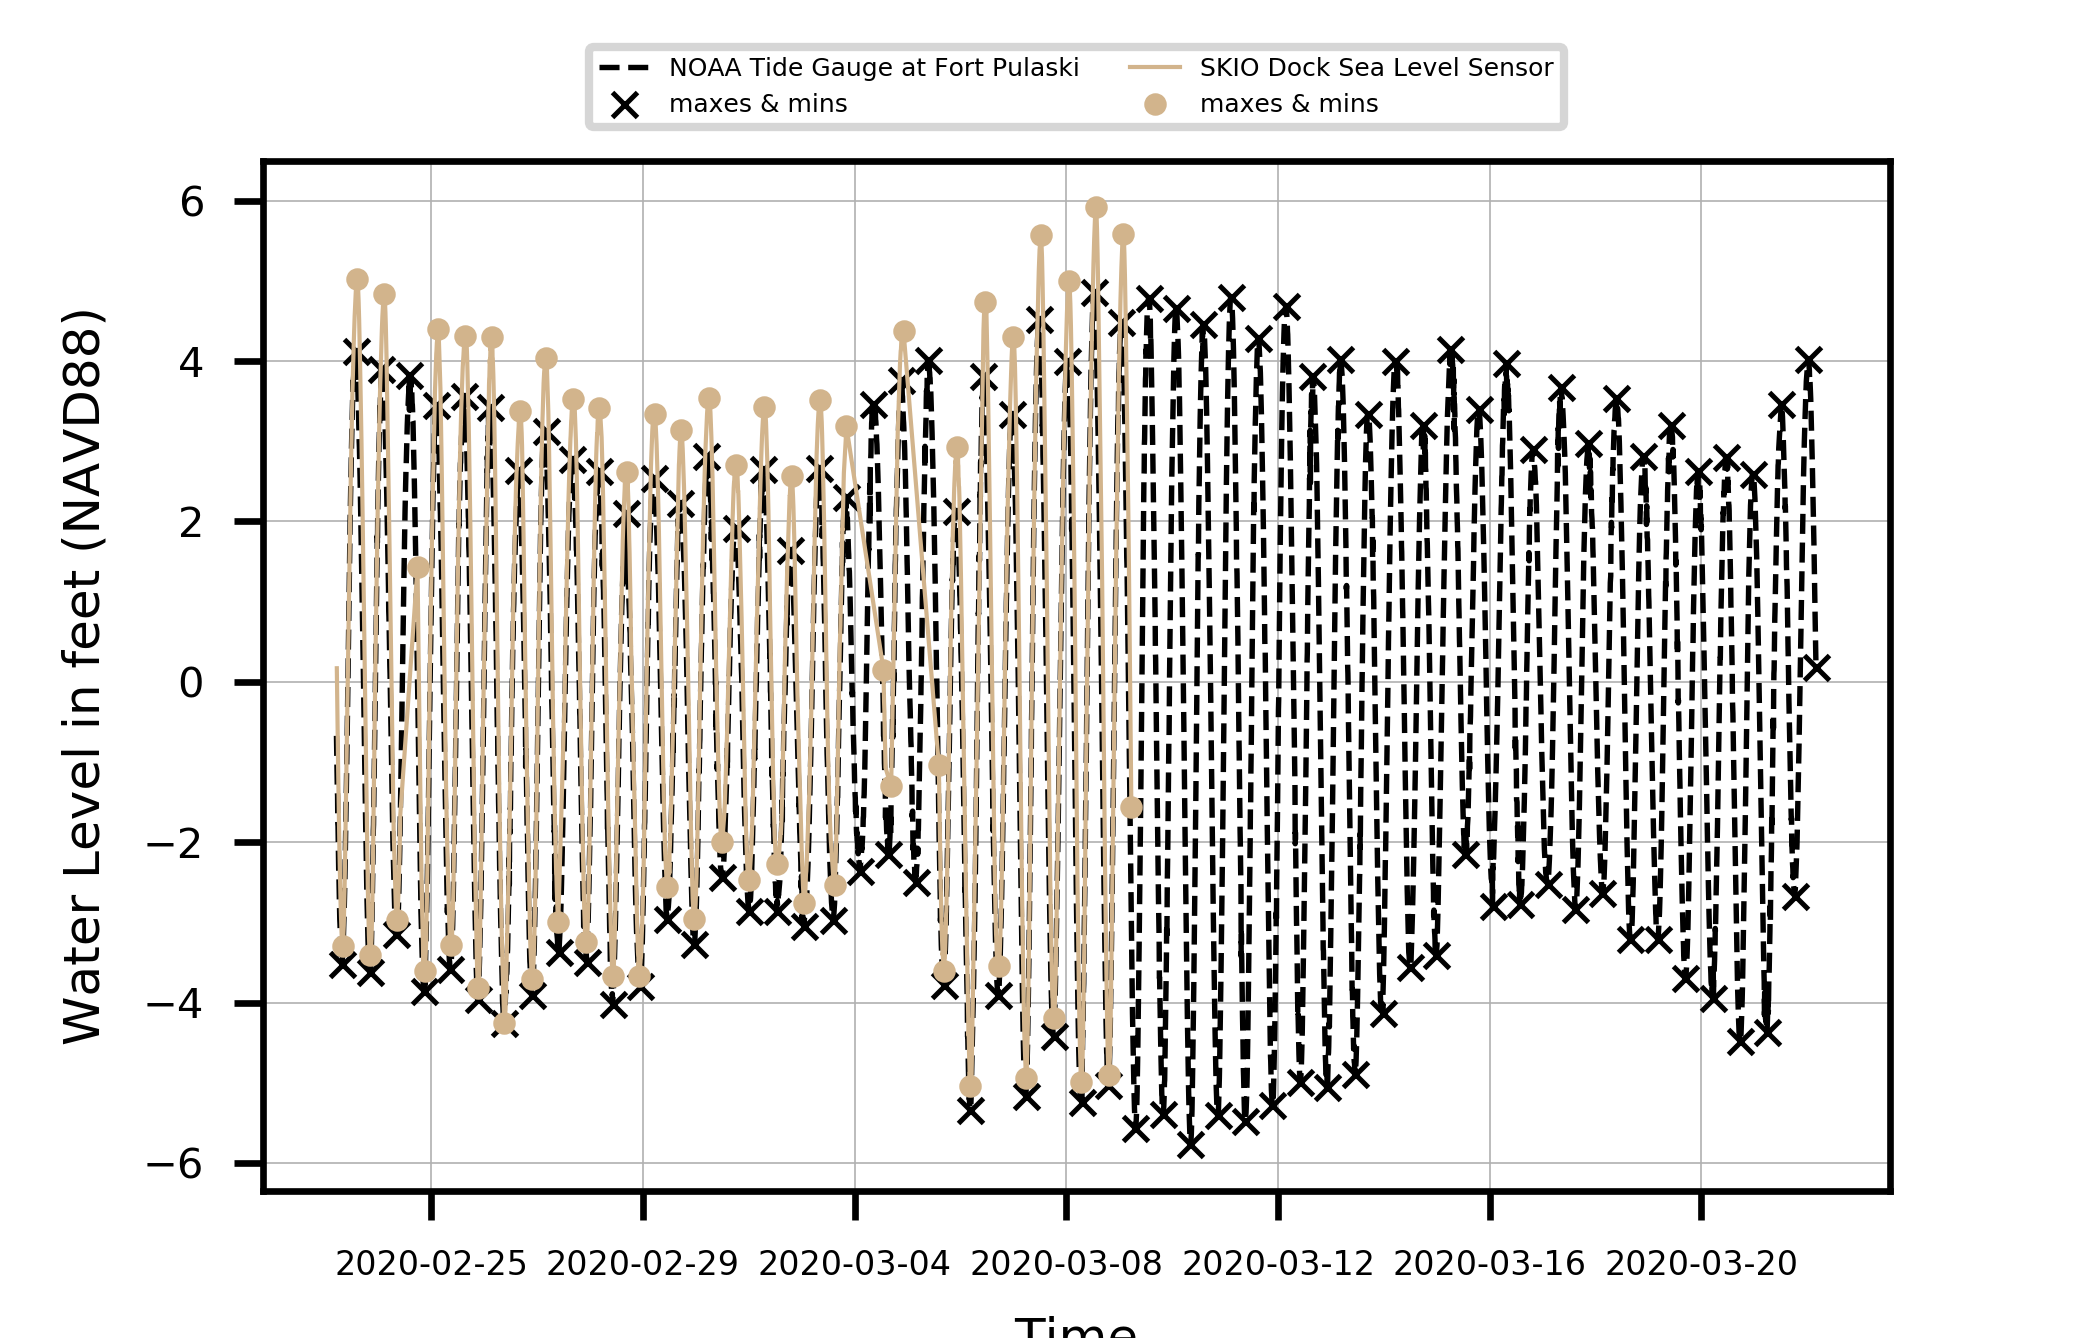

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] whic

In [22]:
%matplotlib notebook

# sensor index from above
num=12

# get sensor data for the specific sensor defined above
slsdata = get_sls_water_level_data(sensors_water.desc[num], spatial_start, spatial_end)

# nearest neighbor filtering for plotting
slsdata = slsdata[abs(slsdata['adj_value'] - slsdata['adj_value'].shift(1)) < 0.3] 
slsdata = slsdata[abs(slsdata['adj_value'] - slsdata['adj_value'].shift(-1)) < 0.3] 

# plot
fig = plt.figure(figsize=(3.5,2.23), dpi=300)
ax = fig.add_subplot(1,1,1)
plt.ylabel('Water Level in feet (NAVD88)', fontsize=6, labelpad=4 )
plt.xlabel('Time', fontsize=6, labelpad=4)
plt.tick_params(axis='x', labelsize=4)
plt.tick_params(axis='y', labelsize=5)
plt.grid( linewidth=0.2)

# plot alongside NOAA data with maxes and mins
plt.plot(ftp_data['timestamp'], ftp_data['adj_value'], label='NOAA Tide Gauge at Fort Pulaski', color="black", linestyle='dashed',linewidth=0.65)
plt.plot(max_times_NOAA, maxes_NOAA,label='maxes & mins', linestyle='None', color='black',marker='x', ls='', ms='3', mew='0.6')
plt.plot(min_times_NOAA, mins_NOAA, linestyle='None', color='black',marker='x', ls='', ms='3', mew='0.6')

plt.plot(slsdata['timestamp'], slsdata['adj_value'], label=sensors_water.desc[num], color="tan", linewidth=0.5)
plt.plot(spatial_data_sls_maxes.max_times[spatial_data_sls_maxes.max_sensor_name==sensors_water.desc[num]], spatial_data_sls_maxes.maxes[spatial_data_sls_maxes.max_sensor_name==sensors_water.desc[num]], label='maxes & mins', color="tan",marker='o',markersize=2, linestyle='None', ls='', mew='0.7')
plt.plot(spatial_data_sls_mins.min_times[spatial_data_sls_mins.min_sensor_name==sensors_water.desc[num]], spatial_data_sls_mins.mins[spatial_data_sls_mins.min_sensor_name==sensors_water.desc[num]],linestyle='None', color="tan", marker='o',markersize=2,ls='', mew='0.7')
# plt.plot(xp, yp, 'b.-', label='Fort Pulaski Tide Gauge', linewidth=0.4, markersize=0.1)

# fig.legend( loc='upper center',  borderaxespad=0.4, fancybox=True, shadow=False, ncol=2, fontsize = 4)
plt.legend(fontsize=3, bbox_to_anchor=(0,1.02,1,0.2), loc='lower center', ncol=2)

ax.xaxis.set_major_locator(pldates.DayLocator(interval=4)) 

# fig.tight_layout()
# fig.patch.set_facecolor('white')

# plt.savefig('./sensorTimeSeries/Diamond.jpg', bbox_inches='tight',dpi=1200)#, bbox_extra_artist=[fig.legend])


### fine tuning for some sensors ***DEPENDENT ON TIME PERIOD SELECTION

In [67]:
# replacing an incorrect NaN value
ins0 = spatial_data_sls_maxes.iloc[601]
# ins0.index = [600]
# ins0

ins1 = spatial_data_sls_maxes.iloc[601]
ins1.max_times = ins1.max_times+timedelta(hours=(12.5))
# ins1.index = [601]
ins1.maxes = 4.26
# ins1

ins2 = spatial_data_sls_maxes.iloc[601]
ins2.max_times = ins2.max_times+timedelta(hours=(24.5))
# ins2.index = [602]
ins2.maxes = 4.10
# ins2

spatial_data_sls_maxes.iloc[600]=ins0
spatial_data_sls_maxes.iloc[601]=ins1
spatial_data_sls_maxes.iloc[602]=ins2


# spatial_data_sls_maxes.iloc[599:]

# spatial_data_sls_mins[spatial_data_sls_mins.min_sensor_name=="Solomon Bridge Sea Level Sensor"]

solomon_drop = spatial_data_sls_maxes[(spatial_data_sls_maxes.max_times>'2020-03-11 12') & (spatial_data_sls_maxes.max_sensor_name=="Solomon Bridge Sea Level Sensor")].index.values
spatial_data_sls_maxes.drop(axis=0,index=solomon_drop, inplace=True)

solomon_drop = spatial_data_sls_mins[(spatial_data_sls_mins.min_times>'2020-03-11 12') & (spatial_data_sls_mins.min_sensor_name=="Solomon Bridge Sea Level Sensor")].index.values
spatial_data_sls_mins.drop(axis=0,index=solomon_drop, inplace=True)

spatial_data_sls_mins.iloc[490:499,0:2]=spatial_data_sls_mins.iloc[490:499,0:2].shift()
spatial_data_sls_mins.min_sensor_name[498]=spatial_data_sls_mins.iloc[497].min_sensor_name

# spatial_data_sls_mins.min_sensor_name[498]

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# save to csv file for quicker runtime in future
spatial_data_sls_mins.to_csv('./spatial_data_sls_mins.csv')
spatial_data_sls_maxes.to_csv('./spatial_data_sls_maxes.csv')

In [22]:
# read and format csv files to avoid running above code:
sdmin = pd.read_csv('spatial_data_sls_mins.csv')
sdmax = pd.read_csv('spatial_data_sls_maxes.csv')

spatial_data_sls_mins=sdmin.drop('Unnamed: 0',axis=1)
spatial_data_sls_maxes=sdmax.drop('Unnamed: 0',axis=1)

spatial_data_sls_maxes['maxtimes']=pd.to_datetime(spatial_data_sls_maxes['maxtimes'],infer_datetime_format=True,utc=True)#format='%Y-%m-%d %H:%M:%S')
spatial_data_sls_mins['mintimes']=pd.to_datetime(spatial_data_sls_mins['mintimes'],infer_datetime_format=True,utc=True)#format='%Y-%m-%d %H:%M:%S')

spatial_data_sls_mins['mintimes']=spatial_data_sls_mins['mintimes'].dt.tz_convert('America/New_York')
spatial_data_sls_maxes['maxtimes']=spatial_data_sls_maxes['maxtimes'].dt.tz_convert('America/New_York')

# verify the shape 
spatial_data_sls_maxes.shape, spatial_data_sls_mins.shape

### Compare Sea Level Sensors To NOAA Tide Gauge to understand regional variance

In [69]:
"""
calculating the mean and confidence interval of min/max water level differences and min/max time differences
these are the differences between a sensor and the NOAA tide gauge at fort pulaski to understand the local offset
NOAA Tide Gauge data and Sea Level Senosr data both must be analyzed with above code for the following part to function properly
"""

avg_min_diff = [] #average difference of mins
CI_min_diff = [] #confidence interval of the min differences
avg_min_time_diff = [] #average difference of min timestamps
CI_min_time_diff = [] #confidence interval of the min time differences
avg_min_sensor_name = [] #sensor name

# same for maxes:
avg_max_diff = []
CI_max_diff = []
avg_max_time_diff = []
CI_max_time_diff = []
avg_max_sensor_name = []

for index in sensors_water.index:
    
    min_diff = []
    min_time_diff = []

    # access the mins of the sensor currently under study
    indices = spatial_data_sls_mins[spatial_data_sls_mins.min_sensor_name==sensors_water.desc[index]].index
    
    # check if at least 17 mins were found in the previous analysis; otherwise too much data is missing for this sensor and it will be skipped
    if len(indices)>17:
        for i in range(len(indices)):
            if i >= len(min_times_NOAA):
                break
            else:
                min_time_diff.append(min_times_NOAA[i] - 
                            spatial_data_sls_mins[spatial_data_sls_mins.min_sensor_name==sensors_water.desc[index]].min_times[indices[i]])
                min_diff.append(-(mins_NOAA[i] - 
                            spatial_data_sls_mins[spatial_data_sls_mins.min_sensor_name==sensors_water.desc[index]].mins[indices[i]]))

        # calculating the mean time difference "by hand"
        total_time_diff = timedelta(hours=0)
        min_time_diff_sec = []
        for i in range(len(min_time_diff)):
            if not pd.isnull(min_time_diff[i]):
                total_time_diff+=min_time_diff[i]
                min_time_diff_sec.append(min_time_diff[i].total_seconds())
        avg_min_time_diff.append(total_time_diff/len(min_time_diff_sec))
        # 68% confidence interval for min time difference --> critical value t = 1.0
        CI_min_time_diff.append((1.0*statistics.stdev(min_time_diff_sec)/np.sqrt(len(min_time_diff_sec)))/60)

        # calculating the mean water level difference
        min_diff = np.array(min_diff)
        min_diff = min_diff[~np.isnan(min_diff)]
        avg_min_diff.append(mean(min_diff))
        # 68% confidence interval for min difference --> critical value t = 1.0
        CI_min_diff.append((1.0*statistics.stdev(min_diff)/np.sqrt(len(min_diff))))

        avg_min_sensor_name.append(sensors_water.desc[index])
        
        
    max_diff = []
    max_time_diff = []

    # access the maxes of the sensor currently under study
    indices = spatial_data_sls_maxes[spatial_data_sls_maxes.max_sensor_name==sensors_water.desc[index]].index
    
    # check if at least 17 mins were found in the previous analysis; otherwise too much data is missing for this sensor and it will be skipped
    if len(indices)>17:
        for i in range(len(indices)):
            if i >= len(max_times_NOAA):
                break
            else:
                max_time_diff.append(max_times_NOAA[i] - 
                            spatial_data_sls_maxes[spatial_data_sls_maxes.max_sensor_name==sensors_water.desc[index]].max_times[indices[i]])
                max_diff.append(-(maxes_NOAA[i] - 
                            spatial_data_sls_maxes[spatial_data_sls_maxes.max_sensor_name==sensors_water.desc[index]].maxes[indices[i]]))

        # calculating the mean time difference "by hand"
        total_time_diff = timedelta(hours=0)
        max_time_diff_sec = []
        for i in range(len(max_time_diff)):
            if not pd.isnull(max_time_diff[i]):
                total_time_diff+=max_time_diff[i]
                max_time_diff_sec.append(max_time_diff[i].total_seconds())
        avg_max_time_diff.append(total_time_diff/len(max_time_diff_sec)) 
        # 68% confidence interval for max time difference --> critical value t = 1.0
        CI_max_time_diff.append((1.0*statistics.stdev(max_time_diff_sec)/np.sqrt(len(max_time_diff_sec)))/60)

        # calculating the mean water level difference
        max_diff = np.array(max_diff)
        max_diff = max_diff[~np.isnan(max_diff)]
        avg_max_diff.append(mean(max_diff))
        # 68% confidence interval for max difference--> critical value t = 1.0
        CI_max_diff.append(1.0*statistics.stdev(max_diff)/np.sqrt(len(max_diff)))

        avg_max_sensor_name.append(sensors_water.desc[index])

avg_min_data = {'sensor_name':avg_min_sensor_name, 'avg_min_diff_(ft)':avg_min_diff, 'min_diff_CI_(ft)':CI_min_diff, 'avg_min_time_diff':avg_min_time_diff, 'min_time_time_diff_CI':CI_min_time_diff}
min_diff_data = pd.DataFrame(avg_min_data)

avg_max_data = {'sensor_name':avg_max_sensor_name, 'avg_max_diff_(ft)':avg_max_diff, 'max_diff_CI_(ft)':CI_max_diff, 'avg_max_time_diff':avg_max_time_diff, 'max_time_diff_CI':CI_max_time_diff}
max_diff_data = pd.DataFrame(avg_max_data)

"""
NOTE: with both max_diff and min_diff 
negative value means the sensor is reporting a value that's physically below the value that the Fort Pulaski Tide Gauge is reporting. 
meaning the water level at the sensor is lower than the water level at Fort Pulaski.
positive value means the sensor is reporting a value that's physically above the value that Fort Pulaski Tide Gauge is reporting. 
meaning the water level at the sensor is higher than the water level at Fort Pulaski.
"""

# create string out of time difference data to properly format data label for the plots

str_avg_min_time_diff=[]
for index in min_diff_data.index:
    if(min_diff_data.avg_min_time_diff[index]<pd.Timedelta('0 hours')):
        if(abs(min_diff_data.avg_min_time_diff[index])<pd.Timedelta('1 hours')):
            str_avg_min_time_diff.append('+'+str(abs(min_diff_data.avg_min_time_diff[index]))[10:12])
        else:
            str_avg_min_time_diff.append('+'+str(abs(min_diff_data.avg_min_time_diff[index]))[7:9]+'hr'+str(abs(min_diff_data.avg_min_time_diff[index]))[10:12]+'min')
    else:
        if(abs(min_diff_data.avg_min_time_diff[index])<pd.Timedelta('1 hours')):
            str_avg_min_time_diff.append('-'+str(abs(min_diff_data.avg_min_time_diff[index]))[10:12])
        else:
            str_avg_min_time_diff.append('-'+str(abs(min_diff_data.avg_min_time_diff[index]))[7:9]+'hr'+str(abs(min_diff_data.avg_min_time_diff[index]))[10:12]+'min')
    
str_avg_max_time_diff=[]
for index in max_diff_data.index:
    if(max_diff_data.avg_max_time_diff[index]<pd.Timedelta('0 hours')):
        if(abs(max_diff_data.avg_max_time_diff[index])<pd.Timedelta('1 hours')):
            str_avg_max_time_diff.append('+'+str(abs(max_diff_data.avg_max_time_diff[index]))[10:12])
        else:
            str_avg_max_time_diff.append('+'+str(abs(max_diff_data.avg_max_time_diff[index]))[7:9]+'hr'+str(abs(max_diff_data.avg_max_time_diff[index]))[10:12]+'min')
    else:
        if(abs(max_diff_data.avg_max_time_diff[index])<pd.Timedelta('1 hours')):
            str_avg_max_time_diff.append('-'+str(abs(max_diff_data.avg_max_time_diff[index]))[10:12])
        else:
            str_avg_max_time_diff.append('-'+str(abs(max_diff_data.avg_max_time_diff[index]))[7:9]+'hr'+str(abs(max_diff_data.avg_max_time_diff[index]))[10:12]+'min')

min_diff_data['str_avg_min_time_diff']=str_avg_min_time_diff
max_diff_data['str_avg_max_time_diff']=str_avg_max_time_diff

# manual edits for data labels
max_diff_data[max_diff_data.sensor_name=='Rose Dhu Island Sea Level Sensor'].str_avg_max_time_diff=['+62']

/Users/akhil/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [20]:
# str_avg_min_time_diff=[]
# for index in min_diff_data.index:
#     if(min_diff_data.avg_min_time_diff[index]<pd.Timedelta('0 hours')):
#         if(abs(min_diff_data.avg_min_time_diff[index])<pd.Timedelta('1 hours')):
#             str_avg_min_time_diff.append('+'+str(abs(min_diff_data.avg_min_time_diff[index]))[10:12])
#         else:
#             str_avg_min_time_diff.append('+'+str(abs(min_diff_data.avg_min_time_diff[index]))[7:9]+'hr'+str(abs(min_diff_data.avg_min_time_diff[index]))[10:12]+'min')
#     else:
#         if(abs(min_diff_data.avg_min_time_diff[index])<pd.Timedelta('1 hours')):
#             str_avg_min_time_diff.append('-'+str(abs(min_diff_data.avg_min_time_diff[index]))[10:12])
#         else:
#             str_avg_min_time_diff.append('-'+str(abs(min_diff_data.avg_min_time_diff[index]))[7:9]+'hr'+str(abs(min_diff_data.avg_min_time_diff[index]))[10:12]+'min')
    
# str_avg_max_time_diff=[]
# for index in max_diff_data.index:
#     if(max_diff_data.avg_max_time_diff[index]<pd.Timedelta('0 hours')):
#         if(abs(max_diff_data.avg_max_time_diff[index])<pd.Timedelta('1 hours')):
#             str_avg_max_time_diff.append('+'+str(abs(max_diff_data.avg_max_time_diff[index]))[10:12])
#         else:
#             str_avg_max_time_diff.append('+'+str(abs(max_diff_data.avg_max_time_diff[index]))[7:9]+'hr'+str(abs(max_diff_data.avg_max_time_diff[index]))[10:12]+'min')
#     else:
#         if(abs(max_diff_data.avg_max_time_diff[index])<pd.Timedelta('1 hours')):
#             str_avg_max_time_diff.append('-'+str(abs(max_diff_data.avg_max_time_diff[index]))[10:12])
#         else:
#             str_avg_max_time_diff.append('-'+str(abs(max_diff_data.avg_max_time_diff[index]))[7:9]+'hr'+str(abs(max_diff_data.avg_max_time_diff[index]))[10:12]+'min')

In [70]:
min_diff_data

sensor_name  avg_min_diff_(ft)  \
0                Kilkenny Creek environmental sensors          -0.452781   
1           Coffee Bluff Marina environmental sensors          -0.999932   
2           Oatland Island Road environmental sensors          -1.031907   
3               Hwy 17 at Salt Creek Sea Level Sensor           0.546722   
4                     Catalina Drive Sea Level Sensor          -1.097945   
5                   Fort Pulaski (A) Sea Level Sensor           0.085135   
6             Turner Creek Boat Ramp Sea Level Sensor           1.065010   
7                   Fort Pulaski (B) Sea Level Sensor           0.081744   
8             Landings Harbor Marina Sea Level Sensor          -0.190778   
9                          SKIO Dock Sea Level Sensor           0.358475   
10     Hunt Drive on Burnside Island Sea Level Sensor          -0.078449   
11          Sapelo Island Ferry Dock Sea Level Sensor          -4.449516   
12                    Savannah State Sea Level Sensor          -0.250313   
13  Diamond Causeway at Shipyard Creek Sea Level S...          -0.520668   
14                   Rose Dhu Island Sea Level Sensor           1.757897   
15          Hwy 21 at St Augustine Creek Level Sensor           2.940250   
16                    Solomon Bridge Sea Level Sensor          -0.550740   
17  Dean Forest Road at Harden Canal Sea Level Sensor           3.476187   
18      Lazaretto Creek Fishing Pier Sea Level Sensor          -0.428561   
19                   Sullivan Street Sea Level Sensor           1.653979   
20  LaRoche Avenue at Nottingham Creek Sea Level S...           1.369486   
21  Hwy 80 at Chimney Creek on Tybee Island Sea Le...           0.527463   
22     Faye Drive on Burnside Island Sea Level Sensor          -0.416034   
23              Delegal Creek Marina Sea Level Sensor          -2.721622   
24            Bull River Marina environmental sensors           0.131953   

    min_diff_CI_(ft)        avg_min_time_diff  min_time_time_diff_CI  \
0           0.030946 -1 days +23:34:40.006290               2.287443   
1           0.055593 -1 days +23:10:18.382090               2.927623   
2           0.045595 -1 days +23:35:00.384000               3.335599   
3           0.168244 -1 days +22:19:52.048471               8.531169   
4           0.011762 -1 days +23:48:59.395472               2.723951   
5           0.007452          00:01:47.889277               2.115850   
6           0.136431 -1 days +23:56:02.922636               8.679208   
7           0.011003          00:00:31.380454               1.856210   
8           0.016718 -1 days +23:58:26.780490               2.447156   
9           0.105588          03:02:52.041074              64.746468   
10          0.027485 -1 days +23:32:51.730054               2.758624   
11          0.023544 -1 days +23:43:42.563945               2.244377   
12          0.168597 -1 days +23:47:06.875327               6.485544   
13          0.031917 -1 days +23:31:03.051109               3.185480   
14          0.133584 -1 days +22:13:03.246945               7.727105   
15          0.268254 -1 days +21:45:29.986400               5.814419   
16          0.029624 -1 days +23:44:44.569531               3.434489   
17          0.209951 -1 days +21:18:28.479200               7.169309   
18          0.008986 -1 days +23:58:35.324618               1.355737   
19          0.136844          00:05:16.204509              10.442792   
20          0.158734          00:01:18.159672               8.653243   
21          0.114228 -1 days +23:00:22.445036               6.550224   
22          0.027762 -1 days +23:32:39.188854               2.787950   
23          0.017254 -1 days +23:49:34.581672               2.107423   
24          0.076394 -1 days +23:45:01.431400               3.967805   

   str_avg_min_time_diff  
0                    +25  
1                    +49  
2                    +24  
3             +01hr40min  
4                    +11  
5                    -01  
6  

In [71]:
max_diff_data

sensor_name  avg_max_diff_(ft)  \
0                Kilkenny Creek environmental sensors          -0.193313   
1           Coffee Bluff Marina environmental sensors          -1.037563   
2           Oatland Island Road environmental sensors          -0.362284   
3               Hwy 17 at Salt Creek Sea Level Sensor           0.193443   
4                     Catalina Drive Sea Level Sensor          -1.304053   
5                   Fort Pulaski (A) Sea Level Sensor           0.338811   
6             Turner Creek Boat Ramp Sea Level Sensor           0.138919   
7                   Fort Pulaski (B) Sea Level Sensor           0.002850   
8             Landings Harbor Marina Sea Level Sensor          -0.123257   
9                          SKIO Dock Sea Level Sensor           0.395407   
10     Hunt Drive on Burnside Island Sea Level Sensor           0.365247   
11          Sapelo Island Ferry Dock Sea Level Sensor          -4.604313   
12                    Savannah State Sea Level Sensor           0.562495   
13  Diamond Causeway at Shipyard Creek Sea Level S...           0.115101   
14                   Rose Dhu Island Sea Level Sensor          -0.450324   
15          Hwy 21 at St Augustine Creek Level Sensor           0.587991   
16                    Solomon Bridge Sea Level Sensor           0.313479   
17  Dean Forest Road at Harden Canal Sea Level Sensor          -0.011643   
18      Lazaretto Creek Fishing Pier Sea Level Sensor          -0.598091   
19                   Sullivan Street Sea Level Sensor           0.131142   
20  LaRoche Avenue at Nottingham Creek Sea Level S...           0.423758   
21  Hwy 80 at Chimney Creek on Tybee Island Sea Le...          -0.416178   
22     Faye Drive on Burnside Island Sea Level Sensor           0.053674   
23              Delegal Creek Marina Sea Level Sensor          -2.689060   
24            Bull River Marina environmental sensors           0.160610   

    max_diff_CI_(ft)        avg_max_time_diff  max_time_diff_CI  \
0           0.035472 -1 days +23:12:18.516000          4.682574   
1           0.018699 -1 days +23:09:48.796574          3.270820   
2           0.018972 -1 days +23:03:48.321981          3.204490   
3           0.048752 -1 days +21:19:09.210923          5.949152   
4           0.011661 -1 days +23:43:01.678537          2.355917   
5           0.401569          00:05:41.264444          6.707908   
6           0.016502 -1 days +23:16:54.038500          2.647454   
7           0.007351 -1 days +23:57:42.378425          2.359440   
8           0.023524 -1 days +23:38:53.164462          3.260424   
9           0.265227 -1 days +23:00:01.559551         14.084633   
10          0.014626 -1 days +23:22:50.089203          2.453151   
11          0.015671 -1 days +23:34:39.323629          2.815491   
12          0.169247 -1 days +22:23:41.640444         24.632387   
13          0.017289 -1 days +23:14:35.727925          2.604277   
14          0.036044 -1 days +22:57:57.083537          4.685298   
15          0.039817 -1 days +21:54:48.024962          4.415494   
16          0.031314 -1 days +23:05:42.957750          4.688271   
17          0.057146 -1 days +20:50:04.446166          6.528394   
18          0.011600 -1 days +23:52:52.011240          2.839360   
19          0.013918 -1 days +23:24:01.979777          2.465256   
20          0.023205 -1 days +23:05:16.291444          3.286742   
21          0.010721 -1 days +23:31:59.622888          2.132809   
22          0.014661 -1 days +23:21:40.802388          2.587555   
23          0.011317 -1 days +23:36:18.754462          2.460855   
24          0.014396 -1 days +23:21:15.064888          2.673876   

   str_avg_max_time_diff  
0                    +47  
1                    +50  
2                    +56  
3             +02hr40min  
4                    +16  
5                    -05  
6                    +43  
7                    +02  
8                    +21  
9                    +59  
10                   +37 

In [ ]:
# drop sensors with low data quality values - dependent on time series
# max_diff_data.drop([9], inplace=True)
# min_diff_data.drop([9,20], inplace=True)

In [ ]:
# data_quality.drop([0,23,26],inplace=True)

## Spatial Plots

### Only sensors with updated elevation surveys will be displayed on Water Level difference plots

In [72]:
# display only sensors with updated elevation surveys
surveyed_sensors = pd.read_excel('SensorInstallationDetails.xlsx')
ss_splitNames=pd.DataFrame(surveyed_sensors[~np.isnan(surveyed_sensors['Survey top of box (feet)'])]['Location'].apply(lambda x: x.split()[0:2]))
# ss_splitNames

### Get LoRa Gateways

In [73]:
# read in gateway details 
gateways = pd.read_excel('GatewayInstallationDetails.xlsx')
coords = []
for index in gateways.index:
    c = [gateways.Longitude[index], gateways.Latitude[index]]
    coords.append(c)
gateways['coords'] = coords
gateways.drop([16,17,18,19,20,21],axis=0,inplace=True)

### Plot: Sensors and Gateways

In [84]:
# style the legend for the spatial plots since matplotlib isn't used

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:18px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#bf2a43;opacity:1;'></span>Gateway</li>
    <li><span style='background:#070f87;opacity:1;'></span>Sensor</li>
    <li><span style='border-width:3px;border-style:solid;border-color:black;'></span>NOAA Tide Gauge</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [85]:
# plot the network of Smart Sea Level Sensors and LoRa Gateways 

# create map using Folium and openstreetmap base layer
mapa = folium.Map(location=[32.03,-81.04], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True,
                      zoom_control=False
    )

# add gateways
fg_gat = folium.FeatureGroup(name='gateways')

for cg in gateways.coords:

    # initialize marker
    gatcirmarker = folium.RegularPolygonMarker(
        location=[cg[1],cg[0]],
        radius=6,
        color='#a80707',#bf2a43',#e02264',
        weight=17,
        fill_color='#a80707', 
        fill_opacity=0.8,
        rotation=90,
        
    )

    # add marker&annotations to respective feature groups
    fg_gat.add_child(gatcirmarker)

# add feature groups to map
mapa.add_child(fg_gat)    


# add Fort Pulaski location to map
ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski</span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.014, ftp_coord[0]+0.017], draggable=False, icon=icon)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)


# add sea level sensors to map
fg_sen = folium.FeatureGroup(name='sensors')

for c in sensors_water.coords:

    # initialize marker
    sencirmarker = folium.CircleMarker(
        location=[c[1],c[0]],
        radius=9,
        color='#070f87',#'#0F2080',
        weight=1.5,
        fill=True,
        fill_color='#070f87', 
        fill_opacity=1
    )

    # add marker&annotations to respective feature groups
    fg_sen.add_child(sencirmarker)

# add feature groups to map
mapa.add_child(fg_sen)

macro = MacroElement()
macro._template = Template(template)

mapa.get_root().add_child(macro)

# mapa.save("../PaperPlots/sensors&gateways_ChathamCounty.html")

mapa


### Plot: Relevant Sensors - Numbered

In [91]:
# style the legend

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:18px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#070f87;opacity:1;'></span>Smart Sea Level Sensor</li>
    <li><span style='background:#DAB371;opacity:1;'></span>Tide Chart</li>
    <li><span style='background:#B35AB3;opacity:1;'></span>USGS Rain Sensor</li>
    <li><span style='border-width:3px;border-style:solid;border-color:black;'></span>NOAA Tide Gauge, Rain Sensor, Wind Sensor</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [92]:
# plot the all the relevant sensors that are discussed

# create map using Folium and openstreetmap base layer
mapa = folium.Map(location=[32.03,-81.12], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )


# add Fort Pulaski location to map
ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski</span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.014, ftp_coord[0]+0.017], draggable=False, icon=icon)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)


# tidal forecast sites 
tc_lats=[31.980124,32.003985,31.926280,31.935877]
tc_longs=[-81.056468,-81.001557,-81.101655,-81.154304]
tc_lows=[28,6,31,42]

fg_tc = folium.FeatureGroup(name='tidecharts')

for i in range(len(tc_lats)):

    # initialize marker
    tcmarker = folium.CircleMarker(
        location=[tc_lats[i],tc_longs[i]],
        radius=13,
        color='#000000',#'#0F2080',
        weight=3,
        fill=True,
        fill_color='#DAB371',#D2B989', 
        fill_opacity=1
    )
#     icon = folium.features.DivIcon(html=f"""
#             <span style="font-size:14pt;font-weight: bold; font-style: italic;">+{tc_lows[i]}</span>
#             """,)
#     if i==1:
#         tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.007], draggable=False, icon=icon) 
#     else:
#         tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.01], draggable=False, icon=icon) 

#     # add marker&annotations to respective feature groups
    fg_tc.add_child(tcmarker)
#     fg_tc.add_child(tcann)  
    
# add feature groups to map
mapa.add_child(fg_tc)


# add USGS rain sensors to map

# # initialize marker
# gatcirmarker = folium.RegularPolygonMarker(
#     location=[32.033889,-80.903333],
#     radius=5,
#     color='#DC701A',#e02264',
#     weight=12,
#     fill_color='#DC701A', 
#     fill_opacity=0.8,
#     rotation=90,
# ).add_to(mapa)

# initialize marker
gatcirmarker = folium.RegularPolygonMarker(
    location=[32.165333,-81.154917],
    radius=5,
    color='#B35AB3',#A364C3,#AF57AC',#04C58B',#00A79A',#018A7F',#999AE4',#F77B74',#DE4141',#'#E69F00',#e02264',
    weight=12,
    fill_color='#B35AB3', 
    fill_opacity=1,
    rotation=90,
).add_to(mapa)

# initialize marker
gatcirmarker = folium.RegularPolygonMarker(
    location=[32.079500,-81.384750],
    radius=5,
    color='#B35AB3',
    weight=12,
    fill_color='#B35AB3', 
    fill_opacity=1,
    rotation=90,
).add_to(mapa)


# add sea level sensors to map 
fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

j=1

for index in sensors_water.index:

    c = sensors_water.coords[index]
    
    idx = []
    for i in range(len(ss_splitNames)):
        idx.append(sensors_water.desc[index].split()[0:2]==ss_splitNames['Location'][ss_splitNames.index[i]])
    
    if max_diff_data[sensors_water.desc[index]==max_diff_data.sensor_name].size>0:
          # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
        
        # initialize annotation for marker; #font-family="Roboto Condensed"
        icon = folium.features.DivIcon(html=f"""
            <span style="font-size:14pt;font-weight: bold; ">{j}</span>
            """,)
        
                
        # upper left
        if sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.0055,c[0]-0.015], draggable=False, icon=icon)
            j=j+1
#           add annotation to feature group
            fg_ann.add_child(annmarker)

            
        # center left
        elif  sensors_water.desc[index]=='Hwy 80 at Chimney Creek on Tybee Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.0055,c[0]-0.012], draggable=False, icon=icon)
            j=j+1
#           add annotation to feature group
            fg_ann.add_child(annmarker)
        
        # center left
        elif sensors_water.desc[index]=='Bull River Marina environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.0055,c[0]-0.012], draggable=False, icon=icon)
            j=j+1
#           add annotation to feature group
            fg_ann.add_child(annmarker)
        
        # center left
        elif sensors_water.desc[index]=='Diamond Causeway at Shipyard Creek Sea Level Sensor': 
            annmarker = folium.Marker(location=[c[1]+0.0055,c[0]-0.012], draggable=False, icon=icon)
            j=j+1
#           add annotation to feature group
            fg_ann.add_child(annmarker)
        
        # center left
        elif sensors_water.desc[index]=='Dean Forest Road at Harden Canal Sea Level Sensor': 
            annmarker = folium.Marker(location=[c[1]+0.0055,c[0]-0.012], draggable=False, icon=icon)
            j=j+1
#           add annotation to feature group
            fg_ann.add_child(annmarker)
    
        # center left
        elif sensors_water.desc[index]=='Hwy 21 at St Augustine Creek Level Sensor': 
            annmarker = folium.Marker(location=[c[1]+0.0055,c[0]-0.012], draggable=False, icon=icon)
            j=j+1
#           add annotation to feature group
            fg_ann.add_child(annmarker)
        
#         else:
#             annmarker = ''
            

        # add marker feature group
        fg_sen.add_child(sencirmarker)

    else:
        print(sensors_water.desc[index])        

# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

folium.map.Marker(
    [31.84,-80.85],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in decimal feet</div>'
        )
    ).add_to(mapa)

macro = MacroElement()
macro._template = Template(template)

mapa.get_root().add_child(macro)

# mapa.save("../PaperPlots/crestdiffWL.html")
mapa





Walthour Road environmental sensors
Skidaway Dock environmental sensors
Catalina Drive environmental sensors
Calibration test unit 031
Hutchinson Island environmental sensors
Shipyard Road Sea Level Sensor
Skidaway Road at Herb River Sea Level Sensor
Houlihan Boat Ramp Sea Level Sensor
Wilmington Park Canal Sea Level Sensor
Hwy 80 at Grays Creek Sea Level Sensor
Calibration test unit 021
Calibration test unit 019
North Church Street at North Buffalo Creek Water Level Sensor


### Plot: Sensors and Trough (minimum) difference with FTP (NOAA Fort Pulaski Tide Gauge) 

In [93]:
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski</span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.014, ftp_coord[0]+0.017], draggable=False, icon=icon)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)

genCI_low = round(min_diff_data['min_diff_CI_(ft)'].mean()-
      1.0*statistics.stdev(min_diff_data['min_diff_CI_(ft)'])/np.sqrt(len(min_diff_data['min_diff_CI_(ft)'])),2)
genCI_hi = round(min_diff_data['min_diff_CI_(ft)'].mean()+
      1.0*statistics.stdev(min_diff_data['min_diff_CI_(ft)'])/np.sqrt(len(min_diff_data['min_diff_CI_(ft)'])),2)
fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

for index in sensors_water.index:
    
    idx = []
    for i in range(len(ss_splitNames)):
        idx.append(sensors_water.desc[index].split()[0:2]==ss_splitNames['Location'][ss_splitNames.index[i]])
    
    if min_diff_data[sensors_water.desc[index]==min_diff_data.sensor_name].size>0 and ss_splitNames[idx].size>0:
        c = sensors_water.coords[index]
        
        # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
            
        val = round(min_diff_data[sensors_water.desc[index]==min_diff_data.sensor_name]['avg_min_diff_(ft)'].values[0],2)
        ci = round(min_diff_data[sensors_water.desc[index]==min_diff_data.sensor_name]['min_diff_CI_(ft)'].values[0],2)
       
        # initialize annotation for marker; #font-family="Roboto Condensed"
        if val>=0:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">+{val}</span><span style="font-size:10pt;font-weight: bold;">&nbsp;&#177;&nbsp;{ci}</span>
                """,)
        else:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val}</span><span style="font-size:10pt;font-weight: bold;">&nbsp;&#177;&nbsp;{ci}</span>
                """,)
        
        # center left
        if sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors' or sensors_water.desc[index]=='Oatland Island Road environmental sensors' or sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.066], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor' or sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors' or sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.015,c[0]-0.06], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.019,c[0]-0.051], draggable=False, icon=icon)
            
         # center left
        elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.065], draggable=False, icon=icon)
        
#         # on top left
#         elif :
#             annmarker = folium.Marker(location=[c[1]+0.017,c[0]-0.05], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Sullivan Street Sea Level Sensor' or sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0034,c[0]-0.055], draggable=False, icon=icon) 
            
        # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.007,c[0]-0.051], draggable=False, icon=icon) 
        
        # under left
        elif sensors_water.desc[index]=='Hunt Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0042,c[0]-0.05], draggable=False, icon=icon) 
        
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0046,c[0]+0.013], draggable=False, icon=icon)
        
        # leave out sensors that bottom out in river beds
        if val<1:
            # add annotation to feature group
            fg_ann.add_child(annmarker)

            # add marker feature group
            fg_sen.add_child(sencirmarker)
    
    else:
        print(sensors_water.desc[index])
        
    

# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

# folium.map.Marker(
#     [31.84,-80.85],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in decimal feet</div>'
#         )
#     ).add_to(mapa)

mapa




Walthour Road environmental sensors
Kilkenny Creek environmental sensors
Coffee Bluff Marina environmental sensors
Skidaway Dock environmental sensors
Catalina Drive environmental sensors
Oatland Island Road environmental sensors
Hwy 17 at Salt Creek Sea Level Sensor
Catalina Drive Sea Level Sensor
Landings Harbor Marina Sea Level Sensor
SKIO Dock Sea Level Sensor
Calibration test unit 031
Hunt Drive on Burnside Island Sea Level Sensor
Sapelo Island Ferry Dock Sea Level Sensor
Savannah State Sea Level Sensor
Hutchinson Island environmental sensors
Shipyard Road Sea Level Sensor
Skidaway Road at Herb River Sea Level Sensor
Houlihan Boat Ramp Sea Level Sensor
Wilmington Park Canal Sea Level Sensor
Hwy 80 at Grays Creek Sea Level Sensor
Calibration test unit 021
Delegal Creek Marina Sea Level Sensor
Calibration test unit 019
North Church Street at North Buffalo Creek Water Level Sensor


### Plot: Sensors and Crest (maximum) difference with FTP

In [94]:
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski</span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.014, ftp_coord[0]+0.017], draggable=False, icon=icon)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)


fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

genCI_low = round(max_diff_data['max_diff_CI_(ft)'].mean()-
      1.0*statistics.stdev(max_diff_data['max_diff_CI_(ft)'])/np.sqrt(len(max_diff_data['max_diff_CI_(ft)'])),2)
genCI_hi = round(max_diff_data['max_diff_CI_(ft)'].mean()+
      1.0*statistics.stdev(max_diff_data['max_diff_CI_(ft)'])/np.sqrt(len(max_diff_data['max_diff_CI_(ft)'])),2)

for index in sensors_water.index:

    c = sensors_water.coords[index]
    
    idx = []
    for i in range(len(ss_splitNames)):
        idx.append(sensors_water.desc[index].split()[0:2]==ss_splitNames['Location'][ss_splitNames.index[i]])
    
    if max_diff_data[sensors_water.desc[index]==max_diff_data.sensor_name].size>0 and ss_splitNames[idx].size>0:
          # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
        
        val = round(max_diff_data[sensors_water.desc[index]==max_diff_data.sensor_name]['avg_max_diff_(ft)'].values[0],2)
        ci = round(max_diff_data[sensors_water.desc[index]==max_diff_data.sensor_name]['max_diff_CI_(ft)'].values[0],2)
        # initialize annotation for marker; #font-family="Roboto Condensed"
        if val>=0:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">+{val}</span><span style="font-size:10pt;font-weight: bold;">&nbsp;&#177;&nbsp;{ci}</span>
                """,)
        else:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val}</span><span style="font-size:10pt;font-weight: bold;">&nbsp;&#177;&nbsp;{ci}</span>
                """,)
        
        # center left
        if sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors' or sensors_water.desc[index]=='Oatland Island Road environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.067], draggable=False, icon=icon)
            
        # center left
        elif  sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.063], draggable=False, icon=icon)
        
        # upper left
        elif sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors' or sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.015,c[0]-0.06], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.065], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.019,c[0]-0.046], draggable=False, icon=icon) 
        
#         # on top left
#         elif :
#             annmarker = folium.Marker(location=[c[1]+0.017,c[0]-0.05], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.0033,c[0]-0.052], draggable=False, icon=icon) 
        
        # upper
        elif sensors_water.desc[index]=='Sullivan Street Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.014,c[0]-0.0], draggable=False, icon=icon) 
            
        # lower left
        elif sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0035,c[0]-0.046], draggable=False, icon=icon) 
            
        # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.007,c[0]-0.048], draggable=False, icon=icon) 
        
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0046,c[0]+0.013], draggable=False, icon=icon)
    
        # add annotation to feature group
        fg_ann.add_child(annmarker)

        # add marker feature group
        fg_sen.add_child(sencirmarker)

    else:
        print(sensors_water.desc[index])        

# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

# folium.map.Marker(
#     [31.84,-80.85],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in decimal feet</div>'
#         )
#     ).add_to(mapa)

# mapa.save("../PaperPlots/crestdiffWL.html")
mapa





Walthour Road environmental sensors
Kilkenny Creek environmental sensors
Coffee Bluff Marina environmental sensors
Skidaway Dock environmental sensors
Catalina Drive environmental sensors
Oatland Island Road environmental sensors
Hwy 17 at Salt Creek Sea Level Sensor
Catalina Drive Sea Level Sensor
Landings Harbor Marina Sea Level Sensor
SKIO Dock Sea Level Sensor
Calibration test unit 031
Hunt Drive on Burnside Island Sea Level Sensor
Sapelo Island Ferry Dock Sea Level Sensor
Savannah State Sea Level Sensor
Hutchinson Island environmental sensors
Shipyard Road Sea Level Sensor
Skidaway Road at Herb River Sea Level Sensor
Houlihan Boat Ramp Sea Level Sensor
Wilmington Park Canal Sea Level Sensor
Hwy 80 at Grays Creek Sea Level Sensor
Calibration test unit 021
Delegal Creek Marina Sea Level Sensor
Calibration test unit 019
North Church Street at North Buffalo Creek Water Level Sensor


### Plot: Sensors and Trough Time difference with FTP

In [98]:
# style the legend

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:18px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#070f87;opacity:1;'></span>Smart Sea Level Sensor</li>
    <li><span style='background:#DAB371;opacity:1;'></span>Tide Chart</li>
    
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [99]:
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski</span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.014, ftp_coord[0]+0.017], draggable=False, icon=icon)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)


# tide charts 
tc_lats=[31.980124,32.003985,31.926280,31.935877]
tc_longs=[-81.056468,-81.001557,-81.101655,-81.154304]
tc_lows=[28,6,31,42]

fg_tc = folium.FeatureGroup(name='tidecharts')

for i in range(len(tc_lats)):

    # initialize marker
    tcmarker = folium.CircleMarker(
        location=[tc_lats[i],tc_longs[i]],
        radius=13,
        color='#000000',#'#0F2080',
        weight=3,
        fill=True,
        fill_color='#DAB371', 
        fill_opacity=1
    )
    icon = folium.features.DivIcon(html=f"""
            <span style="font-size:15pt; font-style: italic;"><i>+{tc_lows[i]}</i></span>
            """,)
    if i==1:
        tcann = folium.Marker(location=[tc_lats[i]-0.009,tc_longs[i]-0.007], draggable=False, icon=icon) 
    else:
        tcann = folium.Marker(location=[tc_lats[i]-0.009,tc_longs[i]-0.01], draggable=False, icon=icon) 

    # add marker&annotations to respective feature groups
    fg_tc.add_child(tcmarker)
    fg_tc.add_child(tcann)  
    
# add feature groups to map
mapa.add_child(fg_tc)

    
fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

genCI_low = round(min_diff_data['min_time_time_diff_CI'].mean()-
      1.0*statistics.stdev(min_diff_data['min_time_time_diff_CI'])/np.sqrt(len(min_diff_data['min_time_time_diff_CI'])),2)
genCI_hi = round(min_diff_data['min_time_time_diff_CI'].mean()+
      1.0*statistics.stdev(min_diff_data['min_time_time_diff_CI'])/np.sqrt(len(min_diff_data['min_time_time_diff_CI'])),2)

for index in sensors_water.index:

    c = sensors_water.coords[index]
    
    if min_diff_data[sensors_water.desc[index]==min_diff_data.sensor_name].size>0:
        
        # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87', #21288f
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
        
        val = min_diff_data[sensors_water.desc[index]==min_diff_data.sensor_name]['str_avg_min_time_diff'].values[0]
        ci = int(round(min_diff_data[sensors_water.desc[index]==min_diff_data.sensor_name]['min_time_time_diff_CI'].values[0],0))
        # initialize annotation for marker; #font-family="Roboto Condensed"
        if len(val)>3:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val[0:3]}</span><span style="font-size:10pt;font-weight: bold; ">{val[3:5]}</span><span style="font-size:14pt;font-weight: bold; ">{val[5:7]}</span><span style="font-size:10pt;font-weight: bold; ">{val[7:]}</span><span style="font-size:10pt;font-weight: bold;">&nbsp;&#177;&nbsp;{ci}min</span>
                """.format(val),)
        else:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val}</span><span style="font-size:10pt;font-weight: bold;">&nbsp;&#177;&nbsp;{ci}</span>
                """.format(val),)

        
        # center left
        if sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor' or sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors' or sensors_water.desc[index]=='Oatland Island Road environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.043], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor' or sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.042], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors':
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.046], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.018,c[0]-0.032], draggable=False, icon=icon) 
        
        # on top left
        elif sensors_water.desc[index]=='Sullivan Street Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.017,c[0]-0.05], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.004,c[0]-0.027], draggable=False, icon=icon) 
                    
        # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.0062,c[0]-0.032], draggable=False, icon=icon) 
            
        elif sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0035,c[0]-0.1], draggable=False, icon=icon) 
            
        # under left
        elif sensors_water.desc[index]=='Hunt Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.016,c[0]-0.008], draggable=False, icon=icon) 
        
        # under right
        elif sensors_water.desc[index]=='SKIO Dock Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.006,c[0]-0.012], draggable=False, icon=icon) 
        
        # LOWER right
        elif sensors_water.desc[index]=='Faye Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.002,c[0]+0.0116], draggable=False, icon=icon)
            
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0057,c[0]+0.013], draggable=False, icon=icon)
        
#         leave out sensors that bottom out in river beds
        if(min_diff_data[sensors_water.desc[index]==min_diff_data.sensor_name]['avg_min_diff_(ft)'].values[0]<1):
            # add annotation to feature group
            fg_ann.add_child(annmarker)

            # add marker feature group
            fg_sen.add_child(sencirmarker)
    

# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

macro = MacroElement()
macro._template = Template(template)

mapa.get_root().add_child(macro)

# folium.map.Marker(
#     [31.84,-80.82],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in minutes</div>'
#         )
#     ).add_to(mapa)

mapa



### Plot: Sensors and Crest Time difference with FTP

In [101]:
### Sensors and Crest Time difference with FTP
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski</span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.014, ftp_coord[0]+0.017], draggable=False, icon=icon)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)


# tide charts 
tc_lats=[31.980124,32.003985,31.926280,31.935877]
tc_longs=[-81.056468,-81.001557,-81.101655,-81.154304]
tc_lows=[50,14,40,65]

fg_tc = folium.FeatureGroup(name='tidecharts')

for i in range(len(tc_lats)):

    # initialize marker
    tcmarker = folium.CircleMarker(
        location=[tc_lats[i],tc_longs[i]],
        radius=13,
        color='#000000',#'#0F2080',
        weight=3,
        fill=True,
        fill_color='#DAB371', 
        fill_opacity=1
    )
    icon = folium.features.DivIcon(html=f"""
            <span style="font-size:15pt; font-style: italic;"><i>+{tc_lows[i]}</i></span>
            """,)
    if i==1:
        tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.007], draggable=False, icon=icon) 
    elif i==2:
        tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.01], draggable=False, icon=icon) 
    elif i==3:
        tcann = folium.Marker(location=[tc_lats[i]+0.0184,tc_longs[i]-0.013], draggable=False, icon=icon) 
    else:
        tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.01], draggable=False, icon=icon) 

    # add marker&annotations to respective feature groups
    fg_tc.add_child(tcmarker)
    fg_tc.add_child(tcann)  
    
# add feature groups to map
mapa.add_child(fg_tc)


fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

genCI_low = round(max_diff_data['max_time_diff_CI'].mean()-
      1.0*statistics.stdev(max_diff_data['max_time_diff_CI'])/np.sqrt(len(max_diff_data['max_time_diff_CI'])),2)
genCI_hi = round(max_diff_data['max_time_diff_CI'].mean()+
      1.0*statistics.stdev(max_diff_data['max_time_diff_CI'])/np.sqrt(len(max_diff_data['max_time_diff_CI'])),2)

for index in sensors_water.index:

    c = sensors_water.coords[index]
    
    if max_diff_data[sensors_water.desc[index]==max_diff_data.sensor_name].size>0:
            # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
        
        val = max_diff_data[sensors_water.desc[index]==max_diff_data.sensor_name]['str_avg_max_time_diff'].values[0]
        
        ci = int(round(max_diff_data[sensors_water.desc[index]==max_diff_data.sensor_name]['max_time_diff_CI'].values[0],0))
        # initialize annotation for marker; #font-family="Roboto Condensed"
        if len(val)>3:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val[0:3]}</span><span style="font-size:10pt;font-weight: bold; ">{val[3:5]}</span><span style="font-size:14pt;font-weight: bold; ">{val[5:7]}</span><span style="font-size:10pt;font-weight: bold; ">{val[7:]}</span><span style="font-size:10pt;font-weight: bold;">&nbsp;&#177;&nbsp;{ci}min</span>
                """.format(val),)
        else:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val}</span><span style="font-size:10pt;font-weight: bold;">&nbsp;&#177;&nbsp;{ci}</span>
                """.format(val),)
        
        
        # center left
        if sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor' or sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors' or sensors_water.desc[index]=='Oatland Island Road environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.043], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.008,c[0]-0.043], draggable=False, icon=icon) 
            
        # upper left
        elif sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors':
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.046], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.018,c[0]-0.033], draggable=False, icon=icon) 
        
        # on top left
        elif sensors_water.desc[index]=='Sullivan Street Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.016,c[0]-0.025], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0035,c[0]-0.03], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.002,c[0]-0.042], draggable=False, icon=icon) 
                    
        # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.006,c[0]-0.031], draggable=False, icon=icon) 
            
        elif sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0039,c[0]-0.036], draggable=False, icon=icon) 
            
        # under left
        elif sensors_water.desc[index]=='Hunt Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.01,c[0]+0.011], draggable=False, icon=icon) 
        
        # under right
        elif sensors_water.desc[index]=='Faye Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.003,c[0]+0.006], draggable=False, icon=icon) 
            
        # under right
        elif sensors_water.desc[index]=='SKIO Dock Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.006,c[0]-0.015], draggable=False, icon=icon) 
            
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0057,c[0]+0.013], draggable=False, icon=icon)

        # add annotation to feature group
        fg_ann.add_child(annmarker)

        # add marker feature group
        fg_sen.add_child(sencirmarker)


# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

macro = MacroElement()
macro._template = Template(template)

mapa.get_root().add_child(macro)

# folium.map.Marker(
#     [31.84,-80.82],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in minutes</div>'
#         )
#     ).add_to(mapa)

mapa




## Rain Analysis

In [54]:
"""
Studying an inland Sea Level Sensor during this time period to show the rain, watershed, and tidal cycle
variations throughout the region
"""

'\nStudying an inland Sea Level Sensor during this time period to show the rain, watershed, and tidal cycle\nvariations throughout the region\n'

In [102]:
# get rain data

ftpRain = pd.read_excel('savRivFTP_rain_feb_mar.xlsx')
ogch17Rain = pd.read_excel('ogeecheeUS17_rain_feb_mar.xlsx')

In [103]:
# format data
ogch17Rain['timestamp'] = ogch17Rain.datetime + ' ' + ogch17Rain.tz_cd
ogch17Rain['timestamp'] =  pd.to_datetime(ogch17Rain['timestamp'])
ogch17Rain.dtypes

agency_cd                  object
site_no                     int64
datetime                   object
tz_cd                      object
247788_00045               object
247788_00045_cd           float64
Unnamed: 6                 object
timestamp          datetime64[ns]
dtype: object

In [104]:
# format data
ftpRain['timestamp'] = ftpRain.datetime + ' ' + ftpRain.tz_cd
ftpRain['timestamp'] =  pd.to_datetime(ftpRain['timestamp'])
ftpRain.dtypes

agency_cd                 object
site_no                    int64
datetime                  object
tz_cd                     object
38734_00045               object
38734_00045_cd           float64
Unnamed: 6                object
timestamp         datetime64[ns]
dtype: object

In [105]:
# assign timezone
est = pytz.timezone("America/New_York")
ogch17Rain['timestamp'] = ogch17Rain['timestamp'].map(lambda time: (est.localize(time)))
ogch17Rain = ogch17Rain[ogch17Rain['timestamp']<'2020-03-23']

<IPython.core.display.Javascript object>


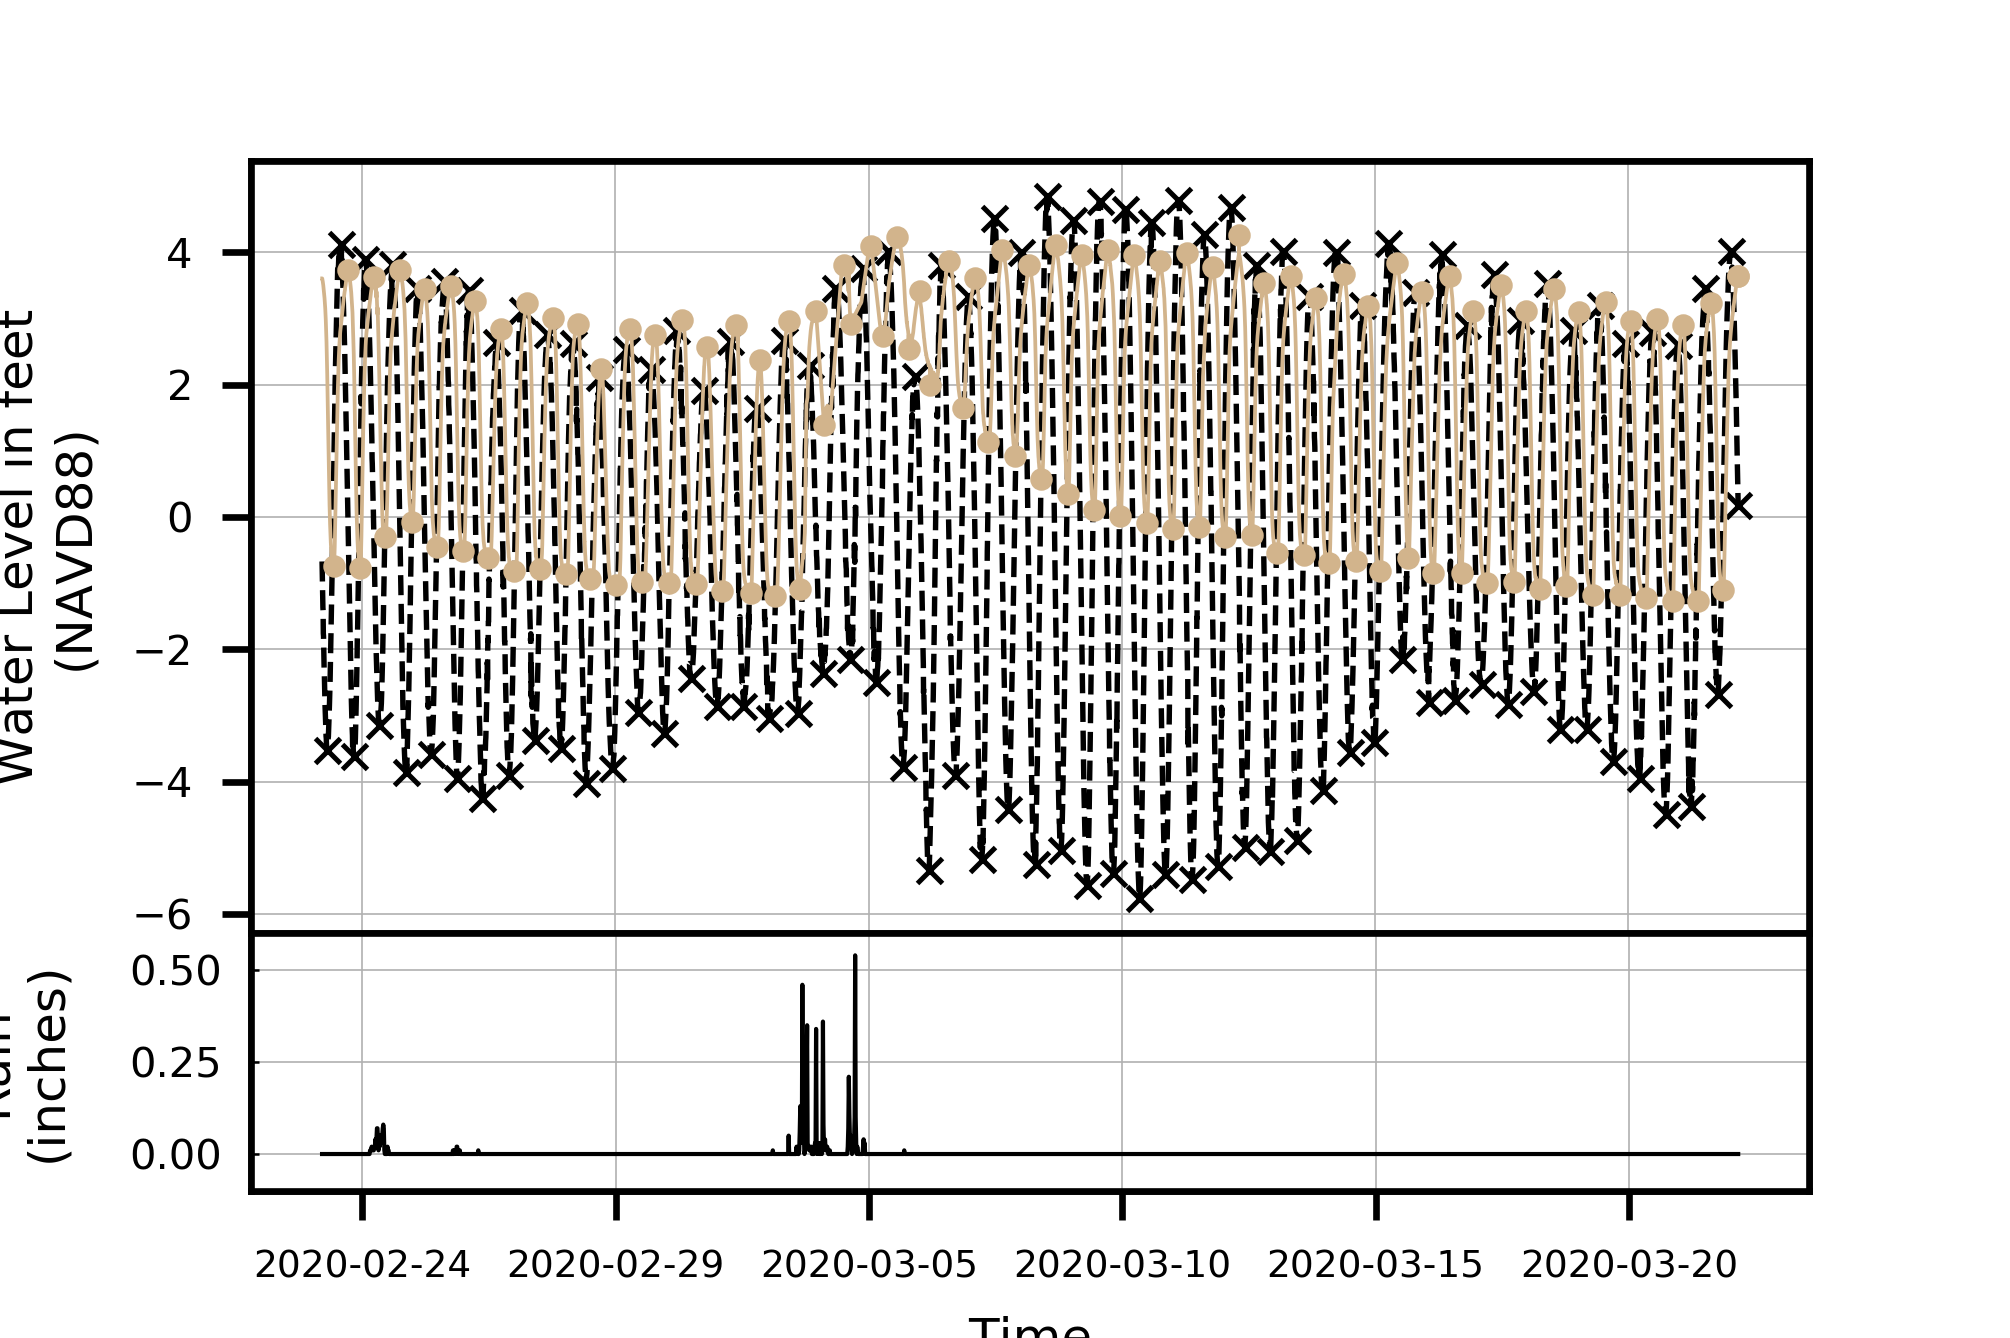

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] whic

In [110]:
# plot rain data with inland sensor data

# %matplotlib notebook

num=24

slsdata = get_sls_water_level_data(sensors_water.desc[num], spatial_start, spatial_end)

# nearest neighbor filtering
slsdata = slsdata[abs(slsdata['adj_value'] - slsdata['adj_value'].shift(1)) < 0.3] 
slsdata = slsdata[abs(slsdata['adj_value'] - slsdata['adj_value'].shift(-1)) < 0.3]

fig = plt.figure(figsize=(3.35,2.23), dpi=1200) #gridspec_kw={'hspace': 0, 'wspace': 0})
gs = fig.add_gridspec(8, 1)
fig.subplots_adjust(hspace=0)

a = fig.add_subplot()
a.tick_params(labelbottom=False, labelleft=False, which='both', top=False, bottom=False, left=False, right=False)
#a.set_ylabel('Water Level (ft)', fontsize=30, labelpad=60 )
a.set_xlabel('Time', fontsize=6, labelpad=15)

a0 = fig.add_subplot(gs[0:6, :])

a0.plot(ftp_data['timestamp'], ftp_data['adj_value'], label='NOAA Tide Gauge at Fort Pulaski', color="black", linestyle='dashed',linewidth=0.65)
a0.plot(max_times_NOAA, maxes_NOAA,label='maxes & mins', linestyle='None', color='black',marker='x', ls='', ms='3', mew='0.6')
a0.plot(min_times_NOAA, mins_NOAA, linestyle='None', color='black',marker='x', ls='', ms='3', mew='0.6')

a0.plot(slsdata['timestamp'], slsdata['adj_value'], label=sensors_water.desc[num], color="tan", linewidth=0.45)
a0.plot(spatial_data_sls_maxes.max_times[spatial_data_sls_maxes.max_sensor_name==sensors_water.desc[num]], spatial_data_sls_maxes.maxes[spatial_data_sls_maxes.max_sensor_name==sensors_water.desc[num]], label='maxes & mins', color="tan",marker='o',markersize=2, linestyle='None', ls='', mew='0.7')
a0.plot(spatial_data_sls_mins.min_times[spatial_data_sls_mins.min_sensor_name==sensors_water.desc[num]], spatial_data_sls_mins.mins[spatial_data_sls_mins.min_sensor_name==sensors_water.desc[num]],linestyle='None', color="tan", marker='o',markersize=2,ls='', mew='0.7')

a0.xaxis.set_major_locator(pldates.DayLocator(interval=5))
a0.tick_params(axis='y', labelsize=5)
a0.set_ylabel('\n'.join(wrap('Water Level in feet (NAVD88)',20)), fontsize=6, labelpad=4)
a0.grid( linewidth=0.2)
a0.set_xticklabels([])
# a0.spines['left'].set_linewidth(0.2)
# a0.spines['right'].set_linewidth(0.2)
# a0.spines['top'].set_linewidth(0.2)
# a0.spines['bottom'].set_linewidth(0.2)
# a0.tick_params(axis="y", direction="in", length=1, width=0.3)
# plt.legend(bbox_to_anchor=(0.8, 0.32), fontsize=30)
#plt.legend(loc='upper right', fontsize =30);



a2 = fig.add_subplot(gs[6:8, :])


# a2.set_ylabel('Rain (inches)', color='black', fontsize=4, labelpad=2)  # we already handled the x-label with ax1
a2.plot(ogch17Rain['timestamp'], ogch17Rain['247788_00045_cd'], label='Hourly Rain - Inland', color='black', linewidth=0.5)
a2.tick_params(axis='y', labelcolor='black', labelsize=3.5)

a2.tick_params(axis='y', labelsize=5)
a2.set_ylabel('\n'.join(wrap('Rain (inches)',12)), fontsize=6, labelpad=7)
a2.set_ylim(-0.1, 0.6)
a2.grid(True, linewidth=0.2)
# a2.set_xticklabels([])
# a2.spines['left'].set_linewidth(0.2)
# a2.spines['right'].set_linewidth(0.2)
# a2.spines['top'].set_linewidth(0.2)
# a2.spines['bottom'].set_linewidth(0.2)
a2.tick_params(axis="y", direction="in", length=1, width=0.3)
# plt.legend(bbox_to_anchor=(0.682, 0.32), fontsize =30);



# timezone = pytz.timezone("America/New_York")
# auto = pldates.AutoDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# concise = pldates.ConciseDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# a2.xaxis.set_major_formatter(concise)
# a3.get_xaxis().get_major_formatter().set_useOffset(False)

a2.tick_params(axis='x', labelsize=4.5)
# a2.tick_params(axis="x", direction="out", length=2, width=0.5)
a2.xaxis.set_major_locator(pldates.DayLocator(interval=5))


# plt.legend(bbox_to_anchor=(0.71, 0.32), fontsize =30);

# fig.legend(bbox_to_anchor=(1, 1), fontsize =15)
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, shadow=False, fontsize =30)

# fig.legend(fontsize=3, bbox_to_anchor=(0,1.02,1,0.2), loc='lower center', ncol=3)
# fig.legend( loc="upper center",borderaxespad=0.2, fancybox=True, shadow=False, ncol=3, fontsize = 4)

# plt.subplots_adjust(bottom=0.16)

# fig.tight_layout()
fig.patch.set_facecolor('white')

plt.savefig('RainEvent.jpg', bbox_inches='tight', dpi=1200)#, bbox_extra_artist=[fig.legend])


# figlegend.savefig('legend.png')
# fig.patch.set_alpha(0.7)

# # LEGEND SEPARATELY
# import pylab
# fig = pylab.figure()
# figlegend = pylab.figure(figsize=(3,2))
# ax = fig.add_subplot(111)
# lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10))
# figlegend.legend(lines, ('one', 'two'), 'center')
# fig.show()
# figlegend.show()
# figlegend.savefig('legend.png')
# figlegend.show()

# plt.xlabel('Time', fontsize=24, labelpad=15)
# plt.ylabel('Water Level (ft)', fontsize=24)
# plt.tick_params(axis="x", labelsize=14)
# plt.tick_params(axis="y", labelsize=13)

#plt.show()

In [111]:
# total rain during the time period
ogch17Rain['247788_00045_cd'].values.sum()

5.920000000000001

# 4) Hurricane Dorian Case Study

In [ ]:
"""
The Tide Finder used above is slightly edited and repurposed to specifically analyze the time period surrounding
Hurricane Dorian and its impact on the East Coast. 
"""

In [ ]:
# format should be YYYY-mm-dd HH:MM, in EST (daylight savings time)  
dor_spatial_start = '2019-08-24 00:00' 
dor_spatial_end = '2019-09-09 00:00'

## High/Low Tide Finder for NOAA Tide Gauge

In [79]:
ftp_data = get_noaa_water_level_data(dor_spatial_start, dor_spatial_end)

In [80]:
# this program basically finds all the high and low tide levels along with the timestamps of those max/min levels
# it does this by taking 12hr segments of the data and locating the max and mins. then, starting from the timestamps 
# of those maxes and mins, a temporary 12hr segment of data is selected and max, mins, and timestamps are noted.
# repeated levels are avoided by comparing the timestamp of the current max/min to the timestamp of the previous max/min 
# if they are within 6 hours of each other (this could be decreased to probably 1hr), they are compared to see which is 
# truly the local max/min. Even in moments of erroneous sensor outputs, only one max/min will be reported

# this localization is done in the 'get_sls_water_level_data' function, but just doing it here to be used in this function
start_dt = datetime.strptime(dor_spatial_start, "%Y-%m-%d %H:%M")
est = pytz.timezone("America/New_York")
start_est = est.localize(start_dt)

# initializing lists
max_times_NOAA = []
min_times_NOAA = []
maxes_NOAA = []
mins_NOAA = []

# these values appended for the timestamp comparison to function properly. These values will be excluded during analysis
max_times_NOAA.append(start_est-timedelta(hours=12))
min_times_NOAA.append(start_est-timedelta(hours=12))
maxes_NOAA.append(-100)
mins_NOAA.append(100)

# currset is used to track the current set of 12hr data, and i is used to keep the start and end intervals of currset
# consistent as we shift currset forward
i=0
currset = ftp_data[ftp_data['timestamp']<=(start_est+timedelta(hours=((i*12)+12)))]

# loops forward through each 12hr set of data while making sure currset doesnt exceed the end time
while (currset.tail(1)['timestamp'].values)<=(ftp_data.tail(1)['timestamp'].values):
    
#     temporarily storing max, mins, and timestamps 
    currmaxtime = currset['timestamp'][currset['adj_value'].idxmax()]
    currmintime = currset['timestamp'][currset['adj_value'].idxmin()]
    currmax = currset['adj_value'].max()
    currmin = currset['adj_value'].min()
    
#     making sure max/min and timestamps aren't repeat and only storing the true local max/min along with its timestamp
#     if the timestamp of the previous max/min is = to current max/min timestamp, nothing happens since that value is already stored
    if (min_times_NOAA[-1]!=currmintime) & ((currmintime-min_times_NOAA[-1])<timedelta(hours=6)) & (currmin<mins_NOAA[-1]):
        mins_NOAA[-1]=currmin
        min_times_NOAA[-1]=currmintime
    elif ((currmintime-min_times_NOAA[-1])>timedelta(hours=6)):
        mins_NOAA.append(currmin)
        min_times_NOAA.append(currmintime)
    
    if (max_times_NOAA[-1]!=currmaxtime) & ((currmaxtime-max_times_NOAA[-1])<timedelta(hours=6)) & (currmax>maxes_NOAA[-1]):
        maxes_NOAA[-1]=currmax
        max_times_NOAA[-1]=currmaxtime
    elif ((currmaxtime-max_times_NOAA[-1])>timedelta(hours=6)):
        maxes_NOAA.append(currmax)
        max_times_NOAA.append(currmaxtime)
    
#     temperorary 12hr dataset starting at the min within the current dataset
#     used to make sure no max values are missed since tidal cycles aren't in perfect time or consistency
    tempsetmax = ftp_data[(ftp_data.timestamp>=min_times_NOAA[-1])&(ftp_data.timestamp<=(min_times_NOAA[-1]+timedelta(hours=12)))]
    tempmax = tempsetmax['adj_value'].max()
    tempmaxtime = tempsetmax['timestamp'][tempsetmax['adj_value'].idxmax()]
    
#     temperorary 12hr dataset starting at the max within the current dataset
#     used to make sure no min values are missed since tidal cycles aren't in perfect time or consistency
    tempsetmin = ftp_data[(ftp_data.timestamp>=max_times_NOAA[-1])&(ftp_data.timestamp<=(max_times_NOAA[-1]+timedelta(hours=12)))]
    tempmin = tempsetmin['adj_value'].min()
    tempmintime = tempsetmin['timestamp'][tempsetmin['adj_value'].idxmin()]

#     making sure max/min and timestamps aren't repeat and only storing the true local max/min along with its timestamp
#     if the timestamp of the previous max/min is = to current max/min timestamp, nothing happens since that value is already stored
    if (min_times_NOAA[-1]!=tempmintime) & ((tempmintime-min_times_NOAA[-1])<timedelta(hours=6)) & (tempmin<mins_NOAA[-1]):
        mins_NOAA[-1]=tempmin
        min_times_NOAA[-1]=tempmintime
    elif ((tempmintime-min_times_NOAA[-1])>timedelta(hours=6)):
        mins_NOAA.append(tempmin)
        min_times_NOAA.append(tempmintime)
    
    if (max_times_NOAA[-1]!=tempmaxtime) & ((tempmaxtime-max_times_NOAA[-1])<timedelta(hours=6)) & (tempmax>maxes_NOAA[-1]):
        maxes_NOAA[-1]=tempmax
        max_times_NOAA[-1]=tempmaxtime
    elif ((tempmaxtime-max_times_NOAA[-1])>timedelta(hours=6)):
        maxes_NOAA.append(tempmax)
        max_times_NOAA.append(tempmaxtime) 
    
    #   moving the current set forward by 12 hours
    i+=1
    currset = ftp_data[(ftp_data['timestamp']>(start_est+timedelta(hours=(i*12))))&(ftp_data['timestamp']<=(start_est+timedelta(hours=((i*12)+12))))]

# deleting the first values that were temporary
del mins_NOAA[0]
del maxes_NOAA[0]
del min_times_NOAA[0]
del max_times_NOAA[0]

# compare lengths and check that it makes sense with the number of days considered
len(mins_NOAA), len(min_times_NOAA), len(maxes_NOAA), len(max_times_NOAA)

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


(31, 31, 32, 32)

In [81]:
fdmin = {'mins':mins_NOAA, 'mintimes':min_times_NOAA}
fspatial_data_sls_mins = pd.DataFrame(fdmin)

fdmax = {'maxes':maxes_NOAA, 'maxtimes':max_times_NOAA}
fspatial_data_sls_maxes = pd.DataFrame(fdmax)


In [82]:
fspatial_data_sls_mins[(fspatial_data_sls_mins.min_times>'2019-09-04 17:00') & (fspatial_data_sls_mins.min_times<'2019-09-04 22:00')].mintimes

22   2019-09-04 20:12:00-04:00
Name: mintimes, dtype: datetime64[ns, America/New_York]

<IPython.core.display.Javascript object>


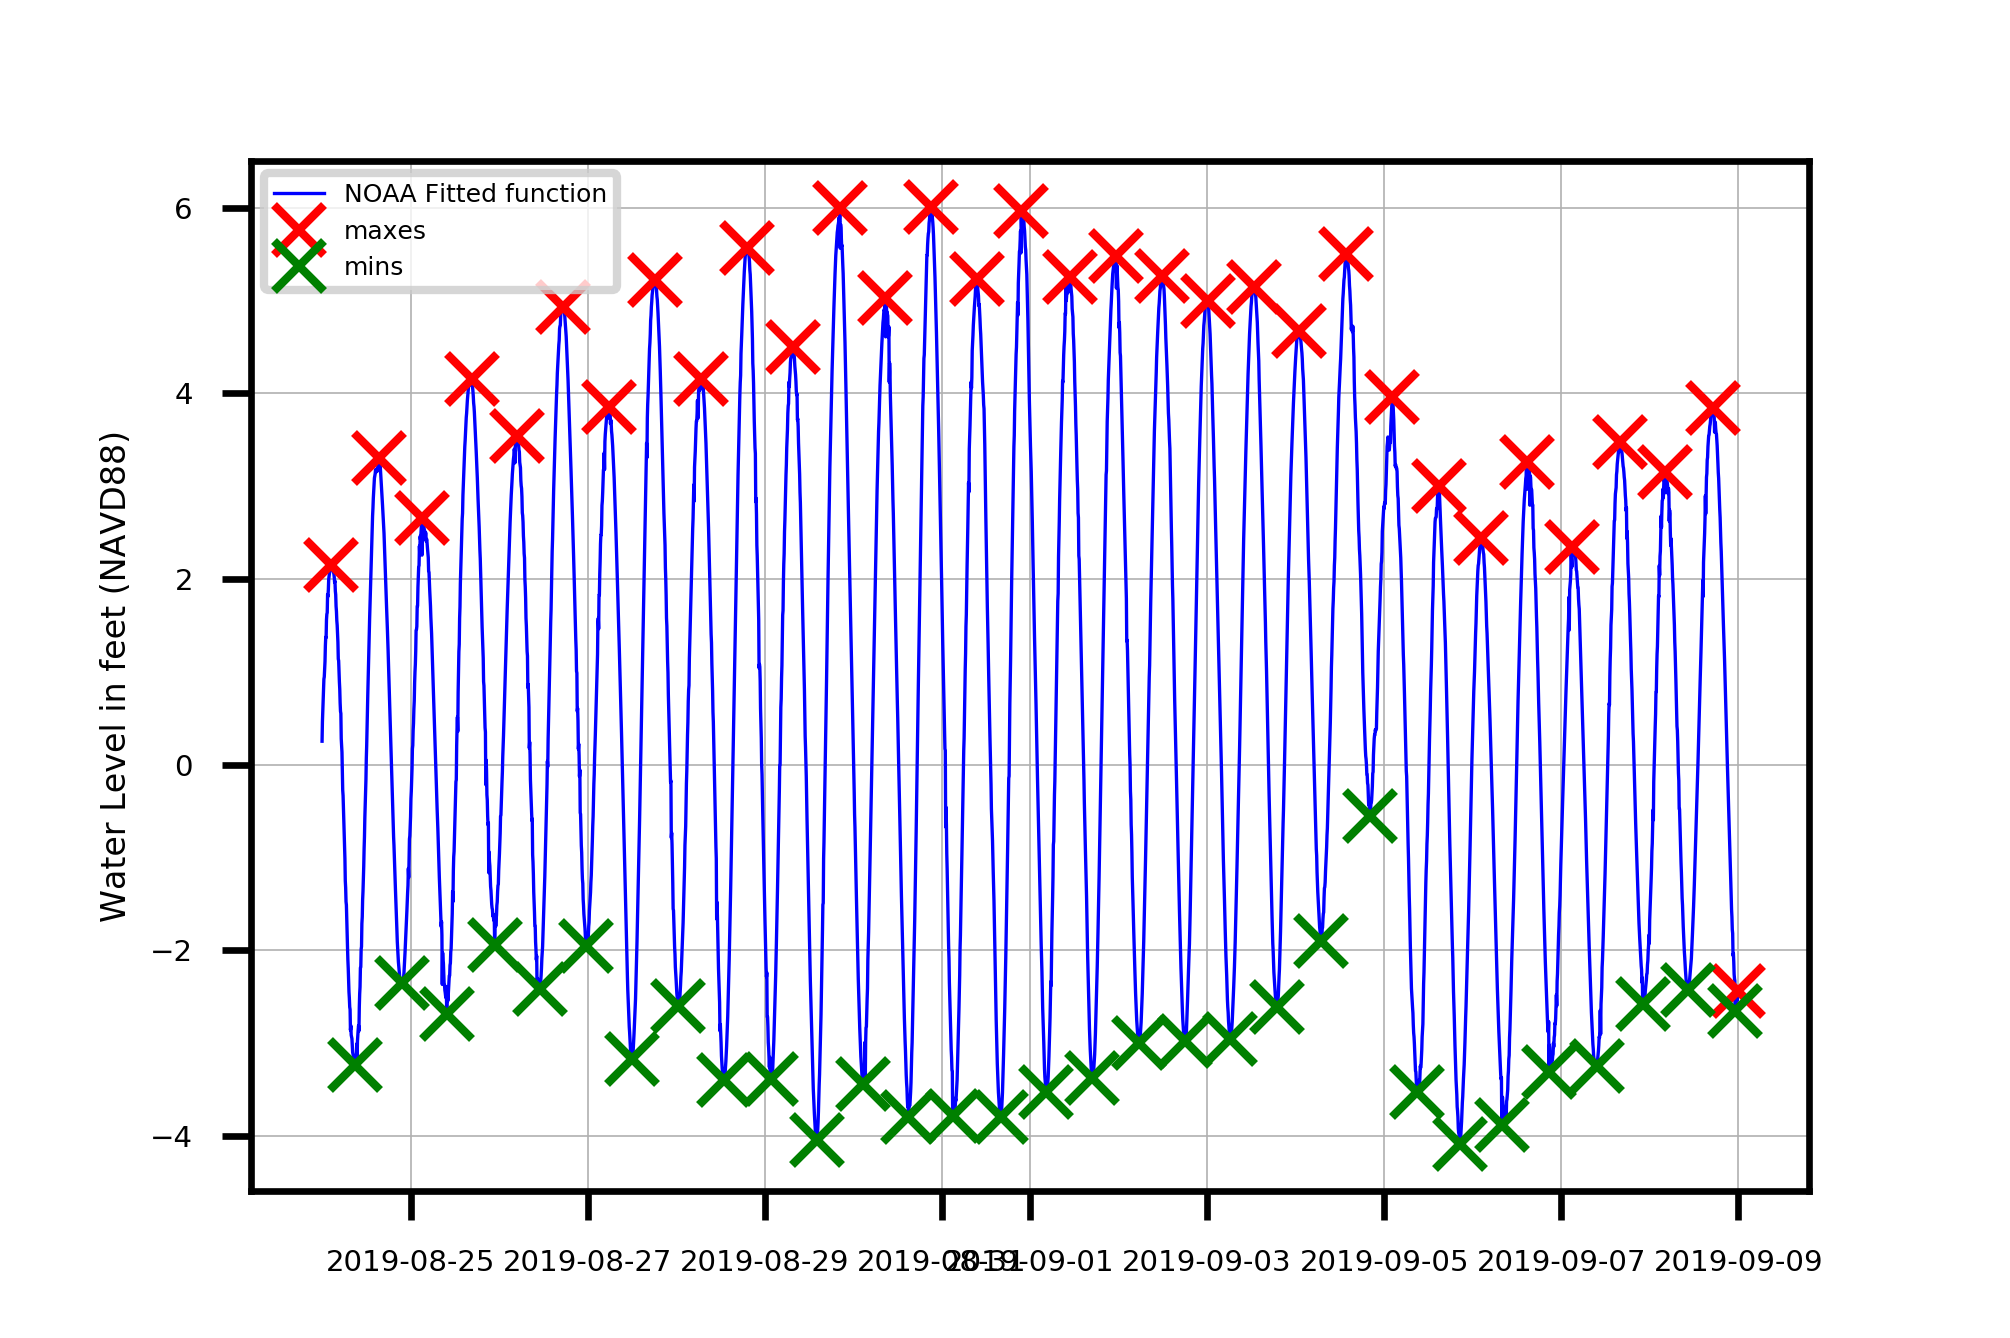

In [83]:
%matplotlib notebook

fig = plt.figure(figsize=(3.35,2.23), dpi=300)
plt.ylabel('Water Level in feet (NAVD88)', fontsize=4, labelpad=2 )
plt.xlabel('Time', fontsize=4, labelpad=11)
plt.tick_params(axis='x', labelsize=3.5)
plt.tick_params(axis='y', labelsize=3.5)
plt.grid( linewidth=0.2)

plt.plot(ftp_data['timestamp'], ftp_data['adj_value'], label='NOAA Fitted function', color="blue", linewidth=0.4)
plt.plot(max_times_NOAA, maxes_NOAA, 'rx', label='maxes')
plt.plot(min_times_NOAA, mins_NOAA, 'gx', label='mins')
# plt.plot(xp, yp, 'b.-', label='Fort Pulaski Tide Gauge', linewidth=0.4, markersize=0.1)

plt.legend(loc='upper left', fontsize=3);


## High/Low Tides for all sensors V3

In [85]:
# this program basically finds all the maximum high and minimum low tide levels along with the timestamps of those max/min levels
# it does this by taking 12hr segments of the data and locating the max and mins. then, starting from the timestamps 
# of those maxes and mins, a temporary 12hr segment of data is selected and max, mins, and timestamps are noted.
# repeated levels are avoided by comparing the timestamp of the current max/min to the timestamp of the previous max/min 
# if they are within 6 hours of each other (this could be decreased to probably 1hr), they are compared to see which is 
# truly the local max/min. Even in moments of erroneous sensor outputs, only one max/min will be reported

# format should be YYYY-mm-dd HH:MM, in EST (daylight savings time)  
# sls_spatial_start = '2019-09-04 00:00' 
# sls_spatial_end = '2019-09-05 12:00'

# this localization is done in the 'get_sls_water_level_data' function, but just doing it here to be used in this function
start_dt = datetime.strptime(dor_spatial_start, "%Y-%m-%d %H:%M")
est = pytz.timezone("America/New_York")
start_est = est.localize(start_dt)

# initializing lists
maxtimes = []
mintimes = []
maxes = []
mins = []
sensor_name_max = []
sensor_name_min = []

dataloss = []
num_returns = []
dataloss_name = []


# looping through all sensors with water level readings
for index in sensors_water.index:

#     if the a sensor has no data to pull in this time frame, it will be skipped
    sls_data = get_sls_water_level_data(sensors_water.desc[index], dor_spatial_start, dor_spatial_end)
    if sls_data.size > 0:
        
        countb = len(sls_data)
        num_returns.append(countb)
        #nearest neighbor filtering
        sls_data = sls_data[abs(sls_data['adj_value'] - sls_data['adj_value'].shift(1)) < 0.3] 
        sls_data = sls_data[abs(sls_data['adj_value'] - sls_data['adj_value'].shift(-1)) < 0.3] 
        counta = len(sls_data)
        dataloss.append((countb-counta)/countb)
        dataloss_name.append(sensors_water.desc[index])
#         print(countb,counta)

#         each time the next sensor's data is pulled, these values will be appended to the running list as separaters
#         for the timestamp comparison to function properly. These values will be excluded during analysis. The number
#         of "fake" sensors can also be used to see how many total sensors had usable data
        maxtimes.append(start_est-timedelta(hours=12))
        mintimes.append(start_est-timedelta(hours=12))
        maxes.append(-100)
        mins.append(100)
        sensor_name_max.append('fake')
        sensor_name_min.append('fake')

#         currset is used to track the current set of 12hr data, and i is used to keep the start and end intervals of currset
#         consistent as we shift currset forward
        i=0
        currset = sls_data[sls_data['timestamp']<=pd.to_datetime(start_est+timedelta(hours=((i*12)+12)))]
    
#         loops forward through each 12hr set of data while making sure currset doesnt exceed the end time
        while (currset.tail(1)['timestamp'].values)<=(sls_data.tail(1)['timestamp'].values) :
        
#             temporarily storing max, mins, and timestamps 
            currmaxtime = currset['timestamp'][currset['adj_value'].idxmax()]
            currmintime = currset['timestamp'][currset['adj_value'].idxmin()]
            currmax = currset['adj_value'].max()
            currmin = currset['adj_value'].min()
            
#             making sure max/min and timestamps aren't repeat and only storing the true local max/min along with its timestamp
#             if the timestamp of the previous max/min is = to current max/min timestamp, nothing happens since that value is already stored
            if (mintimes[-1]!=currmintime) & ((currmintime-mintimes[-1])<timedelta(hours=6)) & (currmin<mins[-1]):
                mins[-1]=currmin
                mintimes[-1]=currmintime
                sensor_name_min[-1]=sensors_water.desc[index]
            elif ((currmintime-mintimes[-1])>=timedelta(hours=6)):
                mins.append(currmin)
                mintimes.append(currmintime)
                sensor_name_min.append(sensors_water.desc[index])

            if (maxtimes[-1]!=currmaxtime) & ((currmaxtime-maxtimes[-1])<timedelta(hours=6)) & (currmax>maxes[-1]):
                maxes[-1]=currmax
                maxtimes[-1]=currmaxtime
                sensor_name_max[-1]=sensors_water.desc[index]
            elif ((currmaxtime-maxtimes[-1])>=timedelta(hours=6)):
                maxes.append(currmax)
                maxtimes.append(currmaxtime)
                sensor_name_max.append(sensors_water.desc[index])
            
#             if a sensor goes down in the middle of the time period that we're studying, then the difference 
#             calculations later on will be incorrect because of mismatched timestamps of maxes/mins. 
#             therefore, we look at the timestamps between the last two and see if the difference is greater than 18hrs
#             if so, then the number of hours difference is divided by 12 and that many instances of NAN/NAT are insterted
            if (((maxtimes[-1] - maxtimes[-2])>timedelta(hours=18)) and sensor_name_max[-2]!='fake' and sensor_name_max[-1]!='fake'):
                for j in range(math.floor(((maxtimes[-1] - maxtimes[-2]).total_seconds()/3600)/12)-1):
                    maxes.insert(len(maxes)-1,float('NaN'))
                    maxtimes.insert(len(maxtimes)-1,pd.NaT)
                    sensor_name_max.insert(len(sensor_name_max)-1,sensors_water.desc[index])
            if (((mintimes[-1] - mintimes[-2])>timedelta(hours=18)) and sensor_name_min[-2]!='fake' and sensor_name_min[-1]!='fake'):
                for k in range(math.floor(((mintimes[-1] - mintimes[-2]).total_seconds()/3600)/12)-1):
                    mins.insert(len(mins)-1,float('NaN'))
                    mintimes.insert(len(mintimes)-1,pd.NaT)
                    sensor_name_min.insert(len(sensor_name_min)-1,sensors_water.desc[index])
                    
#             temperorary 12hr dataset starting at the min within the current dataset
#             used to make sure no max values are missed since tidal cycles aren't in perfect time or consistency
            tempsetmax = sls_data[(sls_data.timestamp>=mintimes[-1])&(sls_data.timestamp<=(mintimes[-1]+timedelta(hours=12)))]
            tempmax = tempsetmax['adj_value'].max()
            tempmaxtime = tempsetmax['timestamp'][tempsetmax['adj_value'].idxmax()]

#             temperorary 12hr dataset starting at the max within the current dataset
#             used to make sure no min values are missed since tidal cycles aren't in perfect time or consistency
            tempsetmin = sls_data[(sls_data.timestamp>=maxtimes[-1])&(sls_data.timestamp<=(maxtimes[-1]+timedelta(hours=12)))]
            tempmin = tempsetmin['adj_value'].min()
            tempmintime = tempsetmin['timestamp'][tempsetmin['adj_value'].idxmin()]

#             making sure max/min and timestamps aren't repeat and only storing the true local max/min along 
#             with its timestamp if the timestamp of the previous max/min is equal to current max/min timestamp, 
#             nothing happens since that value is already stored
            if (mintimes[-1]!=tempmintime) & ((tempmintime-mintimes[-1])<timedelta(hours=6)) & (tempmin<mins[-1]):
                mins[-1]=tempmin
                mintimes[-1]=tempmintime
                sensor_name_min[-1]=sensors_water.desc[index]
            elif ((tempmintime-mintimes[-1])>=timedelta(hours=6)):
                mins.append(tempmin)
                mintimes.append(tempmintime)
                sensor_name_min.append(sensors_water.desc[index])

            if (maxtimes[-1]!=tempmaxtime) & ((tempmaxtime-maxtimes[-1])<timedelta(hours=6)) & (tempmax>maxes[-1]):
                maxes[-1]=tempmax
                maxtimes[-1]=tempmaxtime
                sensor_name_max[-1]=sensors_water.desc[index]
            elif ((tempmaxtime-maxtimes[-1])>=timedelta(hours=6)):
                maxes.append(tempmax)
                maxtimes.append(tempmaxtime) 
                sensor_name_max.append(sensors_water.desc[index])
            
#             if a sensor goes down in the middle of the time period that we're studying, then the difference 
#             calculations later on will be incorrect because of mismatched timestamps of maxes/mins. 
#             therefore, we look at the timestamps between the last two and see if the difference is greater than 18hrs
#             if so, then the number of hours difference is divided by 12 and that many instances of NAN/NAT are insterted
            if (((maxtimes[-1] - maxtimes[-2])>timedelta(hours=18)) and sensor_name_max[-2]!='fake' and sensor_name_max[-1]!='fake'):
                for j in range(math.floor(((maxtimes[-1] - maxtimes[-2]).total_seconds()/3600)/12)-1):
                    maxes.insert(len(maxes)-1,float('NaN'))
                    maxtimes.insert(len(maxtimes)-1,pd.NaT)
                    sensor_name_max.insert(len(sensor_name_max)-1,sensors_water.desc[index])
            if (((mintimes[-1] - mintimes[-2])>timedelta(hours=18)) and sensor_name_min[-2]!='fake' and sensor_name_min[-1]!='fake'):
                for k in range(math.floor(((mintimes[-1] - mintimes[-2]).total_seconds()/3600)/12)-1):
                    mins.insert(len(mins)-1,float('NaN'))
                    mintimes.insert(len(mintimes)-1,pd.NaT)
                    sensor_name_min.insert(len(sensor_name_min)-1,sensors_water.desc[index])

#             moving the current set forward by 12 hours
            i+=1
            currset = sls_data[(sls_data['timestamp']>pd.to_datetime(start_est+timedelta(hours=(i*12))))&(sls_data['timestamp']<=pd.to_datetime(start_est+timedelta(hours=((i*12)+12))))]
            while currset.size==0 and i<(len(sls_data)/12):
                i+=1
                currset = sls_data[(sls_data['timestamp']>pd.to_datetime(start_est+timedelta(hours=(i*12))))&(sls_data['timestamp']<=pd.to_datetime(start_est+timedelta(hours=((i*12)+12))))]
        
len(mins), len(mintimes), len(sensor_name_min), len(maxes), len(maxtimes), len(sensor_name_max)

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Us

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


(870, 870, 870, 881, 881, 881)

In [86]:
dmin = {'mins':mins, 'mintimes':mintimes, 'sensor_name_min':sensor_name_min}
spatial_data_sls_mins = pd.DataFrame(dmin)

dmax = {'maxes':maxes, 'maxtimes':maxtimes, 'sensor_name_max':sensor_name_max}
spatial_data_sls_maxes = pd.DataFrame(dmax)

# spatialdata = spatialdata[spatialdata.mins!=-100]
# spatialdata = spatialdata[spatialdata.sensor_name!='Kilkenny Creek environmental sensors']

In [87]:
spatial_data_sls_maxes.groupby('sensor_name_max').count()

maxes  maxtimes
sensornamemax                                                      
Bull River Marina environmental sensors                31        31
Calibration test unit 021                               6         6
Calibration test unit 031                              24        24
Catalina Drive Sea Level Sensor                        31        31
Coffee Bluff Marina environmental sensors              30        30
Dean Forest Road at Harden Canal Sea Level Sensor      31        31
Delegal Creek Marina Sea Level Sensor                  26        26
Diamond Causeway at Shipyard Creek Sea Level Se...     31        31
Faye Drive on Burnside Island Sea Level Sensor         31        31
Fort Pulaski (A) Sea Level Sensor                      31        31
Fort Pulaski (B) Sea Level Sensor                      31        31
Hunt Drive on Burnside Island Sea Level Sensor         31        31
Hwy 21 at St Augustine Creek Level Sensor              31        31
Hwy 80 at Chimney Creek on Tybee Island Sea Lev...     31        31
Hwy 80 at Grays Creek Sea Level Sensor                 31        31
Kilkenny Creek environmental sensors                   30        30
LaRoche Avenue at Nottingham Creek Sea Level Se...     30        30
Landings Harbor Marina Sea Level Sensor                30        30
Lazaretto Creek Fishing Pier Sea Level Sensor          31        31
Oatland Island Road environmental sensors              31        31
Rose Dhu Island Sea Level Sensor                       26        26
SKIO Dock Sea Level Sensor                             31        31
Sapelo Island Ferry Dock Sea Level Sensor              30        30
Savannah State Sea Level Sensor                        30        30
Skidaway Road at Herb River Sea Level Sensor           27        27
Solomon Bridge Sea Level Sensor                        30        30
Sullivan Street Sea Level Sensor                       31        31
Turner Creek Boat Ramp Sea Level Sensor                31        31
fake                                                   33        33

In [88]:
# compilation of dataloss during nearest neighbor filter for each sensor, which was done before tide finder
dl = {'Sensor':dataloss_name,'Dataloss (%)':[x * 100 for x in dataloss], 'Missing Data (%)':[100-(100*(x / max(num_returns))) for x in num_returns]}
data_quality = pd.DataFrame(dl)
data_quality

Sensor  Dataloss (%)  \
0                Kilkenny Creek environmental sensors      3.294664   
1           Coffee Bluff Marina environmental sensors      0.882900   
2           Oatland Island Road environmental sensors      8.394698   
3               Hwy 17 at Salt Creek Sea Level Sensor     26.520913   
4                     Catalina Drive Sea Level Sensor      6.958502   
5                   Fort Pulaski (A) Sea Level Sensor     14.558473   
6             Turner Creek Boat Ramp Sea Level Sensor      6.403689   
7                   Fort Pulaski (B) Sea Level Sensor     18.439210   
8             Landings Harbor Marina Sea Level Sensor     47.459893   
9                          SKIO Dock Sea Level Sensor      5.412054   
10                          Calibration test unit 031      0.077829   
11     Hunt Drive on Burnside Island Sea Level Sensor      5.322129   
12          Sapelo Island Ferry Dock Sea Level Sensor      5.703883   
13                    Savannah State Sea Level Sensor      3.452298   
14            Hutchinson Island environmental sensors     72.727273   
15  Diamond Causeway at Shipyard Creek Sea Level S...      4.656060   
16                   Rose Dhu Island Sea Level Sensor     26.820388   
17                     Shipyard Road Sea Level Sensor     53.684211   
18       Skidaway Road at Herb River Sea Level Sensor     31.306991   
19          Hwy 21 at St Augustine Creek Level Sensor      4.469548   
20                    Solomon Bridge Sea Level Sensor      3.254507   
21  Dean Forest Road at Harden Canal Sea Level Sensor      1.699785   
22      Lazaretto Creek Fishing Pier Sea Level Sensor      7.039441   
23                   Sullivan Street Sea Level Sensor      5.078720   
24                Houlihan Boat Ramp Sea Level Sensor     57.647059   
25  LaRoche Avenue at Nottingham Creek Sea Level S...      5.834306   
26  Hwy 80 at Chimney Creek on Tybee Island Sea Le...      7.886117   
27             Hwy 80 at Grays Creek Sea Level Sensor     23.699825   
28     Faye Drive on Burnside Island Sea Level Sensor      7.410882   
29                          Calibration test unit 021      0.203321   
30              Delegal Creek Marina Sea Level Sensor      1.695890   
31                          Calibration test unit 019      0.161616   
32            Bull River Marina environmental sensors      1.651333   

    Missing Data (%)  
0          58.069851  
1          58.128223  
2          60.365794  
3          89.765541  
4          61.552680  
5          59.237280  
6          62.019652  
7          59.110808  
8          85.446055  
9          60.453351  
10          0.000000  
11         58.322794  
12         59.918280  
13         58.293608  
14         99.892986  
15         58.420080  
16         91.983656  
17         96.303142  
18         90.397899  
19         60.385251  
20         58.449265  
21         59.363751  
22         61.027337  
23         61.688880  
24         98.346143  
25         58.313065  
26         61.387294  
27         72.127639  
28         58.517366  
29         71.290982  
30         66.154295  
31         27.765347  
32         58.760580

<IPython.core.display.Javascript object>


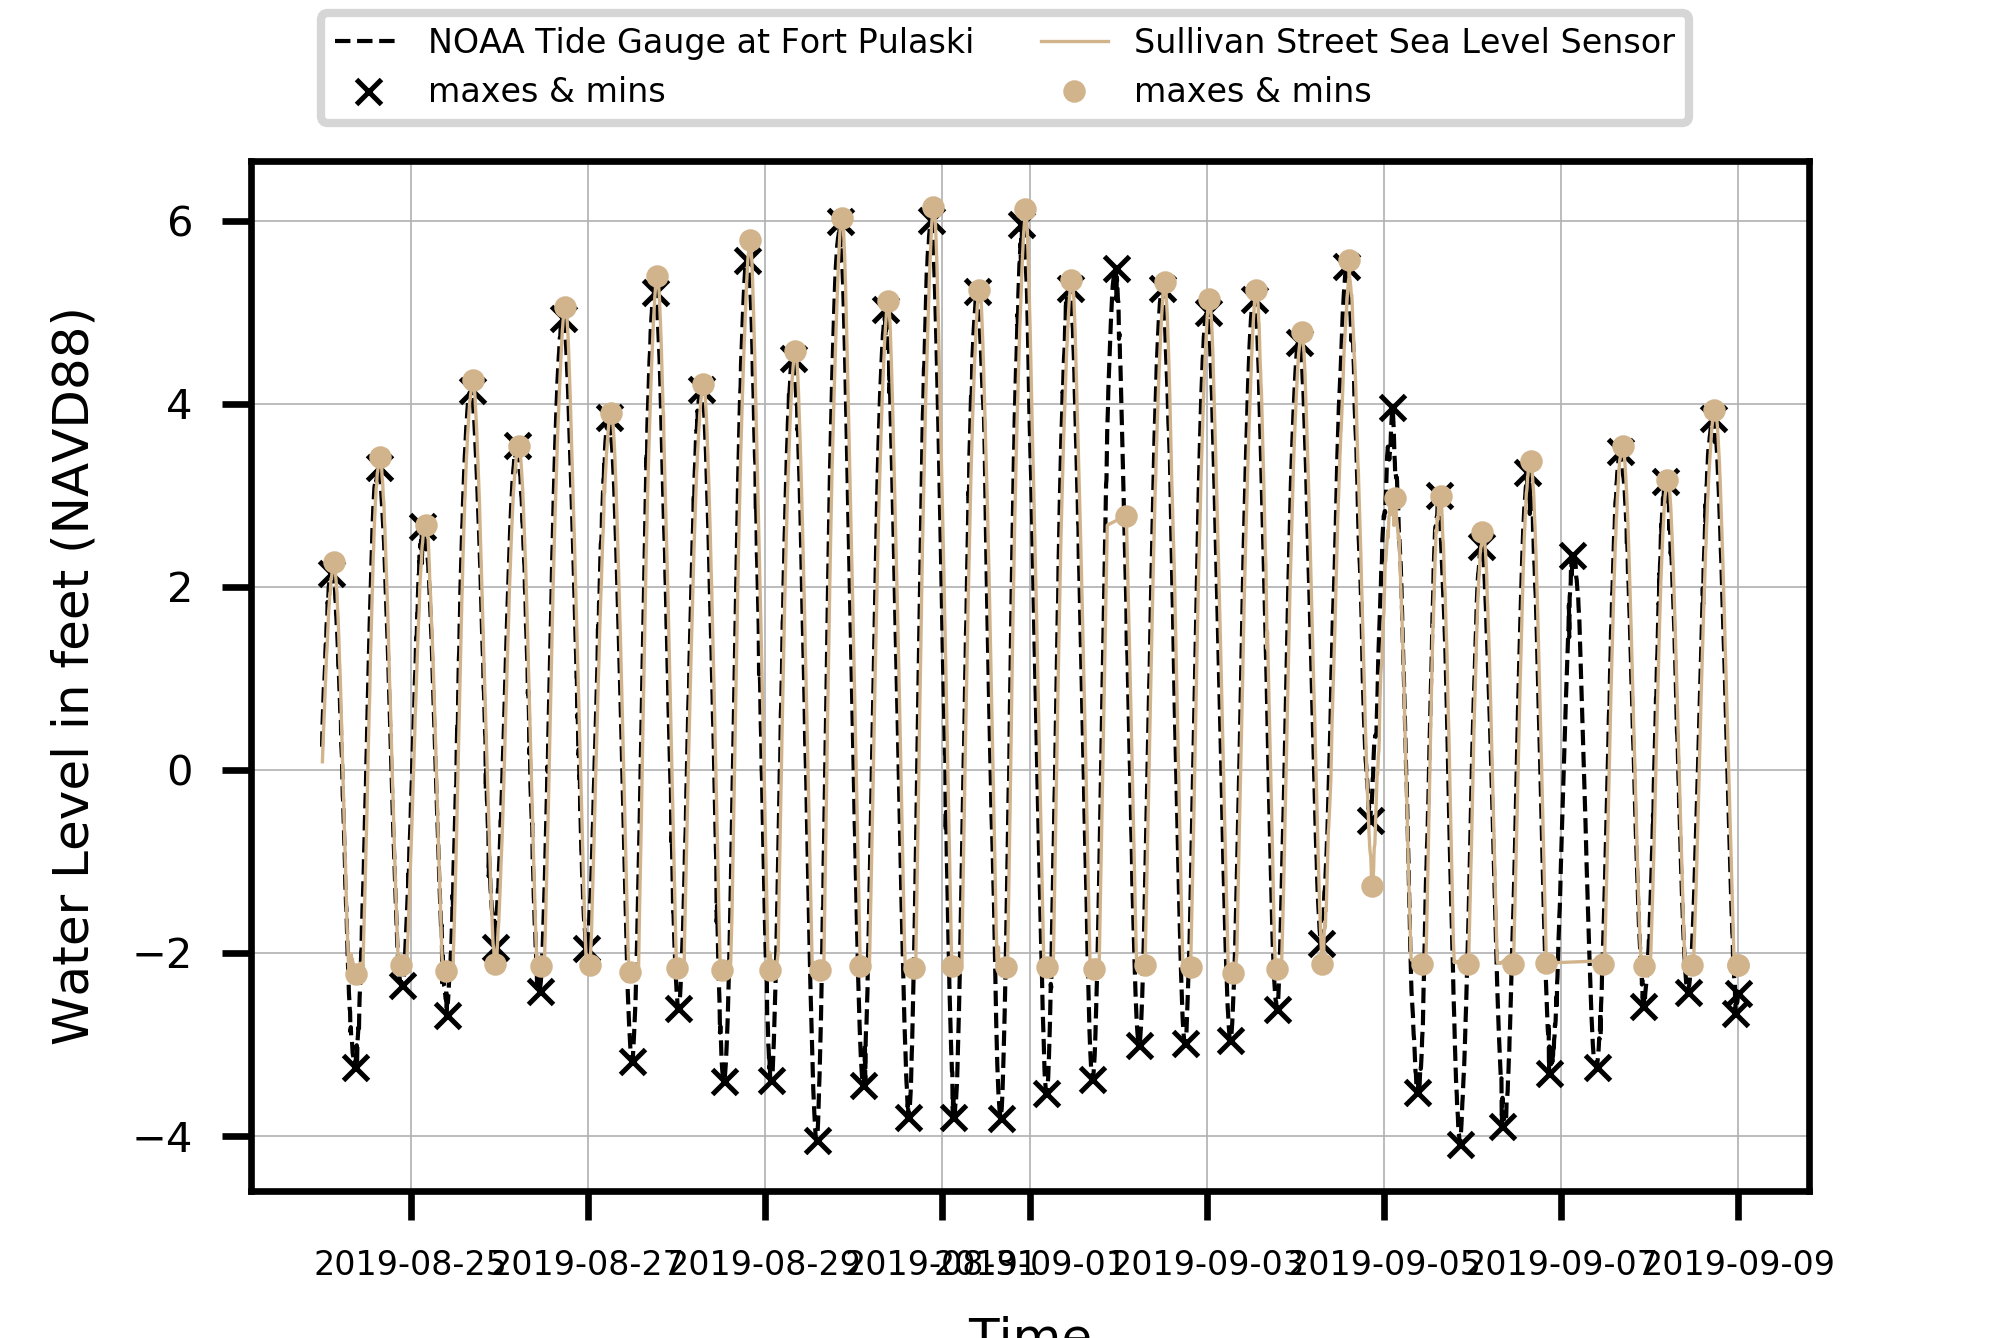

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Saw kwargs ['ls', 'linestyle'] whic

In [89]:
%matplotlib notebook

num=26

slsdata = get_sls_water_level_data(sensors_water.desc[num], dor_spatial_start, dor_spatial_end)

# #nearest neighbor filtering
slsdata = slsdata[abs(slsdata['adj_value'] - slsdata['adj_value'].shift(1)) < 0.3] 
slsdata = slsdata[abs(slsdata['adj_value'] - slsdata['adj_value'].shift(-1)) < 0.3] 

fig = plt.figure(figsize=(3.35,2.23), dpi=300)
ax = fig.add_subplot(1,1,1)
plt.ylabel('Water Level in feet (NAVD88)', fontsize=6, labelpad=4 )
plt.xlabel('Time', fontsize=6, labelpad=4)
plt.tick_params(axis='x', labelsize=4)
plt.tick_params(axis='y', labelsize=5)
plt.grid( linewidth=0.2)


plt.plot(ftp_data['timestamp'], ftp_data['adj_value'], label='NOAA Tide Gauge at Fort Pulaski', color="black", linestyle='dashed',linewidth=0.5)
plt.plot(max_times_NOAA, maxes_NOAA, label='maxes & mins', linestyle='None', color='black',marker='x', ls='', ms='3', mew='0.6')
plt.plot(min_times_NOAA, mins_NOAA, linestyle='None', color='black',marker='x', ls='', ms='3', mew='0.6')

plt.plot(slsdata['timestamp'], slsdata['adj_value'], label=sensors_water.desc[num], color="tan", linewidth=0.4)
plt.plot(spatial_data_sls_maxes.max_times[spatial_data_sls_maxes.max_sensor_name==sensors_water.desc[num]], spatial_data_sls_maxes.maxes[spatial_data_sls_maxes.max_sensor_name==sensors_water.desc[num]],label='maxes & mins', color="tan",marker='o',markersize=2, linestyle='None', ls='', mew='0.7')
plt.plot(spatial_data_sls_mins.min_times[spatial_data_sls_mins.min_sensor_name==sensors_water.desc[num]], spatial_data_sls_mins.mins[spatial_data_sls_mins.min_sensor_name==sensors_water.desc[num]],linestyle='None', color="tan", marker='o',markersize=2,ls='', mew='0.7')
# plt.plot(xp, yp, 'b.-', label='Fort Pulaski Tide Gauge', linewidth=0.4, markersize=0.1)

# plt.legend(loc='lower right', fontsize=3);
fig.legend( loc='upper center',  borderaxespad=0.4, fancybox=True, shadow=False, ncol=2, fontsize = 4)

# ax.xaxis.set_major_locator(pldates.DayLocator(interval=4))   #to get a tick every 15 minutes
# ax.xaxis.set_major_formatter(pldates.DateFormatter('%H:%M')) 

# fig.patch.set_facecolor('white')

# plt.savefig('sensorTimeSeries.jpg', bbox_inches='tight',dpi=1200)#, bbox_extra_artist=[fig.legend])


# plt.tick_params(axis="x", labelsize=2)
# timezone = pytz.timezone("America/New_York")
# auto = pldates.AutoDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# concise = pldates.ConciseDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# fig.axis.xAxis.set_major_formatter(concise)


In [90]:
sensors_water

coords  \
0   [-80.962163, 32.018171]   
1   [-81.201916, 31.791509]   
2   [-81.153906, 31.935783]   
3   [-81.021504, 31.990396]   
4   [-80.866956, 32.006419]   
5   [-81.011631, 32.052507]   
6   [-81.203851, 32.039975]   
7   [-80.866956, 32.006419]   
8    [-80.902494, 32.03455]   
9   [-80.991889, 32.020471]   
10  [-80.902507, 32.034488]   
11  [-81.010769, 31.958661]   
12  [-81.021504, 31.990396]   
13  [-81.210754, 32.168133]   
14  [-81.086168, 31.928811]   
15   [-81.296069, 31.41796]   
16     [-81.058319, 32.013]   
17  [-81.084099, 32.085707]   
18  [-81.084056, 31.951711]   
19  [-81.139343, 31.932421]   
20  [-81.102928, 31.936685]   
21    [-81.07081, 31.98277]   
22  [-81.187966, 32.172647]   
23  [-81.055977, 31.993082]   
24  [-81.213645, 32.050608]   
25  [-80.884092, 32.014112]   
26  [-81.092435, 31.930439]   
27  [-81.156335, 32.164164]   
28  [-81.063662, 32.000149]   
29   [-80.850964, 32.01831]   
30  [-80.994272, 31.987188]   
31  [-81.031204, 32.038669]   
32    [-81.08402, 31.92835]   
33  [-81.210754, 32.168133]   
34  [-81.061556, 31.889711]   
35  [-81.210754, 32.168133]   
36  [-79.782415, 36.097947]   
37  [-80.959417, 32.034717]   

                                                 desc    elev  \
0                 Walthour Road environmental sensors   2.768   
1                Kilkenny Creek environmental sensors     2.7   
2           Coffee Bluff Marina environmental sensors     2.4   
3                 Skidaway Dock environmental sensors   3.103   
4                Catalina Drive environmental sensors    2.23   
5           Oatland Island Road environmental sensors    2.74   
6               Hwy 17 at Salt Creek Sea Level Sensor    2.74   
7                     Catalina Drive Sea Level Sensor     2.5   
8                   Fort Pulaski (A) Sea Level Sensor    3.00   
9             Turner Creek Boat Ramp Sea Level Sensor   2.492   
10                  Fort Pulaski (B) Sea Level Sensor    3.00   
11            Landings Harbor Marina Sea Level Sensor    3.00   
12                         SKIO Dock Sea Level Sensor   3.103   
13                          Calibration test unit 031    None   
14     Hunt Drive on Burnside Island Sea Level Sensor     3.6   
15          Sapelo Island Ferry Dock Sea Level Sensor     1.5   
16                    Savannah State Sea Level Sensor     3.7   
17            Hutchinson Island environmental sensors   4.711   
18  Diamond Causeway at Shipyard Creek Sea Level S...   2.794   
19                   Rose Dhu Island Sea Level Sensor   2.986   
20                     Shipyard Road Sea Level Sensor   3.085   
21       Skidaway Road at Herb River Sea Level Sensor   2.406   
22          Hwy 21 at St Augustine Creek Level Sensor   2.756   
23                    Solomon Bridge Sea Level Sensor   4.807   
24  Dean Forest Road at Harden Canal Sea Level Sensor   2.229   
25      Lazaretto Creek Fishing Pier Sea Level Sensor   2.309   
26                   Sullivan Street Sea Level Sensor   2.513   
27                Houlihan Boat Ramp Sea Level Sensor   1.899   
28  LaRoche Avenue at Nottingham Creek Sea Level S...   2.432   
29  Hwy 80 at Chimney Creek on Tybee Island Sea Le...   3.213   
30             Wilmington Park Canal Sea Level Sensor   3.022   
31             Hwy 80 at Grays Creek Sea Level Sensor   3.593   
32     Faye Drive on Burnside Island Sea Level Sensor   3.708   
33                          Calibration test unit 021    None   
34              Delegal Creek Marina Sea Level Sensor    2.00   
35                          Calibration test unit 019    None   
36  North Church Street at North Buffalo Creek Wat...  716.17   
37            Bull River Marina environmental sensors   3.041   

                                                 link                   name  
0   https://api.sealevelsensors.org/v1.0/Datastrea...        gt-envsense-009  
1   https://api.sealevelsensors.org/v1.0/Datastrea...        gt-envsense-004  
2   https://api.sealevelsensors.org/v1

In [91]:
fspatial_data_sls_mins[(fspatial_data_sls_mins.min_times>'2019-09-04 17:00') & (fspatial_data_sls_mins.min_times<'2019-09-04 22:00')]

mins                  mintimes
22 -0.55 2019-09-04 20:12:00-04:00

In [92]:
ind0 = spatial_data_sls_mins[(spatial_data_sls_mins.min_times>'2019-09-04 17:00') & (spatial_data_sls_mins.min_times<'2019-09-04 22:00')].index

t0=[]
w0=[]
n0=[]
for i in ind0:
    t0.append(fspatial_data_sls_mins[(fspatial_data_sls_mins.min_times>'2019-09-04 17:00') & (fspatial_data_sls_mins.min_times<'2019-09-04 22:00')].mintimes[22]-spatial_data_sls_mins[(spatial_data_sls_mins.min_times>'2019-09-04 17:00') & (spatial_data_sls_mins.min_times<'2019-09-04 22:00')].mintimes[i])
    w0.append(-(fspatial_data_sls_mins[(fspatial_data_sls_mins.min_times>'2019-09-04 17:00') & (fspatial_data_sls_mins.min_times<'2019-09-04 22:00')].mins[22]-spatial_data_sls_mins[(spatial_data_sls_mins.min_times>'2019-09-04 17:00') & (spatial_data_sls_mins.min_times<'2019-09-04 22:00')].mins[i]))
    n0.append(spatial_data_sls_mins[(spatial_data_sls_mins.min_times>'2019-09-04 17:00') & (spatial_data_sls_mins.min_times<'2019-09-04 22:00')].sensor_name_min[i])

d = {'wd':w0, 'td':t0, 'name':n0}
atDorian = pd.DataFrame(d)

atDorian

wd                       td  \
0  -0.614755 -1 days +23:12:11.250000   
1  -1.379228 -1 days +23:01:35.641000   
2  -1.277517 -1 days +23:55:27.562000   
3  -1.310327          00:18:43.226000   
4  -0.037535          00:15:51.200000   
5  -0.762400 -1 days +23:34:04.898000   
6   1.044794 -1 days +22:19:23.193000   
7   0.550000 -1 days +22:17:30.171000   
8   1.350564 -1 days +22:14:14.834000   
9  -2.950827 -1 days +22:49:19.696000   
10 -0.460548 -1 days +23:39:16.356000   
11 -4.702881          00:17:46.394000   
12 -0.900202 -1 days +23:57:20.474000   
13 -0.880516 -1 days +23:04:11.732000   
14  3.840843          02:45:27.485000   
15 -0.788648 -1 days +23:58:17.397000   
16 -0.316184          00:10:26.690000   
17 -0.716466 -1 days +23:33:50.834000   
18 -0.811615 -1 days +23:56:54.548000   
19 -0.401490 -1 days +23:53:28.149000   
20 -0.834582 -1 days +23:23:42.340000   
21 -0.762400 -1 days +23:38:03.139000   
22 -0.644284 -1 days +23:48:32.410000   

                                                 name  
0                Kilkenny Creek environmental sensors  
1           Coffee Bluff Marina environmental sensors  
2           Oatland Island Road environmental sensors  
3                     Catalina Drive Sea Level Sensor  
4                   Fort Pulaski (A) Sea Level Sensor  
5             Turner Creek Boat Ramp Sea Level Sensor  
6                   Fort Pulaski (B) Sea Level Sensor  
7             Landings Harbor Marina Sea Level Sensor  
8                          SKIO Dock Sea Level Sensor  
9                           Calibration test unit 031  
10     Hunt Drive on Burnside Island Sea Level Sensor  
11          Sapelo Island Ferry Dock Sea Level Sensor  
12                    Savannah State Sea Level Sensor  
13  Diamond Causeway at Shipyard Creek Sea Level S...  
14                   Rose Dhu Island Sea Level Sensor  
15                    Solomon Bridge Sea Level Sensor  
16      Lazaretto Creek Fishing Pier Sea Level Sensor  
17                   Sullivan Street Sea Level Sensor  
18  LaRoche Avenue at Nottingham Creek Sea Level S...  
19  Hwy 80 at Chimney Creek on Tybee Island Sea Le...  
20             Hwy 80 at Grays Creek Sea Level Sensor  
21     Faye Drive on Burnside Island Sea Level Sensor  
22            Bull River Marina environmental sensors

In [93]:
#drop Rose Dhu for faulty data
atDorian.drop(atDorian[atDorian.name=='Rose Dhu Island Sea Level Sensor'].index.values,inplace=True)

#drop FTP B for noisy data
atDorian.drop(atDorian[atDorian.name=='Fort Pulaski (B) Sea Level Sensor'].index.values,inplace=True)

In [94]:
fspatial_data_sls_maxes[(fspatial_data_sls_maxes.max_times>'2019-09-04 10:00') & (fspatial_data_sls_maxes.max_times<'2019-09-04 17:00')]

maxes                  maxtimes
22  5.503 2019-09-04 13:42:00-04:00

In [95]:
ind6b = spatial_data_sls_maxes[(spatial_data_sls_maxes.max_times>'2019-09-04 10:00') & (spatial_data_sls_maxes.max_times<'2019-09-04 17:00')].index

t6b=[]
w6b=[]
n6b=[]
for i in ind6b:
    t6b.append(fspatial_data_sls_maxes[(fspatial_data_sls_maxes.max_times>'2019-09-04 10:00') & (fspatial_data_sls_maxes.max_times<'2019-09-04 17:00')].maxtimes[22]-spatial_data_sls_maxes[(spatial_data_sls_maxes.max_times>'2019-09-04 10:00') & (spatial_data_sls_maxes.max_times<'2019-09-04 17:00')].maxtimes[i])
    w6b.append(-(fspatial_data_sls_maxes[(fspatial_data_sls_maxes.max_times>'2019-09-04 10:00') & (fspatial_data_sls_maxes.max_times<'2019-09-04 17:00')].maxes[22]-spatial_data_sls_maxes[(spatial_data_sls_maxes.max_times>'2019-09-04 10:00') & (spatial_data_sls_maxes.max_times<'2019-09-04 17:00')].maxes[i]))
    n6b.append(spatial_data_sls_maxes[(spatial_data_sls_maxes.max_times>'2019-09-04 10:00') & (spatial_data_sls_maxes.max_times<'2019-09-04 17:00')].sensor_name_max[i])

d = {'wd':w6b, 'td':t6b, 'name':n6b}
sixHrBeforeDorian = pd.DataFrame(d)

sixHrBeforeDorian

wd                       td  \
0  -0.154970 -1 days +22:49:46.228000   
1  -1.592048 -1 days +22:18:53.715000   
2  -0.358392 -1 days +22:58:36.420000   
3  -1.162237 -1 days +23:36:32.962000   
4  -0.250355 -1 days +23:26:07.240000   
5   0.182973 -1 days +23:03:47.550000   
6  -0.194979 -1 days +23:16:08.344000   
7  -0.017168 -1 days +23:18:54.461000   
8   1.039314 -1 days +23:09:16.409000   
9   0.153444 -1 days +23:17:04.779000   
10 -4.157790 -1 days +23:12:05.367000   
11  0.386395 -1 days +22:56:29.773000   
12 -0.102474 -1 days +23:10:17.910000   
13 -1.149113 -1 days +23:33:23.819000   
14 -3.540962          02:46:48.564000   
15 -0.479789 -1 days +21:00:56.934000   
16  0.422486 -1 days +22:53:10.376000   
17 -0.437136 -1 days +23:38:02.804000   
18  0.068138 -1 days +23:09:38.475000   
19  0.501230 -1 days +22:47:40.315000   
20 -0.296053 -1 days +23:23:45.743000   
21  0.310932 -1 days +23:08:13.972000   
22 -0.181218 -1 days +23:08:29.222000   
23  0.173130 -1 days +23:20:51.240000   

                                                 name  
0                Kilkenny Creek environmental sensors  
1           Coffee Bluff Marina environmental sensors  
2           Oatland Island Road environmental sensors  
3                     Catalina Drive Sea Level Sensor  
4                   Fort Pulaski (A) Sea Level Sensor  
5             Turner Creek Boat Ramp Sea Level Sensor  
6                   Fort Pulaski (B) Sea Level Sensor  
7             Landings Harbor Marina Sea Level Sensor  
8                          SKIO Dock Sea Level Sensor  
9      Hunt Drive on Burnside Island Sea Level Sensor  
10          Sapelo Island Ferry Dock Sea Level Sensor  
11                    Savannah State Sea Level Sensor  
12  Diamond Causeway at Shipyard Creek Sea Level S...  
13                   Rose Dhu Island Sea Level Sensor  
14       Skidaway Road at Herb River Sea Level Sensor  
15          Hwy 21 at St Augustine Creek Level Sensor  
16                    Solomon Bridge Sea Level Sensor  
17      Lazaretto Creek Fishing Pier Sea Level Sensor  
18                   Sullivan Street Sea Level Sensor  
19  LaRoche Avenue at Nottingham Creek Sea Level S...  
20  Hwy 80 at Chimney Creek on Tybee Island Sea Le...  
21             Hwy 80 at Grays Creek Sea Level Sensor  
22     Faye Drive on Burnside Island Sea Level Sensor  
23            Bull River Marina environmental sensors

In [96]:
# drop skidaway, RoseDhu for faulty data
sixHrBeforeDorian.drop(sixHrBeforeDorian[sixHrBeforeDorian.name=='Skidaway Road at Herb River Sea Level Sensor'].index.values,inplace=True)
sixHrBeforeDorian.drop(sixHrBeforeDorian[sixHrBeforeDorian.name=='Rose Dhu Island Sea Level Sensor'].index.values,inplace=True)

In [97]:
fspatial_data_sls_maxes[(fspatial_data_sls_maxes.max_times>'2019-09-04 23:00') & (fspatial_data_sls_maxes.max_times<'2019-09-05 05:00')]

maxes                  maxtimes
23  3.961 2019-09-05 02:12:00-04:00

In [98]:
ind6a = spatial_data_sls_maxes[(spatial_data_sls_maxes.max_times>'2019-09-04 23:00') & (spatial_data_sls_maxes.max_times<'2019-09-05 05:00')].index

t6a=[]
w6a=[]
n6a=[]
for i in ind6a:
    t6a.append(fspatial_data_sls_maxes[(fspatial_data_sls_maxes.max_times>'2019-09-04 23:00') & (fspatial_data_sls_maxes.max_times<'2019-09-05 05:00')].maxtimes[23]-spatial_data_sls_maxes[(spatial_data_sls_maxes.max_times>'2019-09-04 23:00') & (spatial_data_sls_maxes.max_times<'2019-09-05 05:00')].maxtimes[i])
    w6a.append(-(fspatial_data_sls_maxes[(fspatial_data_sls_maxes.max_times>'2019-09-04 23:00') & (fspatial_data_sls_maxes.max_times<'2019-09-05 05:00')].maxes[23]-spatial_data_sls_maxes[(spatial_data_sls_maxes.max_times>'2019-09-04 23:00') & (spatial_data_sls_maxes.max_times<'2019-09-05 05:00')].maxes[i]))
    n6a.append(spatial_data_sls_maxes[(spatial_data_sls_maxes.max_times>'2019-09-04 23:00') & (spatial_data_sls_maxes.max_times<'2019-09-05 05:00')].sensor_name_max[i])

d = {'wd':w6a, 'td':t6a, 'name':n6a}
sixHrAfterDorian = pd.DataFrame(d)

sixHrAfterDorian

wd                       td  \
0  -1.031067 -1 days +23:09:37.226000   
1  -2.064582 -1 days +23:14:19.312000   
2  -1.336200 -1 days +23:00:12.347000   
3  -1.884127          00:05:40.301000   
4  -0.102780 -1 days +23:54:58.414000   
5  -0.867017 -1 days +23:14:02.994000   
6   0.385688          00:05:27.292000   
7  -0.817802 -1 days +23:33:23.497000   
8  -0.089420 -1 days +23:43:30.323000   
9  -7.392926          01:51:31.968000   
10 -0.778430 -1 days +23:21:22.531000   
11 -5.243871 -1 days +23:47:36.198000   
12 -0.837488 -1 days +22:57:00.541000   
13 -1.090125 -1 days +22:48:22.436000   
14 -0.112387 -1 days +22:05:22.833000   
15 -0.739058 -1 days +23:01:55.124000   
16 -1.099968 -1 days +21:41:49.677000   
17 -0.502826 -1 days +23:57:31.994000   
18 -0.994976 -1 days +23:12:42.496000   
19 -0.729215 -1 days +22:59:59.994000   
20 -1.044191 -1 days +23:32:47.921000   
21 -0.653752 -1 days +22:46:00.781000   
22 -1.063877 -1 days +23:12:17.216000   
23 -0.729215 -1 days +23:16:01.258000   

                                                 name  
0                Kilkenny Creek environmental sensors  
1           Coffee Bluff Marina environmental sensors  
2           Oatland Island Road environmental sensors  
3                     Catalina Drive Sea Level Sensor  
4                   Fort Pulaski (A) Sea Level Sensor  
5             Turner Creek Boat Ramp Sea Level Sensor  
6                   Fort Pulaski (B) Sea Level Sensor  
7             Landings Harbor Marina Sea Level Sensor  
8                          SKIO Dock Sea Level Sensor  
9                           Calibration test unit 031  
10     Hunt Drive on Burnside Island Sea Level Sensor  
11          Sapelo Island Ferry Dock Sea Level Sensor  
12                    Savannah State Sea Level Sensor  
13  Diamond Causeway at Shipyard Creek Sea Level S...  
14          Hwy 21 at St Augustine Creek Level Sensor  
15                    Solomon Bridge Sea Level Sensor  
16  Dean Forest Road at Harden Canal Sea Level Sensor  
17      Lazaretto Creek Fishing Pier Sea Level Sensor  
18                   Sullivan Street Sea Level Sensor  
19  LaRoche Avenue at Nottingham Creek Sea Level S...  
20  Hwy 80 at Chimney Creek on Tybee Island Sea Le...  
21             Hwy 80 at Grays Creek Sea Level Sensor  
22     Faye Drive on Burnside Island Sea Level Sensor  
23            Bull River Marina environmental sensors

In [99]:
strtd_atDorian=[]
for index in atDorian.index:
    if(atDorian.td[index]<pd.Timedelta('0 hours')):
        if(abs(atDorian.td[index])<pd.Timedelta('1 hours')):
            strtd_atDorian.append('+'+str(abs(atDorian.td[index]))[10:12])
        else:
            strtd_atDorian.append('+'+str(abs(atDorian.td[index]))[7:9]+'hr'+str(abs(atDorian.td[index]))[10:12]+'min')
    else:
        if(abs(atDorian.td[index])<pd.Timedelta('1 hours')):
            strtd_atDorian.append('-'+str(abs(atDorian.td[index]))[10:12])
        else:
            strtd_atDorian.append('-'+str(abs(atDorian.td[index]))[7:9]+'hr'+str(abs(atDorian.td[index]))[10:12]+'min')
    
strtd_6b=[]
for index in sixHrBeforeDorian.index:
    if(sixHrBeforeDorian.td[index]<pd.Timedelta('0 hours')):
        if(abs(sixHrBeforeDorian.td[index])<pd.Timedelta('1 hours')):
            strtd_6b.append('+'+str(abs(sixHrBeforeDorian.td[index]))[10:12])
        else:
            strtd_6b.append('+'+str(abs(sixHrBeforeDorian.td[index]))[7:9]+'hr'+str(abs(sixHrBeforeDorian.td[index]))[10:12]+'min')
    else:
        if(abs(sixHrBeforeDorian.td[index])<pd.Timedelta('1 hours')):
            strtd_6b.append('-'+str(abs(sixHrBeforeDorian.td[index]))[10:12])
        else:
            strtd_6b.append('-'+str(abs(sixHrBeforeDorian.td[index]))[7:9]+'hr'+str(abs(sixHrBeforeDorian.td[index]))[10:12]+'min')
    
strtd_6a=[]
for index in sixHrAfterDorian.index:
    if(sixHrAfterDorian.td[index]<pd.Timedelta('0 hours')):
        if(abs(sixHrAfterDorian.td[index])<pd.Timedelta('1 hours')):
            strtd_6a.append('+'+str(abs(sixHrAfterDorian.td[index]))[10:12])
        else:
            strtd_6a.append('+'+str(abs(sixHrAfterDorian.td[index]))[7:9]+'hr'+str(abs(sixHrAfterDorian.td[index]))[10:12]+'min')
    else:
        if(abs(sixHrAfterDorian.td[index])<pd.Timedelta('1 hours')):
            strtd_6a.append('-'+str(abs(sixHrAfterDorian.td[index]))[10:12])
        else:
            strtd_6a.append('-'+str(abs(sixHrAfterDorian.td[index]))[7:9]+'hr'+str(abs(sixHrAfterDorian.td[index]))[10:12]+'min')


In [100]:
atDorian['strtd']=strtd_atDorian
sixHrBeforeDorian['strtd']=strtd_6b
sixHrAfterDorian['strtd']=strtd_6a


In [170]:
# manual edits
sixHrAfterDorian.loc[21,'strtd']=['+73']
sixHrAfterDorian.loc[19,'strtd']=['+60']
sixHrAfterDorian.loc[12,'strtd']=['+62']
sixHrAfterDorian.loc[13,'strtd']=['+71']
sixHrAfterDorian

wd                       td  \
0  -1.031067 -1 days +23:09:37.226000   
1  -2.064582 -1 days +23:14:19.312000   
2  -1.336200 -1 days +23:00:12.347000   
3  -1.884127          00:05:40.301000   
4  -0.102780 -1 days +23:54:58.414000   
5  -0.867017 -1 days +23:14:02.994000   
6   0.385688          00:05:27.292000   
7  -0.817802 -1 days +23:33:23.497000   
8  -0.089420 -1 days +23:43:30.323000   
9  -7.392926          01:51:31.968000   
10 -0.778430 -1 days +23:21:22.531000   
11 -5.243871 -1 days +23:47:36.198000   
12 -0.837488 -1 days +22:57:00.541000   
13 -1.090125 -1 days +22:48:22.436000   
14 -0.112387 -1 days +22:05:22.833000   
15 -0.739058 -1 days +23:01:55.124000   
16 -1.099968 -1 days +21:41:49.677000   
17 -0.502826 -1 days +23:57:31.994000   
18 -0.994976 -1 days +23:12:42.496000   
19 -0.729215 -1 days +22:59:59.994000   
20 -1.044191 -1 days +23:32:47.921000   
21 -0.653752 -1 days +22:46:00.781000   
22 -1.063877 -1 days +23:12:17.216000   
23 -0.729215 -1 days +23:16:01.258000   

                                                 name       strtd  
0                Kilkenny Creek environmental sensors         +50  
1           Coffee Bluff Marina environmental sensors         +45  
2           Oatland Island Road environmental sensors         +59  
3                     Catalina Drive Sea Level Sensor         -05  
4                   Fort Pulaski (A) Sea Level Sensor         +05  
5             Turner Creek Boat Ramp Sea Level Sensor         +45  
6                   Fort Pulaski (B) Sea Level Sensor         -05  
7             Landings Harbor Marina Sea Level Sensor         +26  
8                          SKIO Dock Sea Level Sensor         +16  
9                           Calibration test unit 031  -01hr51min  
10     Hunt Drive on Burnside Island Sea Level Sensor         +38  
11          Sapelo Island Ferry Dock Sea Level Sensor         +12  
12                    Savannah State Sea Level Sensor         +62  
13  Diamond Causeway at Shipyard Creek Sea Level S...         +71  
14          Hwy 21 at St Augustine Creek Level Sensor  +01hr54min  
15                    Solomon Bridge Sea Level Sensor         +58  
16  Dean Forest Road at Harden Canal Sea Level Sensor  +02hr18min  
17      Lazaretto Creek Fishing Pier Sea Level Sensor         +02  
18                   Sullivan Street Sea Level Sensor         +47  
19  LaRoche Avenue at Nottingham Creek Sea Level S...         +60  
20  Hwy 80 at Chimney Creek on Tybee Island Sea Le...         +27  
21             Hwy 80 at Grays Creek Sea Level Sensor         +73  
22     Faye Drive on Burnside Island Sea Level Sensor         +47  
23            Bull River Marina environmental sensors         +43

In [173]:
# manual edits
sixHrBeforeDorian.loc[0,'strtd']=['+70']
sixHrBeforeDorian.loc[2,'strtd']=['+61']
sixHrBeforeDorian.loc[11,'strtd']=['+63']
sixHrBeforeDorian.loc[16,'strtd']=['+66']
sixHrBeforeDorian.loc[19,'strtd']=['+72']
sixHrBeforeDorian


wd                       td  \
0  -0.154970 -1 days +22:49:46.228000   
1  -1.592048 -1 days +22:18:53.715000   
2  -0.358392 -1 days +22:58:36.420000   
3  -1.162237 -1 days +23:36:32.962000   
4  -0.250355 -1 days +23:26:07.240000   
5   0.182973 -1 days +23:03:47.550000   
6  -0.194979 -1 days +23:16:08.344000   
7  -0.017168 -1 days +23:18:54.461000   
8   1.039314 -1 days +23:09:16.409000   
9   0.153444 -1 days +23:17:04.779000   
10 -4.157790 -1 days +23:12:05.367000   
11  0.386395 -1 days +22:56:29.773000   
12 -0.102474 -1 days +23:10:17.910000   
15 -0.479789 -1 days +21:00:56.934000   
16  0.422486 -1 days +22:53:10.376000   
17 -0.437136 -1 days +23:38:02.804000   
18  0.068138 -1 days +23:09:38.475000   
19  0.501230 -1 days +22:47:40.315000   
20 -0.296053 -1 days +23:23:45.743000   
21  0.310932 -1 days +23:08:13.972000   
22 -0.181218 -1 days +23:08:29.222000   
23  0.173130 -1 days +23:20:51.240000   

                                                 name       strtd  
0                Kilkenny Creek environmental sensors         +70  
1           Coffee Bluff Marina environmental sensors  +01hr41min  
2           Oatland Island Road environmental sensors         +61  
3                     Catalina Drive Sea Level Sensor         +23  
4                   Fort Pulaski (A) Sea Level Sensor         +33  
5             Turner Creek Boat Ramp Sea Level Sensor         +56  
6                   Fort Pulaski (B) Sea Level Sensor         +43  
7             Landings Harbor Marina Sea Level Sensor         +41  
8                          SKIO Dock Sea Level Sensor         +50  
9      Hunt Drive on Burnside Island Sea Level Sensor         +42  
10          Sapelo Island Ferry Dock Sea Level Sensor         +47  
11                    Savannah State Sea Level Sensor         +63  
12  Diamond Causeway at Shipyard Creek Sea Level S...         +49  
15          Hwy 21 at St Augustine Creek Level Sensor  +02hr59min  
16                    Solomon Bridge Sea Level Sensor         +66  
17      Lazaretto Creek Fishing Pier Sea Level Sensor         +21  
18                   Sullivan Street Sea Level Sensor         +50  
19  LaRoche Avenue at Nottingham Creek Sea Level S...         +72  
20  Hwy 80 at Chimney Creek on Tybee Island Sea Le...         +36  
21             Hwy 80 at Grays Creek Sea Level Sensor         +51  
22     Faye Drive on Burnside Island Sea Level Sensor         +51  
23            Bull River Marina environmental sensors         +39

### Styling: Legend

In [174]:
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:18px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#bf2a43;opacity:0.8;'></span>Gateway</li>
    <li><span style='background:#070f87;opacity:0.8;'></span>Sensor</li>
    <li><span style='border-width:3px;border-style:solid;border-color:black;'></span>NOAA Tide Gauge</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

### Only sensors with updated elevation surveys will be displayed on Water Level difference plots

In [175]:
surveyed_sensors = pd.read_excel('SensorInstallationDetails.xlsx')
ss_splitNames=pd.DataFrame(surveyed_sensors[~np.isnan(surveyed_sensors['Survey top of box (feet)'])]['Location'].apply(lambda x: x.split()[0:2]))
# ss_splitNames

### Differences with FTP -- 6 HR BEFORE DORIAN

In [179]:
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski </span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.02, ftp_coord[0]+0.017], draggable=False, icon=icon)

icon2 = folium.features.DivIcon(html="""
                <span style="font-size:12pt;font-style: italic; white-space: nowrap">1.5ft above astronomical predictions</span>
                """,)
annmarker2 = folium.Marker(location=[ftp_coord[1]+0.009, ftp_coord[0]+0.017], draggable=False, icon=icon2)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(annmarker2)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)


fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

for index in sensors_water.index:
    
    idx = []
    for i in range(len(ss_splitNames)):
        idx.append(sensors_water.desc[index].split()[0:2]==ss_splitNames['Location'][ss_splitNames.index[i]])
    
    if sixHrBeforeDorian[sensors_water.desc[index]==sixHrBeforeDorian.name].size>0 and ss_splitNames[idx].size>0:
        c = sensors_water.coords[index]
        
        # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
            
        val = round(sixHrBeforeDorian[sensors_water.desc[index]==sixHrBeforeDorian.name]['wd'].values[0],2)
        # initialize annotation for marker; #font-family="Roboto Condensed"
        
        if val>=0:
            icon = folium.features.DivIcon(html=f"""
                    <span style="font-size:14pt;font-weight: bold; ">+{val}</span>
                    """.format(val),)
        else:
            icon = folium.features.DivIcon(html=f"""
                    <span style="font-size:14pt;font-weight: bold; ">{val}</span>
                    """.format(val),)
        
        # center left
        if  sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Sullivan Street Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors' or sensors_water.desc[index]=='Oatland Island Road environmental sensors' or sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor' or sensors_water.desc[index]=='Hwy 80 at Grays Creek Sea Level Sensor': 
            annmarker = folium.Marker(location=[c[1]+0.005,c[0]-0.037], draggable=False, icon=icon) 
        
        # center left
        elif  sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.005,c[0]-0.031], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors' or sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.015,c[0]-0.06], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.019,c[0]-0.025], draggable=False, icon=icon) 
        
         # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.009,c[0]-0.025], draggable=False, icon=icon) 
        
#         # upper left
#         elif sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]+0.01,c[0]-0.022], draggable=False, icon=icon) 
        
#         # on top left
#         elif :
#             annmarker = folium.Marker(location=[c[1]+0.017,c[0]-0.05], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.006,c[0]-0.014], draggable=False, icon=icon) 
            
#         # under left
#         elif sensors_water.desc[index]=='Hunt Drive on Burnside Island Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]-0.0042,c[0]-0.05], draggable=False, icon=icon) 
        
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0046,c[0]+0.013], draggable=False, icon=icon)
        
        # add annotation to feature group
        fg_ann.add_child(annmarker)

        # add marker feature group
        fg_sen.add_child(sencirmarker)

    
    else:
        print(sensors_water.desc[index])
        
    

# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

# folium.map.Marker(
#     [31.84,-80.85],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in decimal feet</div>'
#         )
#     ).add_to(mapa)

# folium.map.Marker(
#     [31.9,-80.85],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic;">Astronomical Predictions from NOAA were 1.5ft lower at Fort Pulaski</div>'
#         )
#     ).add_to(mapa)

mapa




Walthour Road environmental sensors
Kilkenny Creek environmental sensors
Coffee Bluff Marina environmental sensors
Skidaway Dock environmental sensors
Catalina Drive environmental sensors
Oatland Island Road environmental sensors
Hwy 17 at Salt Creek Sea Level Sensor
Catalina Drive Sea Level Sensor
Landings Harbor Marina Sea Level Sensor
SKIO Dock Sea Level Sensor
Calibration test unit 031
Hunt Drive on Burnside Island Sea Level Sensor
Sapelo Island Ferry Dock Sea Level Sensor
Savannah State Sea Level Sensor
Hutchinson Island environmental sensors
Rose Dhu Island Sea Level Sensor
Shipyard Road Sea Level Sensor
Skidaway Road at Herb River Sea Level Sensor
Dean Forest Road at Harden Canal Sea Level Sensor
Houlihan Boat Ramp Sea Level Sensor
Wilmington Park Canal Sea Level Sensor
Calibration test unit 021
Delegal Creek Marina Sea Level Sensor
Calibration test unit 019
North Church Street at North Buffalo Creek Water Level Sensor


In [177]:
sixHrBeforeDorian

wd                       td  \
0  -0.154970 -1 days +22:49:46.228000   
1  -1.592048 -1 days +22:18:53.715000   
2  -0.358392 -1 days +22:58:36.420000   
3  -1.162237 -1 days +23:36:32.962000   
4  -0.250355 -1 days +23:26:07.240000   
5   0.182973 -1 days +23:03:47.550000   
6  -0.194979 -1 days +23:16:08.344000   
7  -0.017168 -1 days +23:18:54.461000   
8   1.039314 -1 days +23:09:16.409000   
9   0.153444 -1 days +23:17:04.779000   
10 -4.157790 -1 days +23:12:05.367000   
11  0.386395 -1 days +22:56:29.773000   
12 -0.102474 -1 days +23:10:17.910000   
15 -0.479789 -1 days +21:00:56.934000   
16  0.422486 -1 days +22:53:10.376000   
17 -0.437136 -1 days +23:38:02.804000   
18  0.068138 -1 days +23:09:38.475000   
19  0.501230 -1 days +22:47:40.315000   
20 -0.296053 -1 days +23:23:45.743000   
21  0.310932 -1 days +23:08:13.972000   
22 -0.181218 -1 days +23:08:29.222000   
23  0.173130 -1 days +23:20:51.240000   

                                                 name       strtd  
0                Kilkenny Creek environmental sensors         +70  
1           Coffee Bluff Marina environmental sensors  +01hr41min  
2           Oatland Island Road environmental sensors         +61  
3                     Catalina Drive Sea Level Sensor         +23  
4                   Fort Pulaski (A) Sea Level Sensor         +33  
5             Turner Creek Boat Ramp Sea Level Sensor         +56  
6                   Fort Pulaski (B) Sea Level Sensor         +43  
7             Landings Harbor Marina Sea Level Sensor         +41  
8                          SKIO Dock Sea Level Sensor         +50  
9      Hunt Drive on Burnside Island Sea Level Sensor         +42  
10          Sapelo Island Ferry Dock Sea Level Sensor         +47  
11                    Savannah State Sea Level Sensor         +63  
12  Diamond Causeway at Shipyard Creek Sea Level S...         +49  
15          Hwy 21 at St Augustine Creek Level Sensor  +02hr59min  
16                    Solomon Bridge Sea Level Sensor         +66  
17      Lazaretto Creek Fishing Pier Sea Level Sensor         +21  
18                   Sullivan Street Sea Level Sensor         +50  
19  LaRoche Avenue at Nottingham Creek Sea Level S...         +72  
20  Hwy 80 at Chimney Creek on Tybee Island Sea Le...         +36  
21             Hwy 80 at Grays Creek Sea Level Sensor         +51  
22     Faye Drive on Burnside Island Sea Level Sensor         +51  
23            Bull River Marina environmental sensors         +39

In [187]:
### Sensors and Crest Time difference with FTP
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski</span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.014, ftp_coord[0]+0.017], draggable=False, icon=icon)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)


# tide charts 
tc_lats=[31.980124,32.003985,31.926280,31.935877]
tc_longs=[-81.056468,-81.000,-81.101655,-81.154304]
tc_lows=[50,14,40,65]

fg_tc = folium.FeatureGroup(name='tidecharts')

for i in range(len(tc_lats)):

    # initialize marker
    tcmarker = folium.CircleMarker(
        location=[tc_lats[i],tc_longs[i]],
        radius=13,
        color='#000000',#'#0F2080',
        weight=3,
        fill=True,
        fill_color='#DAB371', 
        fill_opacity=1
    )
    icon = folium.features.DivIcon(html=f"""
            <span style="font-size:15pt; font-style: italic;"><i>+{tc_lows[i]}</i></span>
            """,)

#     if i==1:
#         tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.007], draggable=False, icon=icon) 
#     elif i==2:
#         tcann = folium.Marker(location=[tc_lats[i]-0.006,tc_longs[i]-0.028], draggable=False, icon=icon) 
#     elif i==3:
#         tcann = folium.Marker(location=[tc_lats[i]+0.0176,tc_longs[i]-0.013], draggable=False, icon=icon) 
#     else:
    tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.009], draggable=False, icon=icon) 

    # add marker&annotations to respective feature groups
    fg_tc.add_child(tcmarker)
    fg_tc.add_child(tcann)  
    
# add feature groups to map
mapa.add_child(fg_tc)


fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

for index in sensors_water.index:

    c = sensors_water.coords[index]
    
    if sixHrBeforeDorian[sensors_water.desc[index]==sixHrBeforeDorian.name].size>0:
            # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
        
        val = sixHrBeforeDorian[sensors_water.desc[index]==sixHrBeforeDorian.name]['strtd'].values[0]
        
        if len(val)>3:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val[0:3]}</span><span style="font-size:10pt;font-weight: bold; ">{val[3:5]}</span><span style="font-size:14pt;font-weight: bold; ">{val[5:7]}</span><span style="font-size:10pt;font-weight: bold; ">{val[7:]}</span>
                """.format(val),)
        else:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val}</span>
                """.format(val),)
        
        # center left
        if sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor' or sensors_water.desc[index]=='Oatland Island Road environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.028], draggable=False, icon=icon) 
        
        # center left
        elif sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.069], draggable=False, icon=icon) 
        
         # center left
        elif sensors_water.desc[index]=='Hwy 80 at Grays Creek Sea Level Sensor' or sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.028], draggable=False, icon=icon) 
        
        
        # upper left
        elif sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.008,c[0]-0.028], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.019,c[0]-0.017], draggable=False, icon=icon) 
        
         # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.009,c[0]-0.017], draggable=False, icon=icon) 
        
        # on top left
        elif sensors_water.desc[index]=='Sullivan Street Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.016,c[0]-0.01], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]+0.002,c[0]-0.028], draggable=False, icon=icon) 
            
#         # lower left
#         elif sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]-0.002,c[0]-0.025], draggable=False, icon=icon) 
                    
        elif sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0035,c[0]-0.1], draggable=False, icon=icon) 
            
        # under left
        elif sensors_water.desc[index]=='Hunt Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.011,c[0]+0.011], draggable=False, icon=icon) 
                
        # under 
        elif sensors_water.desc[index]=='Faye Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.002,c[0]+0.009], draggable=False, icon=icon) 
        
        # under 
        elif sensors_water.desc[index]=='SKIO Dock Sea Level Sensor' or  sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.006,c[0]-0.01], draggable=False, icon=icon) 
        
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0057,c[0]+0.013], draggable=False, icon=icon)

        # add annotation to feature group
        fg_ann.add_child(annmarker)

        # add marker feature group
        fg_sen.add_child(sencirmarker)


# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

# folium.map.Marker(
#     [31.84,-80.82],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in minutes</div>'
#         )
#     ).add_to(mapa)

mapa




### Difference with FTP -- AT DORIAN

In [193]:
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski </span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.02, ftp_coord[0]+0.017], draggable=False, icon=icon)

icon2 = folium.features.DivIcon(html="""
                <span style="font-size:12pt;font-style: italic; white-space: nowrap">3.1ft above astronomical predictions</span>
                """,)
annmarker2 = folium.Marker(location=[ftp_coord[1]+0.009, ftp_coord[0]+0.017], draggable=False, icon=icon2)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(annmarker2)
fg_ftp.add_child(ftp) 
# add feature groups to map
mapa.add_child(fg_ftp)

fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

for index in sensors_water.index:
    
    idx = []
    for i in range(len(ss_splitNames)):
        idx.append(sensors_water.desc[index].split()[0:2]==ss_splitNames['Location'][ss_splitNames.index[i]])
    
    if atDorian[sensors_water.desc[index]==atDorian.name].size>0 and ss_splitNames[idx].size>0:
        c = sensors_water.coords[index]
        
        # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
            
        val = round(atDorian[sensors_water.desc[index]==atDorian.name]['wd'].values[0],2)
        # initialize annotation for marker; #font-family="Roboto Condensed"
        
        if val>=0:
            icon = folium.features.DivIcon(html=f"""
                    <span style="font-size:14pt;font-weight: bold; ">+{val}</span>
                    """.format(val),)
        else:
            icon = folium.features.DivIcon(html=f"""
                    <span style="font-size:14pt;font-weight: bold; ">{val}</span>
                    """.format(val),)
        
        # center left
        if  sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Sullivan Street Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors' or sensors_water.desc[index]=='Oatland Island Road environmental sensors' or sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor' or sensors_water.desc[index]=='Hwy 80 at Grays Creek Sea Level Sensor': 
            annmarker = folium.Marker(location=[c[1]+0.005,c[0]-0.035], draggable=False, icon=icon) 
        
#         # center left
#         elif  sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]+0.005,c[0]-0.025], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor' or sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors' or sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.01,c[0]-0.034], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.019,c[0]-0.026], draggable=False, icon=icon) 
        
         # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.009,c[0]-0.026], draggable=False, icon=icon) 
        
#         # upper left
#         elif sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]+0.01,c[0]-0.022], draggable=False, icon=icon) 
        
#         # on top left
#         elif :
#             annmarker = folium.Marker(location=[c[1]+0.017,c[0]-0.05], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0064,c[0]-0.014], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.003,c[0]-0.031], draggable=False, icon=icon) 
            
#         # under left
#         elif sensors_water.desc[index]=='Hunt Drive on Burnside Island Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]-0.0042,c[0]-0.05], draggable=False, icon=icon) 
        
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0046,c[0]+0.013], draggable=False, icon=icon)
        
        
        # add annotation to feature group
        fg_ann.add_child(annmarker)

        # add marker feature group
        fg_sen.add_child(sencirmarker)
    
    else:
        print(sensors_water.desc[index])
        
    

# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

# folium.map.Marker(
#     [31.84,-80.85],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in decimal feet</div>'
#         )
#     ).add_to(mapa)

# folium.map.Marker(
#     [31.9,-80.85],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic;">Astronomical Predictions from NOAA were 3.1ft lower at Fort Pulaski</div>'
#         )
#     ).add_to(mapa)

mapa




Walthour Road environmental sensors
Kilkenny Creek environmental sensors
Coffee Bluff Marina environmental sensors
Skidaway Dock environmental sensors
Catalina Drive environmental sensors
Oatland Island Road environmental sensors
Hwy 17 at Salt Creek Sea Level Sensor
Catalina Drive Sea Level Sensor
Fort Pulaski (B) Sea Level Sensor
Landings Harbor Marina Sea Level Sensor
SKIO Dock Sea Level Sensor
Calibration test unit 031
Hunt Drive on Burnside Island Sea Level Sensor
Sapelo Island Ferry Dock Sea Level Sensor
Savannah State Sea Level Sensor
Hutchinson Island environmental sensors
Rose Dhu Island Sea Level Sensor
Shipyard Road Sea Level Sensor
Skidaway Road at Herb River Sea Level Sensor
Hwy 21 at St Augustine Creek Level Sensor
Dean Forest Road at Harden Canal Sea Level Sensor
Houlihan Boat Ramp Sea Level Sensor
Wilmington Park Canal Sea Level Sensor
Calibration test unit 021
Delegal Creek Marina Sea Level Sensor
Calibration test unit 019
North Church Street at North Buffalo Creek Wat

In [189]:
atDorian

wd                       td  \
0  -0.614755 -1 days +23:12:11.250000   
1  -1.379228 -1 days +23:01:35.641000   
2  -1.277517 -1 days +23:55:27.562000   
3  -1.310327          00:18:43.226000   
4  -0.037535          00:15:51.200000   
5  -0.762400 -1 days +23:34:04.898000   
7   0.550000 -1 days +22:17:30.171000   
8   1.350564 -1 days +22:14:14.834000   
9  -2.950827 -1 days +22:49:19.696000   
10 -0.460548 -1 days +23:39:16.356000   
11 -4.702881          00:17:46.394000   
12 -0.900202 -1 days +23:57:20.474000   
13 -0.880516 -1 days +23:04:11.732000   
15 -0.788648 -1 days +23:58:17.397000   
16 -0.316184          00:10:26.690000   
17 -0.716466 -1 days +23:33:50.834000   
18 -0.811615 -1 days +23:56:54.548000   
19 -0.401490 -1 days +23:53:28.149000   
20 -0.834582 -1 days +23:23:42.340000   
21 -0.762400 -1 days +23:38:03.139000   
22 -0.644284 -1 days +23:48:32.410000   

                                                 name       strtd  
0                Kilkenny Creek environmental sensors         +47  
1           Coffee Bluff Marina environmental sensors         +58  
2           Oatland Island Road environmental sensors         +04  
3                     Catalina Drive Sea Level Sensor         -18  
4                   Fort Pulaski (A) Sea Level Sensor         -15  
5             Turner Creek Boat Ramp Sea Level Sensor         +25  
7             Landings Harbor Marina Sea Level Sensor  +01hr42min  
8                          SKIO Dock Sea Level Sensor  +01hr45min  
9                           Calibration test unit 031  +01hr10min  
10     Hunt Drive on Burnside Island Sea Level Sensor         +20  
11          Sapelo Island Ferry Dock Sea Level Sensor         -17  
12                    Savannah State Sea Level Sensor         +02  
13  Diamond Causeway at Shipyard Creek Sea Level S...         +55  
15                    Solomon Bridge Sea Level Sensor         +01  
16      Lazaretto Creek Fishing Pier Sea Level Sensor         -10  
17                   Sullivan Street Sea Level Sensor         +26  
18  LaRoche Avenue at Nottingham Creek Sea Level S...         +03  
19  Hwy 80 at Chimney Creek on Tybee Island Sea Le...         +06  
20             Hwy 80 at Grays Creek Sea Level Sensor         +36  
21     Faye Drive on Burnside Island Sea Level Sensor         +21  
22            Bull River Marina environmental sensors         +11

In [192]:
### Sensors and Crest Time difference with FTP
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski</span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.014, ftp_coord[0]+0.017], draggable=False, icon=icon)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)


# tide charts 
tc_lats=[31.980124,32.003985,31.926280,31.935877]
tc_longs=[-81.056468,-81.001557,-81.101655,-81.154304]
tc_lows=[28,6,31,42]

fg_tc = folium.FeatureGroup(name='tidecharts')

for i in range(len(tc_lats)):
    
    # initialize marker
    tcmarker = folium.CircleMarker(
        location=[tc_lats[i],tc_longs[i]],
        radius=13,
        color='#000000',#'#0F2080',
        weight=3,
        fill=True,
        fill_color='#DAB371', 
        fill_opacity=1
    )
    icon = folium.features.DivIcon(html=f"""
            <span style="font-size:15pt; font-style: italic;"><i>+{tc_lows[i]}</i></span>
            """,)
    
    if i==1:
        tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.005], draggable=False, icon=icon) 
    else:
        tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.01], draggable=False, icon=icon) 

    # add marker&annotations to respective feature groups
    fg_tc.add_child(tcmarker)
    fg_tc.add_child(tcann)  
    
# add feature groups to map
mapa.add_child(fg_tc)


fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

for index in sensors_water.index:

    c = sensors_water.coords[index]
    
    if atDorian[sensors_water.desc[index]==atDorian.name].size>0:
            # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
        
        val = atDorian[sensors_water.desc[index]==atDorian.name]['strtd'].values[0]
        
        # initialize annotation for marker; #font-family="Roboto Condensed"
        if len(val)>3:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val[0:3]}</span><span style="font-size:10pt;font-weight: bold; ">{val[3:5]}</span><span style="font-size:14pt;font-weight: bold; ">{val[5:7]}</span><span style="font-size:10pt;font-weight: bold; ">{val[7:]}</span>
                """.format(val),)
        else:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val}</span>
                """.format(val),)
        
        # center left
        if sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor' or sensors_water.desc[index]=='Oatland Island Road environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.027], draggable=False, icon=icon) 
        
        # center left
        elif sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.029], draggable=False, icon=icon) 
        
         # center left
        elif sensors_water.desc[index]=='Hwy 80 at Grays Creek Sea Level Sensor' or sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.028], draggable=False, icon=icon) 
        
        
        # upper left
        elif sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.008,c[0]-0.028], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.015,c[0]-0.030], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.0007,c[0]-0.025], draggable=False, icon=icon) 
            
#         # lower left
#         elif sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]-0.002,c[0]-0.025], draggable=False, icon=icon) 
                    
        # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.009,c[0]-0.017], draggable=False, icon=icon) 
            
        elif sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0035,c[0]-0.1], draggable=False, icon=icon) 
            
        # under left
        elif sensors_water.desc[index]=='Hunt Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.011,c[0]+0.011], draggable=False, icon=icon) 
                
        # under 
        elif sensors_water.desc[index]=='Faye Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.002,c[0]+0.009], draggable=False, icon=icon) 
        
         # on top left
        elif sensors_water.desc[index]=='Sullivan Street Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.016,c[0]-0.009], draggable=False, icon=icon) 
        
        # under 
        elif sensors_water.desc[index]=='SKIO Dock Sea Level Sensor' or  sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.006,c[0]-0.01], draggable=False, icon=icon) 
        
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0057,c[0]+0.011], draggable=False, icon=icon)
        
        # add annotation to feature group
        fg_ann.add_child(annmarker)

        # add marker feature group
        fg_sen.add_child(sencirmarker)


# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

# folium.map.Marker(
#     [31.84,-80.82],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in minutes</div>'
#         )
#     ).add_to(mapa)

mapa




### difference with FTP -- 6 HRS AFTER DORIAN

In [200]:
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski </span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.02, ftp_coord[0]+0.017], draggable=False, icon=icon)

icon2 = folium.features.DivIcon(html="""
                <span style="font-size:12pt;font-style: italic; white-space: nowrap">0.7ft above astronomical predictions</span>
                """,)
annmarker2 = folium.Marker(location=[ftp_coord[1]+0.009, ftp_coord[0]+0.017], draggable=False, icon=icon2)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(annmarker2)
fg_ftp.add_child(ftp) 

# add feature groups to map
mapa.add_child(fg_ftp)

fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

for index in sensors_water.index:
    
    idx = []
    for i in range(len(ss_splitNames)):
        idx.append(sensors_water.desc[index].split()[0:2]==ss_splitNames['Location'][ss_splitNames.index[i]])
    
    if sixHrAfterDorian[sensors_water.desc[index]==sixHrAfterDorian.name].size>0 and ss_splitNames[idx].size>0:
        c = sensors_water.coords[index]
        
        # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
            
        val = round(sixHrAfterDorian[sensors_water.desc[index]==sixHrAfterDorian.name]['wd'].values[0],2)
        # initialize annotation for marker; #font-family="Roboto Condensed"
          
        if val>=0:
            icon = folium.features.DivIcon(html=f"""
                    <span style="font-size:14pt;font-weight: bold; ">+{val}</span>
                    """.format(val),)
        else:
            icon = folium.features.DivIcon(html=f"""
                    <span style="font-size:14pt;font-weight: bold; ">{val}</span>
                    """.format(val),)
        
        # center left
        if  sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Sullivan Street Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors' or sensors_water.desc[index]=='Oatland Island Road environmental sensors' or sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor' or sensors_water.desc[index]=='Hwy 80 at Grays Creek Sea Level Sensor': 
            annmarker = folium.Marker(location=[c[1]+0.005,c[0]-0.035], draggable=False, icon=icon) 
        
#         # center left
#         elif  sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]+0.005,c[0]-0.025], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor' or sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors' or sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.01,c[0]-0.034], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.018,c[0]-0.029], draggable=False, icon=icon) 
            
#         # upper left
#         elif sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]+0.01,c[0]-0.022], draggable=False, icon=icon) 
        
#         # on top left
#         elif :
#             annmarker = folium.Marker(location=[c[1]+0.017,c[0]-0.05], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.006,c[0]-0.01], draggable=False, icon=icon) 
        
        # lower left
        elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.003,c[0]-0.031], draggable=False, icon=icon) 
            
        # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.009,c[0]-0.021], draggable=False, icon=icon) 
        
#         # under left
#         elif sensors_water.desc[index]=='Hunt Drive on Burnside Island Sea Level Sensor':
#             annmarker = folium.Marker(location=[c[1]-0.0042,c[0]-0.05], draggable=False, icon=icon) 
        
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0046,c[0]+0.013], draggable=False, icon=icon)
        
        # add annotation to feature group
        fg_ann.add_child(annmarker)

        # add marker feature group
        fg_sen.add_child(sencirmarker)
    
    else:
        print(sensors_water.desc[index])
        
    

# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

# folium.map.Marker(
#     [31.84,-80.85],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in decimal feet</div>'
#         )
#     ).add_to(mapa)

# folium.map.Marker(
#     [31.9,-80.85],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic;">Astronomical Predictions from NOAA were 0.7ft lower at Fort Pulaski</div>'
#         )
#     ).add_to(mapa)

mapa




Walthour Road environmental sensors
Kilkenny Creek environmental sensors
Coffee Bluff Marina environmental sensors
Skidaway Dock environmental sensors
Catalina Drive environmental sensors
Oatland Island Road environmental sensors
Hwy 17 at Salt Creek Sea Level Sensor
Catalina Drive Sea Level Sensor
Landings Harbor Marina Sea Level Sensor
SKIO Dock Sea Level Sensor
Calibration test unit 031
Hunt Drive on Burnside Island Sea Level Sensor
Sapelo Island Ferry Dock Sea Level Sensor
Savannah State Sea Level Sensor
Hutchinson Island environmental sensors
Rose Dhu Island Sea Level Sensor
Shipyard Road Sea Level Sensor
Skidaway Road at Herb River Sea Level Sensor
Houlihan Boat Ramp Sea Level Sensor
Wilmington Park Canal Sea Level Sensor
Calibration test unit 021
Delegal Creek Marina Sea Level Sensor
Calibration test unit 019
North Church Street at North Buffalo Creek Water Level Sensor


In [195]:
sixHrAfterDorian

wd                       td  \
0  -1.031067 -1 days +23:09:37.226000   
1  -2.064582 -1 days +23:14:19.312000   
2  -1.336200 -1 days +23:00:12.347000   
3  -1.884127          00:05:40.301000   
4  -0.102780 -1 days +23:54:58.414000   
5  -0.867017 -1 days +23:14:02.994000   
6   0.385688          00:05:27.292000   
7  -0.817802 -1 days +23:33:23.497000   
8  -0.089420 -1 days +23:43:30.323000   
9  -7.392926          01:51:31.968000   
10 -0.778430 -1 days +23:21:22.531000   
11 -5.243871 -1 days +23:47:36.198000   
12 -0.837488 -1 days +22:57:00.541000   
13 -1.090125 -1 days +22:48:22.436000   
14 -0.112387 -1 days +22:05:22.833000   
15 -0.739058 -1 days +23:01:55.124000   
16 -1.099968 -1 days +21:41:49.677000   
17 -0.502826 -1 days +23:57:31.994000   
18 -0.994976 -1 days +23:12:42.496000   
19 -0.729215 -1 days +22:59:59.994000   
20 -1.044191 -1 days +23:32:47.921000   
21 -0.653752 -1 days +22:46:00.781000   
22 -1.063877 -1 days +23:12:17.216000   
23 -0.729215 -1 days +23:16:01.258000   

                                                 name       strtd  
0                Kilkenny Creek environmental sensors         +50  
1           Coffee Bluff Marina environmental sensors         +45  
2           Oatland Island Road environmental sensors         +59  
3                     Catalina Drive Sea Level Sensor         -05  
4                   Fort Pulaski (A) Sea Level Sensor         +05  
5             Turner Creek Boat Ramp Sea Level Sensor         +45  
6                   Fort Pulaski (B) Sea Level Sensor         -05  
7             Landings Harbor Marina Sea Level Sensor         +26  
8                          SKIO Dock Sea Level Sensor         +16  
9                           Calibration test unit 031  -01hr51min  
10     Hunt Drive on Burnside Island Sea Level Sensor         +38  
11          Sapelo Island Ferry Dock Sea Level Sensor         +12  
12                    Savannah State Sea Level Sensor         +62  
13  Diamond Causeway at Shipyard Creek Sea Level S...         +71  
14          Hwy 21 at St Augustine Creek Level Sensor  +01hr54min  
15                    Solomon Bridge Sea Level Sensor         +58  
16  Dean Forest Road at Harden Canal Sea Level Sensor  +02hr18min  
17      Lazaretto Creek Fishing Pier Sea Level Sensor         +02  
18                   Sullivan Street Sea Level Sensor         +47  
19  LaRoche Avenue at Nottingham Creek Sea Level S...         +60  
20  Hwy 80 at Chimney Creek on Tybee Island Sea Le...         +27  
21             Hwy 80 at Grays Creek Sea Level Sensor         +73  
22     Faye Drive on Burnside Island Sea Level Sensor         +47  
23            Bull River Marina environmental sensors         +43

In [199]:
### Sensors and Crest Time difference with FTP
mapa = folium.Map(location=[31.98,-81.02868578947368], 
                      tiles="openstreetmap", #openstreetmap#cartodbpositron#cartodbdark_matter
                      zoom_start=11,
                      control_scale=True
    )

# add Fort Pulaski location to map

ftp_coord = sensors_water[sensors_water['desc']=='Fort Pulaski (A) Sea Level Sensor'].coords.values[0]
fg_ftp = folium.FeatureGroup(name='ftp')

# initialize marker
ftp = folium.RegularPolygonMarker(
    location=[ftp_coord[1],ftp_coord[0]],
    number_of_sides=4,
    rotation=45,
    radius=18,
    color='black',
    fill=True,
    fill_color='#cccccc', 
    fill_opacity=1
)

# ftp annotation
icon = folium.features.DivIcon(html="""
                <span style="font-size:14pt;font-weight: bold; font-style: italic; white-space: nowrap">Fort Pulaski</span>
                """,)
annmarker = folium.Marker(location=[ftp_coord[1]+0.014, ftp_coord[0]+0.017], draggable=False, icon=icon)

# add marker&annotations to respective feature groups
fg_ftp.add_child(annmarker)
fg_ftp.add_child(ftp)    

# add feature groups to map
mapa.add_child(fg_ftp)


# tide charts 
tc_lats=[31.980124,32.003985,31.926280,31.935877]
tc_longs=[-81.056468,-81.000,-81.101655,-81.154304]
tc_lows=[50,14,40,65]

fg_tc = folium.FeatureGroup(name='tidecharts')

for i in range(len(tc_lats)):

    # initialize marker
    tcmarker = folium.CircleMarker(
        location=[tc_lats[i],tc_longs[i]],
        radius=13,
        color='#000000',#'#0F2080',
        weight=3,
        fill=True,
        fill_color='#DAB371', 
        fill_opacity=1
    )
    icon = folium.features.DivIcon(html=f"""
            <span style="font-size:15pt; font-style: italic;"><i>+{tc_lows[i]}</i></span>
            """,)

#     if i==1:
#         tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.007], draggable=False, icon=icon) 
#     elif i==2:
#         tcann = folium.Marker(location=[tc_lats[i]-0.006,tc_longs[i]-0.028], draggable=False, icon=icon) 
#     elif i==3:
#         tcann = folium.Marker(location=[tc_lats[i]+0.0176,tc_longs[i]-0.013], draggable=False, icon=icon) 
#     else:
    tcann = folium.Marker(location=[tc_lats[i]-0.008,tc_longs[i]-0.01], draggable=False, icon=icon) 

    # add marker&annotations to respective feature groups
    fg_tc.add_child(tcmarker)
    fg_tc.add_child(tcann)  
    
# add feature groups to map
mapa.add_child(fg_tc)


fg_sen = folium.FeatureGroup(name='sensors')
fg_ann = folium.FeatureGroup(name='annotations')

for index in sensors_water.index:

    c = sensors_water.coords[index]
    
    if sixHrAfterDorian[sensors_water.desc[index]==sixHrAfterDorian.name].size>0:
            # initialize marker
        sencirmarker = folium.CircleMarker(
            location=[c[1],c[0]],
            radius=9,
            color='#070f87',#'#0F2080',
            weight=1.5,
            fill=True,
            fill_color='#070f87', 
            fill_opacity=1
        )
        
        val = sixHrAfterDorian[sensors_water.desc[index]==sixHrAfterDorian.name]['strtd'].values[0]
        
        
        # initialize annotation for marker; #font-family="Roboto Condensed"
        if len(val)>3:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val[0:3]}</span><span style="font-size:10pt;font-weight: bold; ">{val[3:5]}</span><span style="font-size:14pt;font-weight: bold; ">{val[5:7]}</span><span style="font-size:10pt;font-weight: bold; ">{val[7:]}</span>
                """.format(val),)
        else:
            icon = folium.features.DivIcon(html=f"""
                <span style="font-size:14pt;font-weight: bold; ">{val}</span>
                """.format(val),)
        
        # center left
        if sensors_water.desc[index]=='LaRoche Avenue at Nottingham Creek Sea Level Sensor' or sensors_water.desc[index]=='Hwy 80 at Grays Creek Sea Level Sensor'  or sensors_water.desc[index]=='Diamond Causeway at Shipyard Creek Sea Level Sensor': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.028], draggable=False, icon=icon) 
        
         # center left
        elif sensors_water.desc[index]=='Coffee Bluff Marina environmental sensors' or sensors_water.desc[index]=='Oatland Island Road environmental sensors' or sensors_water.desc[index]=='Turner Creek Boat Ramp Sea Level Sensor' or sensors_water.desc[index]=='Bull River Marina environmental sensors': 
            annmarker = folium.Marker(location=[c[1]+0.006,c[0]-0.029], draggable=False, icon=icon) 
        
        
        # upper left
        elif sensors_water.desc[index]=='Savannah State Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.008,c[0]-0.028], draggable=False, icon=icon) 
        
        # upper left
        elif sensors_water.desc[index]=='Fort Pulaski (B) Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.019,c[0]-0.017], draggable=False, icon=icon) 
        
         # lower left
        elif sensors_water.desc[index]=='Fort Pulaski (A) Sea Level Sensor' :
            annmarker = folium.Marker(location=[c[1]-0.009,c[0]-0.020], draggable=False, icon=icon) 
        
#         # lower left
#         elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor' :
#             annmarker = folium.Marker(location=[c[1]-0.002,c[0]-0.07], draggable=False, icon=icon) 
            
        # lower left
        elif sensors_water.desc[index]=='Solomon Bridge Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.001,c[0]-0.026], draggable=False, icon=icon) 

        elif sensors_water.desc[index]=='Rose Dhu Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.0035,c[0]-0.1], draggable=False, icon=icon) 
            
        # under left
        elif sensors_water.desc[index]=='Hunt Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.011,c[0]+0.011], draggable=False, icon=icon) 
                
        # under 
        elif sensors_water.desc[index]=='Faye Drive on Burnside Island Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.002,c[0]+0.009], draggable=False, icon=icon) 
        
        # on top left
        elif sensors_water.desc[index]=='Sullivan Street Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]+0.016,c[0]-0.009], draggable=False, icon=icon) 
        
        # under 
        elif sensors_water.desc[index]=='SKIO Dock Sea Level Sensor' or  sensors_water.desc[index]=='Lazaretto Creek Fishing Pier Sea Level Sensor':
            annmarker = folium.Marker(location=[c[1]-0.006,c[0]-0.011], draggable=False, icon=icon) 
        
        # center right
        else:
            annmarker = folium.Marker(location=[c[1]+0.0057,c[0]+0.013], draggable=False, icon=icon)

        # add annotation to feature group
        fg_ann.add_child(annmarker)

        # add marker feature group
        fg_sen.add_child(sencirmarker)


# add feature groups to map
mapa.add_child(fg_sen)
mapa.add_child(fg_ann)

# folium.map.Marker(
#     [31.84,-80.82],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 12pt;font-style: italic; white-space: nowrap">n.b. all units in minutes</div>'
#         )
#     ).add_to(mapa)

mapa




In [ ]:
len(val)

## Dorian Timeseries Studies

In [5]:
# format should be YYYY-mm-dd HH:MM, in EDT (daylight savings time)  
dorianstart = '2019-09-02 00:00' 
dorianend = '2019-09-07 00:00'

### Rain

In [77]:
ftpRain = pd.read_excel('savRivFTP_rain_dorian.xlsx')
ftpRain['timestamp'] = ftpRain.datetime + ' ' + ftpRain.tz_cd
ftpRain['timestamp'] =  pd.to_datetime(ftpRain['timestamp'])

est = pytz.timezone("America/New_York")
ftpRain['timestamp'] = ftpRain['timestamp'].map(lambda time: (est.localize(time)))
# ftpRain = ftpRain[ftpRain['timestamp']<'2020-03-23']
ftpRain.dtypes

agency_cd                                   object
site_no                                      int64
datetime                                    object
tz_cd                                       object
38734_00045                                 object
38734_00045_cd                             float64
Unnamed: 6                                  object
timestamp         datetime64[ns, America/New_York]
dtype: object

In [78]:
ftpRain

agency_cd  site_no    datetime  tz_cd 38734_00045  38734_00045_cd  \
0        USGS  2198980  2019-09-02  00:00         EDT             0.0   
1        USGS  2198980  2019-09-02  00:15         EDT             0.0   
2        USGS  2198980  2019-09-02  00:30         EDT             0.0   
3        USGS  2198980  2019-09-02  00:45         EDT             0.0   
4        USGS  2198980  2019-09-02  01:00         EDT             0.0   
5        USGS  2198980  2019-09-02  01:15         EDT             0.0   
6        USGS  2198980  2019-09-02  01:30         EDT             0.0   
7        USGS  2198980  2019-09-02  01:45         EDT             0.0   
8        USGS  2198980  2019-09-02  02:00         EDT             0.0   
9        USGS  2198980  2019-09-02  02:15         EDT             0.0   
10       USGS  2198980  2019-09-02  02:30         EDT             0.0   
11       USGS  2198980  2019-09-02  02:45         EDT             0.0   
12       USGS  2198980  2019-09-02  03:00         EDT             0.0   
13       USGS  2198980  2019-09-02  03:15         EDT             0.0   
14       USGS  2198980  2019-09-02  03:30         EDT             0.0   
15       USGS  2198980  2019-09-02  03:45         EDT             0.0   
16       USGS  2198980  2019-09-02  04:00         EDT             0.0   
17       USGS  2198980  2019-09-02  04:15         EDT             0.0   
18       USGS  2198980  2019-09-02  04:30         EDT             0.0   
19       USGS  2198980  2019-09-02  04:45         EDT             0.0   
20       USGS  2198980  2019-09-02  05:00         EDT             0.0   
21       USGS  2198980  2019-09-02  05:15         EDT             0.0   
22       USGS  2198980  2019-09-02  05:30         EDT             0.0   
23       USGS  2198980  2019-09-02  05:45         EDT             0.0   
24       USGS  2198980  2019-09-02  06:00         EDT             0.0   
25       USGS  2198980  2019-09-02  06:15         EDT             0.0   
26       USGS  2198980  2019-09-02  06:30         EDT             0.0   
27       USGS  2198980  2019-09-02  06:45         EDT             0.0   
28       USGS  2198980  2019-09-02  07:00         EDT             0.0   
29       USGS  2198980  2019-09-02  07:15         EDT             0.0   
..        ...      ...         ...    ...         ...             ...   
450      USGS  2198980  2019-09-06  16:30         EDT             0.0   
451      USGS  2198980  2019-09-06  16:45         EDT             0.0   
452      USGS  2198980  2019-09-06  17:00         EDT             0.0   
453      USGS  2198980  2019-09-06  17:15         EDT             0.0   
454      USGS  2198980  2019-09-06  17:30         EDT             0.0   
455      USGS  2198980  2019-09-06  17:45         EDT             0.0   
456      USGS  2198980  2019-09-06  18:00         EDT             0.0   
457      USGS  2198980  2019-09-06  18:15         EDT             0.0   
458      USGS  2198980  2019-09-06  18:30         EDT             0.0   
459      USGS  2198980  2019-09-06  18:45         EDT             0.0   
460      USGS  2198980  2019-09-06  19:00         EDT             0.0   
461      USGS  2198980  2019-09-06  19:15         EDT             0.0   
462      USGS  2198980  2019-09-06  19:30         EDT             0.0   
463      USGS  2198980  2019-09-06  19:45         EDT             0.0   
464      USGS  2198980  2019-09-06  20:00         EDT             0.0   
465      USGS  2198980  2019-09-06  20:15         EDT             0.0   
466      USGS  2198980  2019-09-06  20:30         EDT             0.0   
467      USGS  2198980  2019-09-06  20:45         EDT             0.0   
468      USGS  2198980  2019-09-06  21:00         EDT             0.0   
469      USGS  2198980  2019-09-06  21:15         EDT             0.0   
470      USGS  2198980  2019-09-06  21:30         EDT             0.0   
471      USGS  2198980  2019-09-06  21:45         EDT             0.0   
472      USGS  2198980  2019-09-06  22:00         EDT         

In [99]:
sav25Rain = pd.read_excel('savRiv_GA25_PortWentworth_rain_Dorian.xlsx')
# https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00045=on&format=html&site_no=02198920&period=&begin_date=2019-09-02&end_date=2019-09-07

In [100]:
max(sav25Rain['38616_00045_cd'])

0.16

In [101]:
sav25Rain['timestamp'] = sav25Rain.datetime + ' ' + sav25Rain.tz_cd
sav25Rain['timestamp'] =  pd.to_datetime(sav25Rain['timestamp'])
sav25Rain.dtypes

agency_cd                 object
site_no                    int64
datetime                  object
tz_cd                     object
38616_00045               object
38616_00045_cd           float64
Unnamed: 6                object
timestamp         datetime64[ns]
dtype: object

In [102]:
sav25Rain = sav25Rain[sav25Rain['timestamp']<'2019-09-07']
est = pytz.timezone("America/New_York")
sav25Rain['timestamp'] = sav25Rain['timestamp'].map(lambda time: (est.localize(time)))
sav25Rain

agency_cd  site_no    datetime  tz_cd 38616_00045  38616_00045_cd  \
0        USGS  2198920  2019-09-02  00:00         EDT             0.0   
1        USGS  2198920  2019-09-02  00:15         EDT             0.0   
2        USGS  2198920  2019-09-02  00:30         EDT             0.0   
3        USGS  2198920  2019-09-02  00:45         EDT             0.0   
4        USGS  2198920  2019-09-02  01:00         EDT             0.0   
5        USGS  2198920  2019-09-02  01:15         EDT             0.0   
6        USGS  2198920  2019-09-02  01:30         EDT             0.0   
7        USGS  2198920  2019-09-02  01:45         EDT             0.0   
8        USGS  2198920  2019-09-02  02:00         EDT             0.0   
9        USGS  2198920  2019-09-02  02:15         EDT             0.0   
10       USGS  2198920  2019-09-02  02:30         EDT             0.0   
11       USGS  2198920  2019-09-02  02:45         EDT             0.0   
12       USGS  2198920  2019-09-02  03:00         EDT             0.0   
13       USGS  2198920  2019-09-02  03:15         EDT             0.0   
14       USGS  2198920  2019-09-02  03:30         EDT             0.0   
15       USGS  2198920  2019-09-02  03:45         EDT             0.0   
16       USGS  2198920  2019-09-02  04:00         EDT             0.0   
17       USGS  2198920  2019-09-02  04:15         EDT             0.0   
18       USGS  2198920  2019-09-02  04:30         EDT             0.0   
19       USGS  2198920  2019-09-02  04:45         EDT             0.0   
20       USGS  2198920  2019-09-02  05:00         EDT             0.0   
21       USGS  2198920  2019-09-02  05:15         EDT             0.0   
22       USGS  2198920  2019-09-02  05:30         EDT             0.0   
23       USGS  2198920  2019-09-02  05:45         EDT             0.0   
24       USGS  2198920  2019-09-02  06:00         EDT             0.0   
25       USGS  2198920  2019-09-02  06:15         EDT             0.0   
26       USGS  2198920  2019-09-02  06:30         EDT             0.0   
27       USGS  2198920  2019-09-02  06:45         EDT             0.0   
28       USGS  2198920  2019-09-02  07:00         EDT             0.0   
29       USGS  2198920  2019-09-02  07:15         EDT             0.0   
..        ...      ...         ...    ...         ...             ...   
450      USGS  2198920  2019-09-06  16:30         EDT             0.0   
451      USGS  2198920  2019-09-06  16:45         EDT             0.0   
452      USGS  2198920  2019-09-06  17:00         EDT             0.0   
453      USGS  2198920  2019-09-06  17:15         EDT             0.0   
454      USGS  2198920  2019-09-06  17:30         EDT             0.0   
455      USGS  2198920  2019-09-06  17:45         EDT             0.0   
456      USGS  2198920  2019-09-06  18:00         EDT             0.0   
457      USGS  2198920  2019-09-06  18:15         EDT             0.0   
458      USGS  2198920  2019-09-06  18:30         EDT             0.0   
459      USGS  2198920  2019-09-06  18:45         EDT             0.0   
460      USGS  2198920  2019-09-06  19:00         EDT             0.0   
461      USGS  2198920  2019-09-06  19:15         EDT             0.0   
462      USGS  2198920  2019-09-06  19:30         EDT             0.0   
463      USGS  2198920  2019-09-06  19:45         EDT             0.0   
464      USGS  2198920  2019-09-06  20:00         EDT             0.0   
465      USGS  2198920  2019-09-06  20:15         EDT             0.0   
466      USGS  2198920  2019-09-06  20:30         EDT             0.0   
467      USGS  2198920  2019-09-06  20:45         EDT             0.0   
468      USGS  2198920  2019-09-06  21:00         EDT             0.0   
469      USGS  2198920  2019-09-06  21:15         EDT             0.0   
470      USGS  2198920  2019-09-06  21:30         EDT             0.0   
471      USGS  2198920  2019-09-06  21:45         EDT             0.0   
472      USGS  2198920  2019-09-06  22:00         EDT         

In [97]:
sav25Rain[sav25Rain['timestamp']<'2019-09-07']

agency_cd  site_no    datetime  tz_cd 38616_00045  38616_00045_cd  \
0        USGS  2198920  2019-09-02  00:00         EDT             0.0   
1        USGS  2198920  2019-09-02  00:15         EDT             0.0   
2        USGS  2198920  2019-09-02  00:30         EDT             0.0   
3        USGS  2198920  2019-09-02  00:45         EDT             0.0   
4        USGS  2198920  2019-09-02  01:00         EDT             0.0   
5        USGS  2198920  2019-09-02  01:15         EDT             0.0   
6        USGS  2198920  2019-09-02  01:30         EDT             0.0   
7        USGS  2198920  2019-09-02  01:45         EDT             0.0   
8        USGS  2198920  2019-09-02  02:00         EDT             0.0   
9        USGS  2198920  2019-09-02  02:15         EDT             0.0   
10       USGS  2198920  2019-09-02  02:30         EDT             0.0   
11       USGS  2198920  2019-09-02  02:45         EDT             0.0   
12       USGS  2198920  2019-09-02  03:00         EDT             0.0   
13       USGS  2198920  2019-09-02  03:15         EDT             0.0   
14       USGS  2198920  2019-09-02  03:30         EDT             0.0   
15       USGS  2198920  2019-09-02  03:45         EDT             0.0   
16       USGS  2198920  2019-09-02  04:00         EDT             0.0   
17       USGS  2198920  2019-09-02  04:15         EDT             0.0   
18       USGS  2198920  2019-09-02  04:30         EDT             0.0   
19       USGS  2198920  2019-09-02  04:45         EDT             0.0   
20       USGS  2198920  2019-09-02  05:00         EDT             0.0   
21       USGS  2198920  2019-09-02  05:15         EDT             0.0   
22       USGS  2198920  2019-09-02  05:30         EDT             0.0   
23       USGS  2198920  2019-09-02  05:45         EDT             0.0   
24       USGS  2198920  2019-09-02  06:00         EDT             0.0   
25       USGS  2198920  2019-09-02  06:15         EDT             0.0   
26       USGS  2198920  2019-09-02  06:30         EDT             0.0   
27       USGS  2198920  2019-09-02  06:45         EDT             0.0   
28       USGS  2198920  2019-09-02  07:00         EDT             0.0   
29       USGS  2198920  2019-09-02  07:15         EDT             0.0   
..        ...      ...         ...    ...         ...             ...   
450      USGS  2198920  2019-09-06  16:30         EDT             0.0   
451      USGS  2198920  2019-09-06  16:45         EDT             0.0   
452      USGS  2198920  2019-09-06  17:00         EDT             0.0   
453      USGS  2198920  2019-09-06  17:15         EDT             0.0   
454      USGS  2198920  2019-09-06  17:30         EDT             0.0   
455      USGS  2198920  2019-09-06  17:45         EDT             0.0   
456      USGS  2198920  2019-09-06  18:00         EDT             0.0   
457      USGS  2198920  2019-09-06  18:15         EDT             0.0   
458      USGS  2198920  2019-09-06  18:30         EDT             0.0   
459      USGS  2198920  2019-09-06  18:45         EDT             0.0   
460      USGS  2198920  2019-09-06  19:00         EDT             0.0   
461      USGS  2198920  2019-09-06  19:15         EDT             0.0   
462      USGS  2198920  2019-09-06  19:30         EDT             0.0   
463      USGS  2198920  2019-09-06  19:45         EDT             0.0   
464      USGS  2198920  2019-09-06  20:00         EDT             0.0   
465      USGS  2198920  2019-09-06  20:15         EDT             0.0   
466      USGS  2198920  2019-09-06  20:30         EDT             0.0   
467      USGS  2198920  2019-09-06  20:45         EDT             0.0   
468      USGS  2198920  2019-09-06  21:00         EDT             0.0   
469      USGS  2198920  2019-09-06  21:15         EDT             0.0   
470      USGS  2198920  2019-09-06  21:30         EDT             0.0   
471      USGS  2198920  2019-09-06  21:45         EDT             0.0   
472      USGS  2198920  2019-09-06  22:00         EDT         

In [106]:
# https://waterdata.usgs.gov/nwis/dv?cb_00045=on&cb_00045=on&cb_00060=on&cb_00065=on&format=html&site_no=02202680&referred_module=sw&period=&begin_date=2019-09-02&end_date=2019-09-07
ogch204_times = ['09/02/2019 12:00','09/03/2019 12:00','09/04/2019 12:00','09/05/2019 12:00','09/06/2019 12:00']
ogch204_totals = [0.66,0.01,0.22,0.08,0.00]
ogchData = {'timestamp':pd.to_datetime(ogch204_times), 'totals':ogch204_totals}
ogch204 = pd.DataFrame(ogchData)
est = pytz.timezone("America/New_York")
ogch204['timestamp'] = ogch204['timestamp'].map(lambda time: (est.localize(time)))
ogch204

timestamp  totals
0 2019-09-02 12:00:00-04:00    0.66
1 2019-09-03 12:00:00-04:00    0.01
2 2019-09-04 12:00:00-04:00    0.22
3 2019-09-05 12:00:00-04:00    0.08
4 2019-09-06 12:00:00-04:00    0.00

### Wind

In [64]:
dorian_wind[dorian_wind.USAF==997301]['Spd'].values

array([ 5.1,  5.7,  5.7,  5.1,  4.6,  4.6,  5.1,  4.6,  6.2,  5.1,  5.1,
        5.1,  6.2,  6.7,  5.7,  6.7,  6.2,  5.1,  9.3,  5.1,  6.7,  7.2,
        6.7,  6.2,  5.7,  4.6,  5.1,  4.1,  5.7,  5.7,  5.1,  4.1,  4.6,
        4.6,  5.7,  5.7,  5.1,  6.7,  7.2,  6.7,  9.3,  8.2,  9.3,  7.2,
        9.8,  9.3,  8.8,  9.3,  9.8,  6.7, 10.8,  8.2,  6.2,  6.7,  6.2,
        6.7,  6.7,  7.7,  7.7,  8.2, 11.3, 13.4, 10.3, 12.9, 11.3, 10.8,
       12.4, 12.9, 11.8, 12.4, 11.8, 14.9, 14.4, 15.4, 15.4, 13.9, 12.4,
       13.4, 14.4, 12.4, 14.9, 13.9, 13.4, 15.4, 14.9, 14.9, 17.5, 16.5,
       13.9, 16.5, 13.9, 14.9, 15.4, 13.4, 11.3,  9.8,  7.2,  5.1,  4.6,
        4.6,  4.6,  4.1,  3.1,  4.1,  3.6,  3.1,  3.1,  3.6,  2.1,  2.6,
        4.6,  2.1,  2.1,  2.6,  3.1,  3.1,  3.6,  2.1,  3.1,  2.6,  2.1])

In [60]:
dir_right=[]
for i in dorian_wind[dorian_wind.USAF==997301]['Dir']:
    if i<90:
        dir_right.append(abs(90-i)+180)
    else:
        dir_right.append(180-(i-90))

dir_rad=[float(i)*np.pi/180 for i in dir_right]
u=np.cos(dir_rad)*dorian_wind[dorian_wind.USAF==997301]['Spd']
v=np.sin(dir_rad)*dorian_wind[dorian_wind.USAF==997301]['Spd']
y=np.zeros(len(dorian_wind[dorian_wind.USAF==997301]))+10
len(u),len(y),len(v),len(dorian_wind[dorian_wind.USAF==997301].timestamp)

(121, 121, 121, 121)

In [59]:
u

186   -3.278217e+00
187   -3.663889e+00
188   -1.949515e+00
189   -1.744303e+00
190   -1.573293e+00
191   -2.956823e+00
192   -3.906827e+00
193   -2.956823e+00
194   -3.985283e+00
195   -2.550000e+00
196   -1.744303e+00
197   -2.550000e+00
198   -2.120525e+00
199   -3.350000e+00
200   -2.850000e+00
201   -3.350000e+00
202   -3.985283e+00
203   -3.278217e+00
204   -8.054036e+00
205   -3.906827e+00
206   -6.295941e+00
207   -6.765787e+00
208   -5.802370e+00
209   -3.100000e+00
210   -4.366453e+00
211   -2.300000e+00
212   -3.278217e+00
213   -3.140782e+00
214   -3.663889e+00
215   -3.663889e+00
           ...     
277    1.290378e+01
278    1.333679e+01
279    1.160474e+01
280    9.786087e+00
281    8.487049e+00
282    4.628071e+00
283    4.416730e+00
284    3.983717e+00
285    3.983717e+00
286    4.322586e+00
287    3.852740e+00
288    2.684679e+00
289    3.550704e+00
290    3.382893e+00
291    2.374738e+00
292    2.684679e+00
293    1.231273e+00
294    1.349854e+00
295    1.300000e+00


In [57]:
u

array([-6.42787610e-01, -6.42787610e-01, -3.42020143e-01, -3.42020143e-01,
       -3.42020143e-01, -6.42787610e-01, -7.66044443e-01, -6.42787610e-01,
       -6.42787610e-01, -5.00000000e-01, -3.42020143e-01, -5.00000000e-01,
       -3.42020143e-01, -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
       -6.42787610e-01, -6.42787610e-01, -8.66025404e-01, -7.66044443e-01,
       -9.39692621e-01, -9.39692621e-01, -8.66025404e-01, -5.00000000e-01,
       -7.66044443e-01, -5.00000000e-01, -6.42787610e-01, -7.66044443e-01,
       -6.42787610e-01, -6.42787610e-01, -6.42787610e-01, -6.42787610e-01,
       -6.42787610e-01, -5.00000000e-01, -6.42787610e-01, -5.00000000e-01,
       -6.42787610e-01, -6.42787610e-01, -9.39692621e-01, -8.66025404e-01,
       -9.39692621e-01, -8.66025404e-01, -9.39692621e-01, -9.39692621e-01,
       -9.84807753e-01, -9.39692621e-01, -8.66025404e-01, -9.84807753e-01,
       -9.39692621e-01, -7.66044443e-01, -9.39692621e-01, -7.66044443e-01,
       -7.66044443e-01, -

<IPython.core.display.Javascript object>


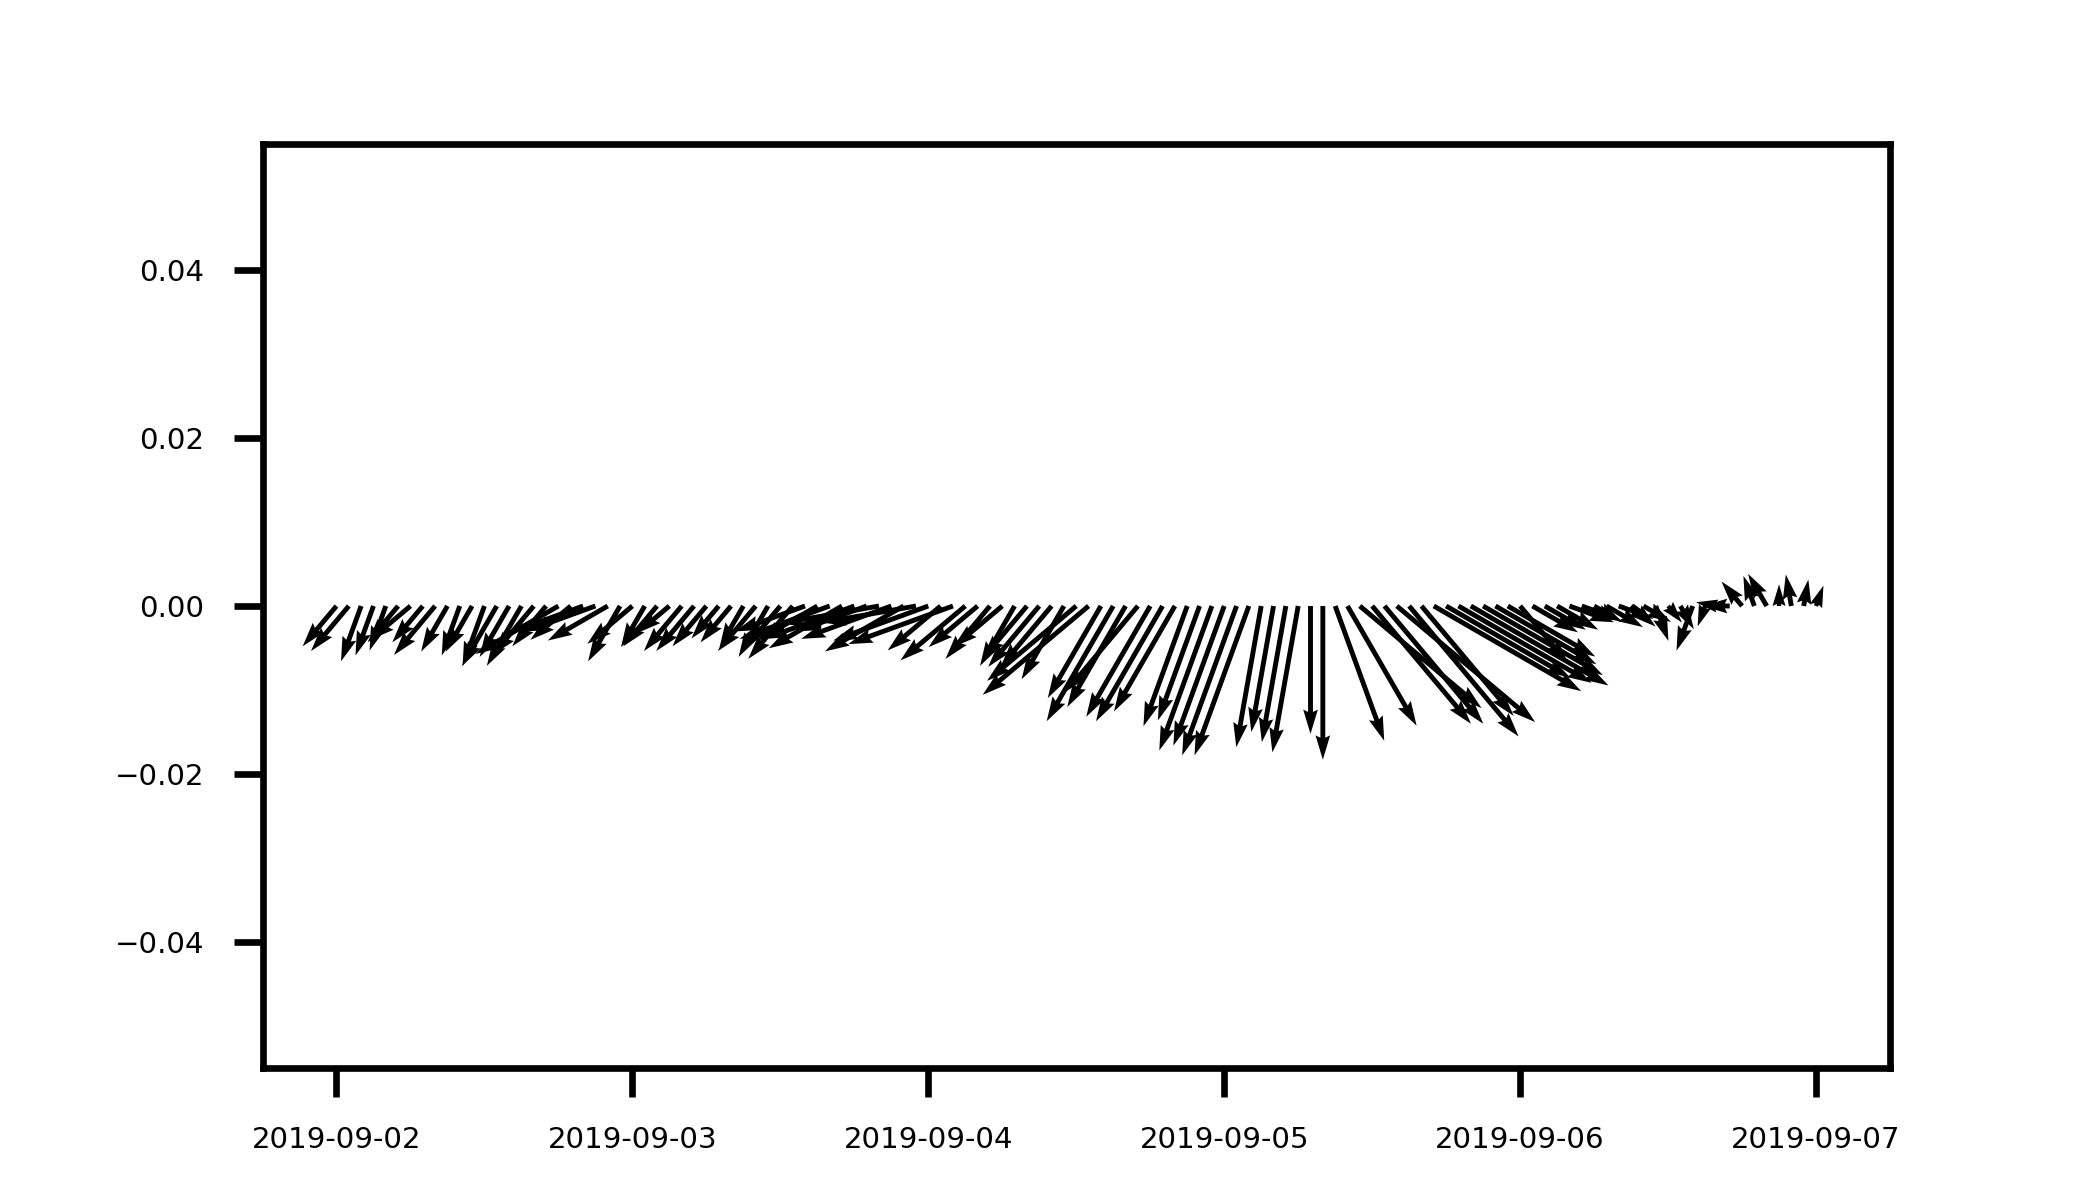

In [67]:
# dorian_wind = pd.read_excel('testwind/testwind.xlsx',skiprows=[0], converters={'HrMn': lambda x: str(x),'Date': lambda x: str(x)})
# dorian_wind.drop(dorian_wind[dorian_wind.Dir==999].index,inplace=True)
# dorian_wind['timestamp']=pd.to_datetime(dorian_wind['Date']+dorian_wind['HrMn'])

dorian_wind = pd.read_excel('dorian_wind_data.xlsx',skiprows=[0], converters={'HrMn': lambda x: str(x),'Date': lambda x: str(x)})
dorian_wind.drop(dorian_wind[dorian_wind.Dir==999].index,inplace=True)
dorian_wind['timestamp']=pd.to_datetime(dorian_wind['Date']+dorian_wind['HrMn'])

est = pytz.timezone("America/New_York")
dorian_wind['timestamp'] = dorian_wind['timestamp'].map(lambda time: (est.localize(time)))

dir_right=[]
for i in dorian_wind['Dir']:
    if i<90:
        dir_right.append(abs(90-i)+180)
    else:
        dir_right.append(180-(i-90))
        
dorian_wind['newDir']=dir_right

dir_right=[]
for i in dorian_wind[dorian_wind.USAF==997301]['Dir']:
    if i<90:
        dir_right.append(abs(90-i)+180)
    else:
        dir_right.append(180-(i-90))

dir_rad=[float(i)*np.pi/180 for i in dir_right]
u=np.cos(dir_rad)*dorian_wind[dorian_wind.USAF==997301]['Spd']
v=np.sin(dir_rad)*dorian_wind[dorian_wind.USAF==997301]['Spd']
y=np.zeros(len(dorian_wind[dorian_wind.USAF==997301]))
# len(u),len(y),len(v),len(dorian_wind[dorian_wind.USAF==997301].timestamp)


# dorian_wind[dorian_wind.USAF==722070]
# dorian_wind[dorian_wind.USAF==997301]

u1=np.ones(len(dorian_wind[dorian_wind.USAF==997301]))-0.7
v1=np.ones(len(dorian_wind[dorian_wind.USAF==722070]))-0.7


%matplotlib notebook

fig = plt.figure(figsize=(3.5,2), dpi=300)
# plt.ylabel('Water Level in feet (NAVD88)', fontsize=4, labelpad=2 )
# plt.xlabel('Time', fontsize=4, labelpad=11)
plt.tick_params(axis='x', labelsize=3.5)
plt.tick_params(axis='y', labelsize=3.5)
# plt.grid( linewidth=0.2)

# plt.plot(dorian_wind[dorian_wind.USAF==722070].timestamp,dorian_wind[dorian_wind.USAF==722070].Spd,'.',ms=3)
# plt.quiver(dorian_wind[dorian_wind.USAF==722070].timestamp,dorian_wind[dorian_wind.USAF==722070].Spd,v,v,angles=dorian_wind[dorian_wind.USAF==722070].newDir, color='blue', scale=10)

# plt.plot(dorian_wind[dorian_wind.USAF==997301].timestamp,dorian_wind[dorian_wind.USAF==997301].Spd,'.',ms=1)
# plt.quiver(dorian_wind[dorian_wind.USAF==997301].timestamp,dorian_wind[dorian_wind.USAF==997301].Spd,u1,u1,angles=dorian_wind[dorian_wind.USAF==997301].newDir, color='orange',scale=10, width=0.003)
plt.quiver(dorian_wind[dorian_wind.USAF==997301].timestamp,y,u,v,width=0.003)

### NOAA DATA

In [15]:
# observed data:
ftp_data = get_noaa_water_level_data(dorianstart, dorianend)

# astronomical predictions:
ftp_data_pred= pd.read_csv('Dorian_ftp_predictions.csv')
ftp_data_pred['timestamp']=pd.to_datetime(ftp_data_pred['Date']+' '+ftp_data_pred['Time (LST/LDT)'])

est = pytz.timezone("America/New_York")
ftp_data_pred['timestamp'] = ftp_data_pred['timestamp'].map(lambda time: (est.localize(time)))
ftp_data_pred=ftp_data_pred[(ftp_data_pred['timestamp']>dorianstart)&(ftp_data_pred['timestamp']<dorianend)]
# ftp_data_pred

### SSLS DATA

In [16]:
sensors_water

coords  \
0   [-80.962163, 32.018171]   
1   [-81.201916, 31.791509]   
2   [-81.153906, 31.935783]   
3   [-81.021504, 31.990396]   
4   [-80.866956, 32.006419]   
5   [-81.011631, 32.052507]   
6   [-81.203851, 32.039975]   
7   [-80.866956, 32.006419]   
8    [-80.902494, 32.03455]   
9   [-80.991889, 32.020471]   
10  [-80.902507, 32.034488]   
11  [-81.010769, 31.958661]   
12  [-81.021504, 31.990396]   
13  [-81.210754, 32.168133]   
14  [-81.086168, 31.928811]   
15   [-81.296069, 31.41796]   
16     [-81.058319, 32.013]   
17  [-81.084099, 32.085707]   
18  [-81.084056, 31.951711]   
19  [-81.139343, 31.932421]   
20  [-81.102928, 31.936685]   
21    [-81.07081, 31.98277]   
22  [-81.187966, 32.172647]   
23  [-81.055977, 31.993082]   
24  [-81.213645, 32.050608]   
25  [-80.884092, 32.014112]   
26  [-81.092435, 31.930439]   
27  [-81.156335, 32.164164]   
28  [-81.063662, 32.000149]   
29   [-80.850964, 32.01831]   
30  [-80.994272, 31.987188]   
31  [-81.031204, 32.038669]   
32    [-81.08402, 31.92835]   
33  [-81.210754, 32.168133]   
34  [-81.061556, 31.889711]   
35  [-81.210754, 32.168133]   
36  [-79.782415, 36.097947]   
37  [-80.959417, 32.034717]   

                                                 desc    elev  \
0                 Walthour Road environmental sensors   2.768   
1                Kilkenny Creek environmental sensors     2.7   
2           Coffee Bluff Marina environmental sensors     2.4   
3                 Skidaway Dock environmental sensors   3.103   
4                Catalina Drive environmental sensors    2.23   
5           Oatland Island Road environmental sensors    2.74   
6               Hwy 17 at Salt Creek Sea Level Sensor    2.74   
7                     Catalina Drive Sea Level Sensor     2.5   
8                   Fort Pulaski (A) Sea Level Sensor    3.00   
9             Turner Creek Boat Ramp Sea Level Sensor   2.492   
10                  Fort Pulaski (B) Sea Level Sensor    3.00   
11            Landings Harbor Marina Sea Level Sensor    3.00   
12                         SKIO Dock Sea Level Sensor   3.103   
13                          Calibration test unit 031    None   
14     Hunt Drive on Burnside Island Sea Level Sensor     3.6   
15          Sapelo Island Ferry Dock Sea Level Sensor     1.5   
16                    Savannah State Sea Level Sensor     3.7   
17            Hutchinson Island environmental sensors   4.711   
18  Diamond Causeway at Shipyard Creek Sea Level S...   2.794   
19                   Rose Dhu Island Sea Level Sensor   2.986   
20                     Shipyard Road Sea Level Sensor   3.085   
21       Skidaway Road at Herb River Sea Level Sensor   2.406   
22          Hwy 21 at St Augustine Creek Level Sensor   2.756   
23                    Solomon Bridge Sea Level Sensor   4.807   
24  Dean Forest Road at Harden Canal Sea Level Sensor   2.229   
25      Lazaretto Creek Fishing Pier Sea Level Sensor   2.309   
26                   Sullivan Street Sea Level Sensor   2.513   
27                Houlihan Boat Ramp Sea Level Sensor   1.899   
28  LaRoche Avenue at Nottingham Creek Sea Level S...   2.432   
29  Hwy 80 at Chimney Creek on Tybee Island Sea Le...   3.213   
30             Wilmington Park Canal Sea Level Sensor   3.022   
31             Hwy 80 at Grays Creek Sea Level Sensor   3.593   
32     Faye Drive on Burnside Island Sea Level Sensor   3.708   
33                          Calibration test unit 021    None   
34              Delegal Creek Marina Sea Level Sensor    2.00   
35                          Calibration test unit 019    None   
36  North Church Street at North Buffalo Creek Wat...  716.17   
37            Bull River Marina environmental sensors   3.041   

                                                 link                   name  
0   https://api.sealevelsensors.org/v1.0/Datastrea...        gt-envsense-009  
1   https://api.sealevelsensors.org/v1.0/Datastrea...        gt-envsense-004  
2   https://api.sealevelsensors.org/v1

In [17]:
slsdata1 = get_sls_water_level_data(sensors_water.desc[10], dorianstart, dorianend)
#nearest neighbor filtering
slsdata1 = slsdata1[abs(slsdata1['adj_value'] - slsdata1['adj_value'].shift(1)) < 0.3] 
slsdata1 = slsdata1[abs(slsdata1['adj_value'] - slsdata1['adj_value'].shift(-1)) < 0.3]

slsdata2 = get_sls_water_level_data(sensors_water.desc[37], dorianstart, dorianend)
#nearest neighbor filtering
slsdata2 = slsdata2[abs(slsdata2['adj_value'] - slsdata2['adj_value'].shift(1)) < 0.3] 
slsdata2 = slsdata2[abs(slsdata2['adj_value'] - slsdata2['adj_value'].shift(-1)) < 0.3]

slsdata3 = get_sls_water_level_data(sensors_water.desc[29], dorianstart, dorianend)
#nearest neighbor filtering
slsdata3 = slsdata3[abs(slsdata3['adj_value'] - slsdata3['adj_value'].shift(1)) < 0.3] 
slsdata3 = slsdata3[abs(slsdata3['adj_value'] - slsdata3['adj_value'].shift(-1)) < 0.3]

slsdata4 = get_sls_water_level_data(sensors_water.desc[18], dorianstart, dorianend)
#nearest neighbor filtering
slsdata4 = slsdata4[abs(slsdata4['adj_value'] - slsdata4['adj_value'].shift(1)) < 0.3] 
slsdata4 = slsdata4[abs(slsdata4['adj_value'] - slsdata4['adj_value'].shift(-1)) < 0.3]

slsdata5 = get_sls_water_level_data(sensors_water.desc[24], dorianstart, dorianend)
#nearest neighbor filtering
slsdata5 = slsdata5[abs(slsdata5['adj_value'] - slsdata5['adj_value'].shift(1)) < 0.3] 
slsdata5 = slsdata5[abs(slsdata5['adj_value'] - slsdata5['adj_value'].shift(-1)) < 0.3]

slsdata6 = get_sls_water_level_data(sensors_water.desc[22], dorianstart, dorianend)
#nearest neighbor filtering
slsdata6 = slsdata6[abs(slsdata6['adj_value'] - slsdata6['adj_value'].shift(1)) < 0.3] 
slsdata6 = slsdata6[abs(slsdata6['adj_value'] - slsdata6['adj_value'].shift(-1)) < 0.3]


<IPython.core.display.Javascript object>


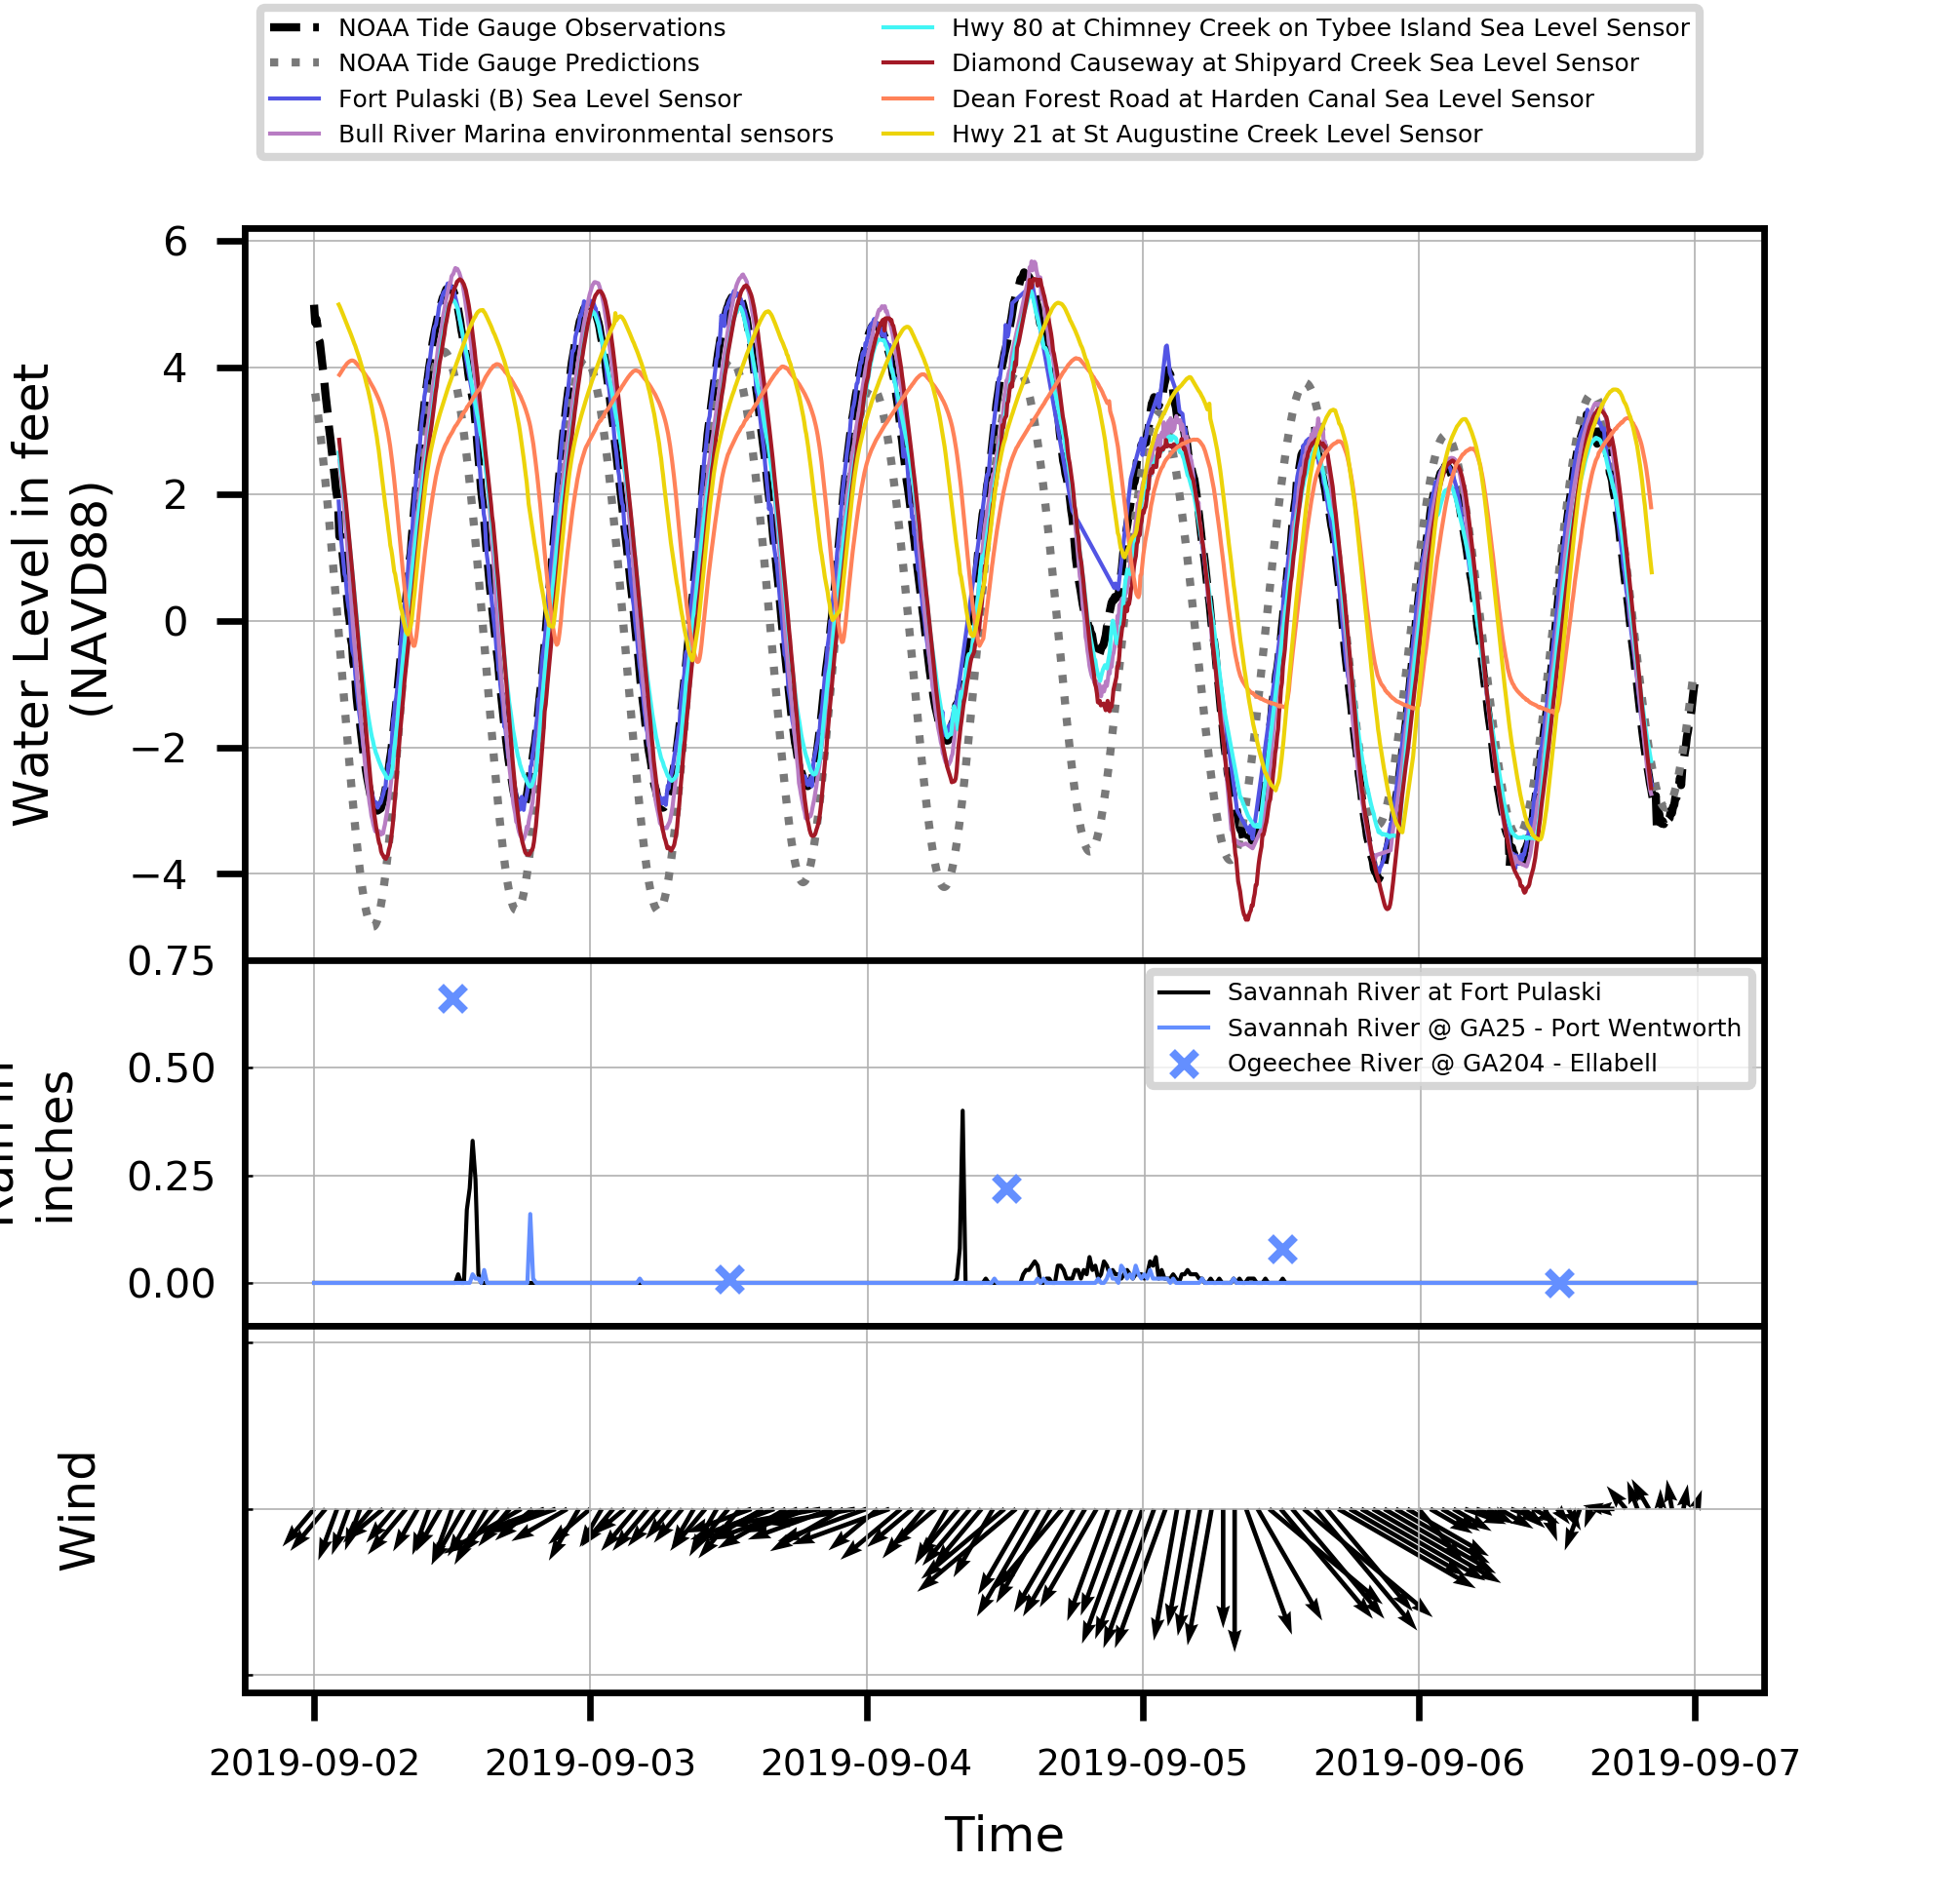

In [117]:
%matplotlib notebook

fig = plt.figure(figsize=(3.35,3.25), dpi=300) #gridspec_kw={'hspace': 0, 'wspace': 0})
gs = fig.add_gridspec(8, 1)
fig.subplots_adjust(hspace=0)

a = fig.add_subplot()
a.tick_params(labelbottom=False, labelleft=False, which='both', top=False, bottom=False, left=False, right=False)
#a.set_ylabel('Water Level (ft)', fontsize=30, labelpad=60 )
a.set_xlabel('Time', fontsize=6, labelpad=15)

a0 = fig.add_subplot(gs[0:4, :])

a0.plot(ftp_data['timestamp'], ftp_data['adj_value'], label='NOAA Tide Gauge Observations', color="black",linewidth=1,linestyle='dashed')
a0.plot(ftp_data_pred['timestamp'], ftp_data_pred['Predicted (ft)'], label='NOAA Tide Gauge Predictions', color="#797979",linewidth=1,linestyle='dotted')

a0.plot(slsdata1['timestamp'], slsdata1['adj_value'], label=sensors_water.desc[10], color="#5254E4",linewidth=0.5)
a0.plot(slsdata2['timestamp'], slsdata2['adj_value'], label=sensors_water.desc[37], color="#B87CC3",linewidth=0.5)
a0.plot(slsdata3['timestamp'], slsdata3['adj_value'], label=sensors_water.desc[29], color="#42F5F5",linewidth=0.5)

a0.plot(slsdata4['timestamp'], slsdata4['adj_value'], label=sensors_water.desc[18], color="#A31926",linewidth=0.5)
a0.plot(slsdata5['timestamp'], slsdata5['adj_value'], label=sensors_water.desc[24], color="#FF8259",linewidth=0.5)
a0.plot(slsdata6['timestamp'], slsdata6['adj_value'], label=sensors_water.desc[22], color="#ECD309",linewidth=0.5)
# a0.xaxis.set_major_locator(pldates.DayLocator(interval=1))
a0.tick_params(axis='y', labelsize=5)
a0.set_ylabel('\n'.join(wrap('Water Level in feet (NAVD88)',20)), fontsize=6, labelpad=2)
a0.grid( linewidth=0.2)
a0.set_xticklabels([])

fig.legend( loc="upper center",borderaxespad=0.3, fancybox=True, shadow=False, ncol=2, fontsize = 3)

a2 = fig.add_subplot(gs[4:6, :])

# a2.set_ylabel('Rain (inches)', color='black', fontsize=4, labelpad=2)  # we already handled the x-label with ax1
a2.plot(ftpRain['timestamp'], ftpRain['38734_00045_cd'],color='black', linewidth=0.5, label='Savannah River at Fort Pulaski')
a2.tick_params(axis='y', labelcolor='black', labelsize=3.5)
a2.plot(sav25Rain['timestamp'], sav25Rain['38616_00045_cd'],color='#648FFF', linewidth=0.5, label='Savannah River @ GA25 - Port Wentworth')
a2.plot(ogch204['timestamp'],ogch204['totals'], 'x',color='#648FFF', label='Ogeechee River @ GA204 - Ellabell',ms=3)


a2.tick_params(axis='y', labelsize=5)
a2.set_ylabel('\n'.join(wrap('Rain in inches',12)), fontsize=6, labelpad=6)
a2.set_ylim(-0.1, 0.75)
a2.grid(True, linewidth=0.2)
a2.tick_params(axis="y", direction="in", length=1, width=0.3)
# a2.xaxis.set_major_locator(pldates.DayLocator(interval=1))
a2.set_xticklabels([])
# timezone = pytz.timezone("America/New_York")
# auto = pldates.AutoDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# concise = pldates.ConciseDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# a2.xaxis.set_major_formatter(concise)
# a3.get_xaxis().get_major_formatter().set_useOffset(False)
a2.legend( loc="upper right", fontsize=3)


# a4 = fig.add_subplot(gs[8:10, :])

# # a2.set_ylabel('Rain (inches)', color='black', fontsize=4, labelpad=2)  # we already handled the x-label with ax1
# a4.plot(sav25Rain['timestamp'], sav25Rain['38616_00045_cd'],color='black', linewidth=0.5, label='Savannah River @ GA25 - Port Wentworth')
# a4.plot(ogch204['timestamp'],ogch204['totals'], 'kx', label='Ogeechee River @ GA204 - Ellabell',ms=3)
# a4.tick_params(axis='y', labelcolor='black', labelsize=3.5)

# a4.tick_params(axis='y', labelsize=5)
# a4.set_ylabel('\n'.join(wrap('Inland Rain in inches',12)), fontsize=4.5, labelpad=7)
# a4.set_ylim(-0.1, 0.75)
# a4.grid(True, linewidth=0.2)
# a4.tick_params(axis="y", direction="in", length=1, width=0.3)
# # a2.xaxis.set_major_locator(pldates.DayLocator(interval=1))
# a4.set_xticklabels([])
# # timezone = pytz.timezone("America/New_York")
# # auto = pldates.AutoDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# # concise = pldates.ConciseDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# # a2.xaxis.set_major_formatter(concise)
# # a3.get_xaxis().get_major_formatter().set_useOffset(False)
# a4.legend( loc="upper right", fontsize=3)

a3 = fig.add_subplot(gs[6:8, :])

# a2.set_ylabel('Rain (inches)', color='black', fontsize=4, labelpad=2)  # we already handled the x-label with ax1
# a3.plot(dorian_wind[dorian_wind.USAF==997301].timestamp,dorian_wind[dorian_wind.USAF==997301].Spd,'.',ms=1)
# a3.quiver(dorian_wind[dorian_wind.USAF==997301].timestamp,dorian_wind[dorian_wind.USAF==997301].Spd,u,u,angles=dorian_wind[dorian_wind.USAF==997301].newDir, color='black',scale=10, width=0.002)
a3.quiver(dorian_wind[dorian_wind.USAF==997301].timestamp,y,u,v,width=0.003)

a3.tick_params(axis='y', labelsize=5)
a3.set_ylabel('\n'.join(wrap('Wind',12)), fontsize=6, labelpad=14)
# a2.set_ylim(0, 9.9)
a3.grid(True, linewidth=0.2)
a3.tick_params(axis="y", direction="in", length=1, width=0.3)
a3.set_yticklabels([])

# timezone = pytz.timezone("America/New_York")
# auto = pldates.AutoDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# concise = pldates.ConciseDateFormatter(pldates.AutoDateLocator(), tz=timezone)
# a2.xaxis.set_major_formatter(concise)
# a3.get_xaxis().get_major_formatter().set_useOffset(False)

a3.tick_params(axis='x', labelsize=4.5)
# a2.tick_params(axis="x", direction="out", length=2, width=0.5)
# a3.xaxis.set_major_locator(pldates.DayLocator(interval=1))


# plt.legend(bbox_to_anchor=(0.71, 0.32), fontsize =30);

# fig.legend(bbox_to_anchor=(1, 1), fontsize =15)
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, shadow=False, fontsize =30)
# fig.legend( loc="upper center",borderaxespad=0, fancybox=True, shadow=False, ncol=2, fontsize = 3)
# plt.subplots_adjust(bottom=0.16)

# fig.tight_layout()
fig.patch.set_facecolor('white')

plt.savefig('DorianTimeSeires.jpg', bbox_inches='tight', dpi=1200)#, bbox_extra_artist=[fig.legend])



In [ ]:
ftpRain['38734_00045_cd'].values.sum()